In [1]:
# import packages
import os
import bisect
import hashlib
import json
import allel
import numpy as np
import dask
import dask.array as da
from dask.diagnostics import ProgressBar
# quieten dask warnings about large chunks
dask.config.set(**{'array.slicing.split_large_chunks': True})
import pandas as pd
import malariagen_data
import plotly.express as px
import random
import itertools
import scipy.stats
# plotting setup
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import matplotlib_venn as venn
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')
sns.set_style('ticks')
plt.rcParams['figure.max_open_warning'] = 1000

import scipy.stats as stats
import statsmodels.api as sm
import scipy.spatial.distance as distance

from sklearn.decomposition import PCA

## Beware
import warnings
warnings.filterwarnings('ignore')

# Abafar Setup

In [2]:
# gain access to the gateway
from dask_gateway import Gateway
gateway = Gateway()

In [3]:
for c in gateway.list_clusters():
    gateway.stop_cluster(c.name)

In [4]:
gateway.list_clusters()

[]

In [5]:
# create a cluster with the options selected via the widgets above
# ... may take a few minutes to provision a VM for the scheduler
cluster = gateway.new_cluster(environment="binder-v3.2.0", profile="Very High Memory Worker")
cluster

In [6]:
# you can scale the cluster using the widget above, or via a manual API call
# ... may take a few minutes to provision VMs for the workers
cluster.scale(200)

In [7]:
# get a client - this tells Dask to use the cluster you've just created
client = cluster.get_client()

# Functions setup

In [8]:
def load_tbl_samples_sub(subsets, seed, dataframe, max_population_size = 100):
    
    random.seed(seed)
    
    #with section('compute subset sizes'):
    subset_sizes = [len(dataframe[dataframe.population == q]) for q in subsets]
    subset_sizes.append(max_population_size)
    n = min(subset_sizes)
    #print(n)

    subsets_sidx = dict()
    for p in subsets:
        subsets_sidx[p] = sorted(random.sample(list(dataframe[dataframe.population == p].index), n))

    sidx = list(itertools.chain(*subsets_sidx.values()))
    
    return sidx, subsets_sidx

In [9]:
import sys


def log(*msg):
    print(*msg, file=sys.stdout)
    sys.stdout.flush()


In [10]:
import functools


@functools.lru_cache(maxsize=None)
def count_hom_alt_genotypes(chrom, site_mask, sidx, sample_sets):
    log('load and subset genotypes')
    gt = allel.GenotypeDaskArray(ag3.snp_genotypes(contig=chrom, sample_sets=sample_sets, site_mask=site_mask))
    genotype_sub = gt.take(list(sidx), axis=1)

    log('count hom alt genotypes')
    n_hom_alt = genotype_sub.count_hom_alt(axis=1).compute()
    return n_hom_alt

@functools.lru_cache(maxsize=None)
def count_alleles(chrom, site_mask, sidx, sample_sets):
    log('load and subset genotypes')
    gt = allel.GenotypeDaskArray(ag3.snp_genotypes(contig=chrom, sample_sets=sample_sets, site_mask=site_mask))
    genotype_sub = gt.take(list(sidx), axis=1)

    log('count alleles')
    ac_sub = genotype_sub.count_alleles(max_allele=3).compute()
    
    log('filter for missingness')
    # no_miss = (genotype_sub.count_missing(axis = 1) == 0)
    an_sub = ac_sub.sum(axis=1)
    n_samples = genotype_sub.shape[1]
    no_miss = (an_sub == (n_samples * 2))
    return ac_sub, an_sub, no_miss

In [11]:
def load_dbl_pos(chrom, site_mask, sidx, sample_sets="1177-VO-ML-LEHMANN-MNF00004"):
    log('load and subset genotypes')
    gt = allel.GenotypeDaskArray(ag3.snp_genotypes(contig=chrom, sample_sets=sample_sets, site_mask=site_mask))
    genotype_sub = gt.take(sidx, axis=1)
    
    #n_hom_alt = count_hom_alt_genotypes(chrom, site_mask, tuple(sidx), sample_sets)
    log('count hom alt genotypes')
    n_hom_alt = genotype_sub.count_hom_alt(axis=1).compute()
    client.restart()
        
    #ac_sub, an_sub, no_miss = count_alleles(chrom, site_mask, tuple(sidx), sample_sets)
    log('count alleles')
    ac_sub = genotype_sub.count_alleles(max_allele=3).compute()
    
    log('filter for missingness')
    # no_miss = (genotype_sub.count_missing(axis = 1) == 0)
    an_sub = ac_sub.sum(axis=1)
    n_samples = genotype_sub.shape[1]
    no_miss = (an_sub == (n_samples * 2))
    client.restart()
    
    log('locate doubletons')
    # use only ALT doubletons, ignore REF doubletons as very few
    loc_dbl = (np.sum(ac_sub[:,1:], axis=1) == 2) & ((ac_sub[:, 1] == 2) | (ac_sub[:, 2] == 2) | (ac_sub[:, 3] == 2)) & (n_hom_alt == 0)
    
    return loc_dbl & no_miss

In [12]:
def load_dbl_gn(chrom, site_mask, sidx, sample_sets="1177-VO-ML-LEHMANN-MNF00004"):
    log('load and subset genotypes')
    gt = allel.GenotypeDaskArray(ag3.snp_genotypes(contig=chrom, sample_sets=sample_sets, site_mask=site_mask))
    genotype_sub = gt.take(sidx, axis=1)
    
    log('locate doubletons')
    # use only ALT doubletons, ignore REF doubletons as very few
    loc_dbl = load_dbl_pos(chrom, site_mask, sidx, sample_sets=sample_sets)

    log('compress genotypes to doubletons')
    genotype_dbl = genotype_sub.compress(loc_dbl, axis=0)
    gn_dbl = genotype_dbl.to_n_alt().compute()
    log("Number of positions kept: " + str(genotype_dbl.shape[0]))

    return gn_dbl, loc_dbl

In [13]:
def _dbl_count(x, y):
    return np.count_nonzero((x == 1) & (y == 1))

def count_pairwise_doubletons(chrom, site_mask, sidx, sample_sets="1177-VO-ML-LEHMANN-MNF00004"):
    
    #with section('load doubleton genotypes'):
    gn_dbl, loc_dbl = load_dbl_gn(chrom, site_mask, sidx, sample_sets)
    
    log('count pairwise shared doubletons')
    pairwise_dbl = allel.pairwise_distance(gn_dbl, _dbl_count, chunked=True)

    return pairwise_dbl, loc_dbl

In [14]:
def plot_pw_dbl_sub(pairwise_dbl, populations, pop_col, pop_labels, df_samples_sub, fig=None):
    #assert len(populations) == len(pop_col)
    
    n = df_samples_sub.shape[0]
    yy_mean = list()
    yy_median = list()
    ee = list()
    for subset_id1 in populations:
        pop1 = list(df_samples_sub[df_samples_sub.population == subset_id1].index)
        y_mean = list()
        y_median = list()
        e = list()
        for subset_id2 in populations:
            if subset_id1 != subset_id2:
                pop2 = list(df_samples_sub[df_samples_sub.population == subset_id2].index)
                pidx = allel.condensed_coords_between(pop1, pop2, n)
            else:
                pidx = allel.condensed_coords_within(pop1, n)
            d = pairwise_dbl.take(pidx)
            y_mean.append(np.mean(d))
            y_median.append(np.median(d))
            e.append(scipy.stats.sem(d))
        yy_mean.append(y_mean)
        yy_median.append(y_median)
        ee.append(e)
    yy_mean = np.array(yy_mean)
    yy_median = np.array(yy_median)
    ee = np.array(ee)

    # yy is number of doubletons shared
    if fig is None:
        fig = plt.figure(figsize=(1 + .3*len(populations), 1 + .3*len(populations)))
        
    gs = GridSpec(len(populations), 2, width_ratios=(9, 1))
    
    for i1 in range(len(populations)):    
        ax = fig.add_subplot(gs[i1, 0])
        sns.despine(ax=ax, left=True, bottom=True, top=True)
        p1 = pop_labels[i1]
        y = yy_mean[i1]
        print('Y:' + str(y))
        e = ee[i1]
        print('E:' + str(e))
        ax.bar(np.arange(len(populations)) + .05, y, width=.9, color=pop_col, lw=0)
        ax.set_xlim(0, len(populations))
        ax.set_xticks([])
        ax.set_ylabel(p1, fontweight='bold', color="#2b2b2b", rotation=0, ha='right', va='center')
        ymax = np.sum(y)
        ax.set_ylim(0, ymax)
        ax.set_yticks([])
        if i1 == 0:
            for i in range(len(populations)):
                ax.text((i+.4)/len(populations), 1.1, pop_labels[i], color=pop_col[i], transform=ax.transAxes, rotation=45,
                        ha='left', va='bottom', fontweight='bold')
    
            # add f2 label
            ax.text(x=(i+1.9)/len(populations), y=1.1, s='$f_{2}$ variants', 
                    color="#525252", transform=ax.transAxes, rotation=45,
                    ha='left', va='bottom', fontweight='bold')
            
    # define upper limit of right hand bar plot
    maxsum = yy_mean.sum(axis=1).max() * 1.05
    ceiling = np.ceil(maxsum/10) * 10
    
    for i1 in range(len(populations)):    
        
        ax2 = fig.add_subplot(gs[i1, 1])
        y = yy_mean[i1]            
        #ax2 = fig.add_subplot(gs[:, 1])
        ax2.barh([0.5], [np.sum(y)], color='#525252', align="center", height=0.8)
        ax2.set_xlim((0, ceiling))
        
        #if i1 == (len(subsets) -1):
        if False:
            sns.despine(ax=ax2, left=True, bottom=False, top=True)
            ax2.set_xticks((0, ceiling))
        else:
            sns.despine(ax=ax2, left=True, bottom=True, top=True)
            ax2.set_xticks([])
        
        ax2.set_yticks([])

In [15]:
def compute_doubleton_count(ref_populations, query_set, seed, ref_dataframe, query_dataframe, sample_sets, max_population_size=100):
    sidx, sub_sidx = load_tbl_samples_sub(ref_populations, seed, ref_dataframe, max_population_size)
    df_samples_sub = pd.concat([ref_dataframe[ref_dataframe.index.isin(sub_sidx[p])] for p in ref_populations] + [query_dataframe])
    df_samples_sub.reset_index(drop=True, inplace=True)
    first_query_idx = allel.GenotypeDaskArray(ag3.snp_genotypes(contig='3R', sample_sets=sample_sets, site_mask='gamb_colu')).shape[1]
    sidx = sidx + [(first_query_idx + i) for i in range(0,len(query_dataframe))]
    pairwise_dbl_3R, loc_dbl_3R = count_pairwise_doubletons('3R', 'gamb_colu', sidx, sample_sets + [query_set])
    pairwise_dbl_3L, loc_dbl_3L = count_pairwise_doubletons('3L', 'gamb_colu', sidx, sample_sets + [query_set])
    return sidx, sub_sidx, df_samples_sub, pairwise_dbl_3L, pairwise_dbl_3R, loc_dbl_3L, loc_dbl_3R

In [16]:
def setup_by_query_set(sample_sets_ref, query_set, min_set_size = None):
    df_ref_pre_check = ag3.sample_metadata(sample_sets=sample_sets_ref)
    df_ref_pre_check = df_ref_pre_check[df_ref_pre_check.species_gambcolu_arabiensis == 'gamb_colu']
    df_ref_pre_check['population'] = df_ref_pre_check['country'] + " " + df_ref_pre_check['species']
    df_query = ag3.sample_metadata(sample_sets=query_set)
    df_query['population'] = query_set
    if min_set_size:
        df_ref_check_pop_counts = df_ref_pre_check.population.value_counts()
        df_ref_check = df_ref_pre_check[df_ref_pre_check.population.isin(df_ref_check_pop_counts[df_ref_check_pop_counts >= min_set_size].index)]
    else:
        df_ref_check = df_ref_pre_check
    ref_check_populations = list(df_ref_check.population.unique())
    return ref_check_populations, df_ref_check, df_query

In [17]:
def heatmap_compare_populations(ref_populations, query_set, seed, ref_dataframe, query_dataframe, sample_sets, max_population_size=100):
    sidx, sub_sidx, df_samples_sub, pairwise_dbl_3L, pairwise_dbl_3R, loc_dbl_3L, loc_dbl_3R = compute_doubleton_count(ref_populations, query_set, seed, ref_dataframe, query_dataframe, sample_sets, max_population_size)
    n = df_samples_sub.shape[0]

    pairwise_dbl = pairwise_dbl_3L + pairwise_dbl_3R

    sub_ids = {pop: list(df_samples_sub[df_samples_sub.population == pop].index) for pop in ref_populations}
    n_pop_ref = len(ref_populations)
    n_q_samples = len(query_dataframe)
    first_query_id = df_samples_sub[df_samples_sub.population == query_set].index[0]
    score_all = np.zeros((n_q_samples, n_pop_ref))
    p_val_all = np.zeros((n_q_samples, n_pop_ref))
    
    for i in range(0, n_q_samples):
        for j, pop in enumerate(ref_populations):
            #print(pop)
            score, p_val = stats.kstest(pairwise_dbl[allel.condensed_coords_between([i+first_query_id], sub_ids[pop], len(sidx))],
                                        pairwise_dbl[allel.condensed_coords_within(sub_ids[pop], len(sidx))])
            score_all[i,j], p_val_all[i,j] = min(score, .45), p_val

    score_all_df = pd.DataFrame(data=score_all, index=query_dataframe.sample_id, columns=ref_populations)

    fig, ax = plt.subplots(figsize=(n_pop_ref*2,n_q_samples/4.5))  
    sns.heatmap(score_all_df, annot=p_val_all, ax=ax)

In [18]:
def heatmap_compare_short(population, cohorts, cohorts_idx_query, cohorts_idx_ref, ssidx, pairwise_dbl):
    n_pop_ref = len(cohorts)
    n_q_samples = len([ssidx.index(i) for i in cohorts_idx_query[population]])
    score_all = np.zeros((n_q_samples, n_pop_ref))
    p_val_all = np.zeros((n_q_samples, n_pop_ref))
    #log(population)
    for i, idx in enumerate([ssidx.index(i) for i in cohorts_idx_query[population]]):
        for j, pop in enumerate(cohorts):
            #log(pop)
            score, p_val = stats.kstest(pairwise_dbl[allel.condensed_coords_between([idx], [ssidx.index(i) for i in cohorts_idx_ref[pop]],
                                                                                    len(ssidx))],
                                        pairwise_dbl[allel.condensed_coords_within([ssidx.index(i) for i in cohorts_idx_ref[pop]],
                                                                                   len(ssidx))])
            score_all[i,j], p_val_all[i,j] = min(score, .45), p_val
    
    if population == "1177-VO-ML-LEHMANN-VMF00015":
        labels = ag3.sample_metadata("1177-VO-ML-LEHMANN-VMF00015")[ag3.sample_metadata("1177-VO-ML-LEHMANN-VMF00015").index.isin(query_idx_in_ball)].sample_id
    elif population in ["Dall154col", "Soko154col"]:
        labels = ag3.sample_metadata('v3.1')[ag3.sample_metadata('v3.1').index.isin(cohorts_idx_query_loc[population])].sample_id
        
    else:
        labels = ag3.sample_cohorts()[ag3.sample_cohorts().index.isin(cohorts_idx_query[population])].sample_id
    
    log_data = np.where(p_val_all < .05, -2, np.log10(p_val_all)) 
    p_val_all_df = pd.DataFrame(data=log_data, index=labels, columns=cohorts)

    fig, ax = plt.subplots(figsize=(n_pop_ref*2,n_q_samples/2)) 
    ax.title.set_text(population)
    sns.heatmap(p_val_all_df, annot=p_val_all, ax=ax)
    plt.show()

In [19]:
def estimate_cohort_assignment_precision(sub_cohort = 'query'):
    n_pop_ref = len(cohorts_red)
    if sub_cohort == 'query':
        query_indexes = [ssidx.index(i) for i in list(itertools.chain(*cohorts_idx_query.values()))]
    elif sub_cohort == 'ref':
        query_indexes = [ssidx.index(i) for i in list(itertools.chain(*cohorts_idx_ref.values()))]
    else:
        query_indexes = [ssidx.index(i) for i in list(itertools.chain(*cohorts_idx_ref_query.values()))]
    n_q_samples = len(query_indexes)
    score_all = np.zeros((n_q_samples, n_pop_ref))
    p_val_all = np.zeros((n_q_samples, n_pop_ref))

    for i, idx in enumerate(query_indexes):
        for j, pop in enumerate(cohorts_red):
            ref_idx = [ssidx.index(i) for i in cohorts_idx_ref[pop]]
            if idx in ref_idx:
                ref_idx.remove(idx)
            score, p_val = stats.kstest(pairwise_dbl[allel.condensed_coords_between([idx], ref_idx, len(sidx))],
                                        pairwise_dbl[allel.condensed_coords_within(ref_idx, len(sidx))])
            score_all[i,j], p_val_all[i,j] = min(score, .45), p_val

    return score_all, p_val_all

In [20]:
def hist_comparison_plot(ref, query, ssidx):
    bins = range(0,300,10)
    #plt.hist(pairwise_dbl[allel.condensed_coords_within([ssidx.index(i) for i in cohorts_idx_ref[ref]], len(ssidx))], label='within', bins=bins)
    #for i in range(0,n_query):
    plt.hist([pairwise_dbl[allel.condensed_coords_between([ssidx.index(cohorts_idx_query[query][i])]
                                                          , [ssidx.index(i) for i in cohorts_idx_ref[ref]], len(ssidx))]for i in range(0,n_query)],
              label = [list(ag3.sample_cohorts()[ag3.sample_cohorts().index.isin(cohorts_idx_query[query])].sample_id)[i] for i in range(0,n_query)],
              bins=bins, histtype='barstacked')
    plt.legend(loc='upper right')
    plt.show()

# Data setup - Lehmann 3.1 - colu

In [21]:
n_ref = 20

In [22]:
n_query = 5

In [23]:
# setup access to malariagen data in google cloud
ag3 = malariagen_data.Ag3("gs://vo_agam_release/", pre=True)

In [24]:
ag3.sample_metadata(sample_sets='v3').species.value_counts()

gambiae                            1571
coluzzii                            675
arabiensis                          368
intermediate_gambiae_coluzzii       169
intermediate_arabiensis_gambiae       1
Name: species, dtype: int64

In [25]:
cohorts = ag3.sample_cohorts().cohort_admin1_year
cohorts

0       AO-LUA_2009_colu
1       AO-LUA_2009_colu
2       AO-LUA_2009_colu
3       AO-LUA_2009_colu
4       AO-LUA_2009_colu
              ...       
2779      UG-W_2012_gamb
2780      UG-W_2012_gamb
2781      UG-W_2012_gamb
2782      UG-W_2012_gamb
2783      UG-W_2012_gamb
Name: cohort_admin1_year, Length: 2784, dtype: object

In [26]:
cohort_counts = cohorts.value_counts()
cohort_counts

CM-ES_2009_gamb    303
GM-M_2012_gcx2     172
TZ-05_2015_arab    137
UG-E_2012_gamb     112
BF-09_2012_gamb     98
                  ... 
ML-4_2004_gamb       1
TZ-25_2013_arab      1
CM-SU_2013_gamb      1
GH-EP_2012_colu      1
UG-W_2012_arab       1
Name: cohort_admin1_year, Length: 82, dtype: int64

In [27]:
gamb_counts = cohorts[[str(c)[-4:] == 'gamb' for c in cohorts]].value_counts()
gamb_counts

CM-ES_2009_gamb     303
UG-E_2012_gamb      112
BF-09_2012_gamb      98
UG-W_2012_gamb       95
CD-NU_2015_gamb      76
MZ-I_2004_gamb       71
GA-1_2000_gamb       69
ML-3_2012_gamb       65
GN-N_2012_gamb       63
GN-F_2012_gamb       60
CF-BGF_1994_gamb     53
BF-09_2014_gamb      46
ML-2_2014_gamb       33
TZ-25_2013_gamb      32
TZ-05_2015_gamb      32
ML-2_2004_gamb       32
CM-EN_2005_gamb      27
CM-NO_2005_gamb      26
GH-EP_2012_gamb      23
FR-YT_2011_gamb      23
KE-14_2000_gamb      19
CM-AD_2005_gamb      18
CM-OU_2013_gamb      15
GH-AA_2012_gamb      13
BF-07_2004_gamb      13
CM-CE_2005_gamb      12
GQ-BN_2002_gamb      10
GW-GA_2010_gamb       8
CM-CE_2013_gamb       5
CM-OU_2005_gamb       4
MZ-I_2003_gamb        3
CM-SU_2005_gamb       3
CM-AD_2013_gamb       2
GM-M_2012_gamb        2
CF-BGF_1993_gamb      2
ML-4_2004_gamb        1
CM-SU_2013_gamb       1
Name: cohort_admin1_year, dtype: int64

In [28]:
colu_counts = cohorts[[str(c)[-4:] == 'colu' for c in cohorts]].value_counts()
colu_counts

BF-09_2012_colu     82
AO-LUA_2009_colu    81
CI-LG_2012_colu     80
BF-09_2014_colu     53
ML-3_2012_colu      28
ML-2_2014_colu      27
GH-CP_2012_colu     25
ML-4_2004_colu      25
GH-WP_2012_colu     24
GH-AA_2012_colu     14
CF-BGF_1994_colu    13
CM-CE_2013_colu     12
GN-N_2012_colu      11
ML-2_2004_colu      11
CM-NO_2005_colu      5
CF-BGF_1993_colu     5
CM-SU_2013_colu      2
CM-AD_2013_colu      2
CM-EN_2005_colu      2
CM-LT_2013_colu      2
CM-NO_2013_colu      1
GH-EP_2012_colu      1
Name: cohort_admin1_year, dtype: int64

In [29]:
cohort_counts[cohort_counts >= n_ref+n_query]

CM-ES_2009_gamb     303
GM-M_2012_gcx2      172
TZ-05_2015_arab     137
UG-E_2012_gamb      112
BF-09_2012_gamb      98
UG-W_2012_gamb       95
BF-09_2012_colu      82
UG-E_2012_arab       81
AO-LUA_2009_colu     81
CI-LG_2012_colu      80
CD-NU_2015_gamb      76
MZ-I_2004_gamb       71
GA-1_2000_gamb       69
GM-N_2011_gcx1       68
ML-3_2012_gamb       65
GN-N_2012_gamb       63
GN-F_2012_gamb       60
GW-BS_2010_gcx1      60
KE-14_2012_gcx3      54
CF-BGF_1994_gamb     53
BF-09_2014_colu      53
TZ-13_2012_arab      47
BF-09_2014_gamb      46
MW-S_2015_arab       41
TZ-26_2012_arab      40
ML-2_2014_gamb       33
GW-BM_2010_gcx1      33
TZ-25_2013_gamb      32
ML-2_2004_gamb       32
TZ-05_2015_gamb      32
ML-3_2012_colu       28
CM-EN_2005_gamb      27
ML-2_2014_colu       27
CM-NO_2005_gamb      26
ML-4_2004_colu       25
GH-CP_2012_colu      25
Name: cohort_admin1_year, dtype: int64

In [30]:
sample_cohorts_red = ag3.sample_cohorts()[cohorts.isin(cohort_counts[cohort_counts >= n_ref+n_query].index)]
sample_cohorts_red

sample_id cohort_admin1_year  cohort_admin1_month  \
0     AR0047-C   AO-LUA_2009_colu  AO-LUA_2009_04_colu   
1     AR0049-C   AO-LUA_2009_colu  AO-LUA_2009_04_colu   
2     AR0051-C   AO-LUA_2009_colu  AO-LUA_2009_04_colu   
3     AR0061-C   AO-LUA_2009_colu  AO-LUA_2009_04_colu   
4     AR0078-C   AO-LUA_2009_colu  AO-LUA_2009_04_colu   
...        ...                ...                  ...   
2779  AC0295-C     UG-W_2012_gamb    UG-W_2012_11_gamb   
2780  AC0296-C     UG-W_2012_gamb    UG-W_2012_11_gamb   
2781  AC0297-C     UG-W_2012_gamb    UG-W_2012_11_gamb   
2782  AC0298-C     UG-W_2012_gamb    UG-W_2012_11_gamb   
2783  AC0299-C     UG-W_2012_gamb    UG-W_2012_11_gamb   

           cohort_admin2_year         cohort_admin2_month  
0     AO-LUA_Luanda_2009_colu  AO-LUA_Luanda_2009_04_colu  
1     AO-LUA_Luanda_2009_colu  AO-LUA_Luanda_2009_04_colu  
2     AO-LUA_Luanda_2009_colu  AO-LUA_Luanda_2009_04_colu  
3     AO-LUA_Luanda_2009_colu  AO-LUA_Luanda_2009_04_colu  
4     AO-LUA_Luanda_2009_colu  AO-LUA_Luanda_2009_04_colu  
...                       ...                         ...  
2779   UG-W_Kanungu_2012_gamb   UG-W_Kanungu_2012_11_gamb  
2780   UG-W_Kanungu_2012_gamb   UG-W_Kanungu_2012_11_gamb  
2781   UG-W_Kanungu_2012_gamb   UG-W_Kanungu_2012_11_gamb  
2782   UG-W_Kanungu_2012_gamb   UG-W_Kanungu_2012_11_gamb  
2783   UG-W_Kanungu_2012_gamb   UG-W_Kanungu_2012_11_gamb  

[2427 rows x 5 columns]

In [31]:
gamb_cohorts_red = ag3.sample_cohorts()[cohorts.isin(gamb_counts[gamb_counts >= n_ref+n_query].index)]
gamb_cohorts_red

sample_id cohort_admin1_year cohort_admin1_month  \
81    AB0085-Cx    BF-09_2012_gamb  BF-09_2012_07_gamb   
82    AB0086-Cx    BF-09_2012_gamb  BF-09_2012_07_gamb   
91     AB0096-C    BF-09_2012_gamb  BF-09_2012_07_gamb   
97     AB0103-C    BF-09_2012_gamb  BF-09_2012_07_gamb   
98    AB0104-Cx    BF-09_2012_gamb  BF-09_2012_07_gamb   
...         ...                ...                 ...   
2779   AC0295-C     UG-W_2012_gamb   UG-W_2012_11_gamb   
2780   AC0296-C     UG-W_2012_gamb   UG-W_2012_11_gamb   
2781   AC0297-C     UG-W_2012_gamb   UG-W_2012_11_gamb   
2782   AC0298-C     UG-W_2012_gamb   UG-W_2012_11_gamb   
2783   AC0299-C     UG-W_2012_gamb   UG-W_2012_11_gamb   

          cohort_admin2_year        cohort_admin2_month  
81     BF-09_Houet_2012_gamb   BF-09_Houet_2012_07_gamb  
82     BF-09_Houet_2012_gamb   BF-09_Houet_2012_07_gamb  
91     BF-09_Houet_2012_gamb   BF-09_Houet_2012_07_gamb  
97     BF-09_Houet_2012_gamb   BF-09_Houet_2012_07_gamb  
98     BF-09_Houet_2012_gamb   BF-09_Houet_2012_07_gamb  
...                      ...                        ...  
2779  UG-W_Kanungu_2012_gamb  UG-W_Kanungu_2012_11_gamb  
2780  UG-W_Kanungu_2012_gamb  UG-W_Kanungu_2012_11_gamb  
2781  UG-W_Kanungu_2012_gamb  UG-W_Kanungu_2012_11_gamb  
2782  UG-W_Kanungu_2012_gamb  UG-W_Kanungu_2012_11_gamb  
2783  UG-W_Kanungu_2012_gamb  UG-W_Kanungu_2012_11_gamb  

[1293 rows x 5 columns]

In [32]:
colu_cohorts_red = ag3.sample_cohorts()[cohorts.isin(colu_counts[colu_counts >= n_ref+n_query].index)]
colu_cohorts_red

sample_id cohort_admin1_year  cohort_admin1_month  \
0                     AR0047-C   AO-LUA_2009_colu  AO-LUA_2009_04_colu   
1                     AR0049-C   AO-LUA_2009_colu  AO-LUA_2009_04_colu   
2                     AR0051-C   AO-LUA_2009_colu  AO-LUA_2009_04_colu   
3                     AR0061-C   AO-LUA_2009_colu  AO-LUA_2009_04_colu   
4                     AR0078-C   AO-LUA_2009_colu  AO-LUA_2009_04_colu   
...                        ...                ...                  ...   
2053  VBS02069-4431STDY6672937     ML-4_2004_colu    ML-4_2004_08_colu   
2054  VBS02070-4431STDY6672938     ML-4_2004_colu    ML-4_2004_08_colu   
2055  VBS02071-4431STDY6672939     ML-4_2004_colu    ML-4_2004_08_colu   
2056  VBS02072-4431STDY6672940     ML-4_2004_colu    ML-4_2004_08_colu   
2057  VBS02073-4431STDY6672941     ML-4_2004_colu    ML-4_2004_08_colu   

           cohort_admin2_year         cohort_admin2_month  
0     AO-LUA_Luanda_2009_colu  AO-LUA_Luanda_2009_04_colu  
1     AO-LUA_Luanda_2009_colu  AO-LUA_Luanda_2009_04_colu  
2     AO-LUA_Luanda_2009_colu  AO-LUA_Luanda_2009_04_colu  
3     AO-LUA_Luanda_2009_colu  AO-LUA_Luanda_2009_04_colu  
4     AO-LUA_Luanda_2009_colu  AO-LUA_Luanda_2009_04_colu  
...                       ...                         ...  
2053       ML-4_Bla_2004_colu       ML-4_Bla_2004_08_colu  
2054       ML-4_Bla_2004_colu       ML-4_Bla_2004_08_colu  
2055       ML-4_Bla_2004_colu       ML-4_Bla_2004_08_colu  
2056       ML-4_Bla_2004_colu       ML-4_Bla_2004_08_colu  
2057       ML-4_Bla_2004_colu       ML-4_Bla_2004_08_colu  

[401 rows x 5 columns]

In [33]:
cohorts_red = sample_cohorts_red.cohort_admin1_year.unique()
cohorts_red

array(['AO-LUA_2009_colu', 'BF-09_2012_gamb', 'BF-09_2012_colu',
       'BF-09_2014_colu', 'BF-09_2014_gamb', 'CD-NU_2015_gamb',
       'CF-BGF_1994_gamb', 'CI-LG_2012_colu', 'CM-ES_2009_gamb',
       'CM-EN_2005_gamb', 'CM-NO_2005_gamb', 'GA-1_2000_gamb',
       'GH-CP_2012_colu', 'GM-N_2011_gcx1', 'GM-M_2012_gcx2',
       'GN-N_2012_gamb', 'GN-F_2012_gamb', 'ML-3_2012_gamb',
       'ML-3_2012_colu', 'GW-BS_2010_gcx1', 'GW-BM_2010_gcx1',
       'KE-14_2012_gcx3', 'ML-2_2014_colu', 'ML-2_2014_gamb',
       'ML-2_2004_gamb', 'ML-4_2004_colu', 'MW-S_2015_arab',
       'MZ-I_2004_gamb', 'TZ-05_2015_arab', 'TZ-05_2015_gamb',
       'TZ-26_2012_arab', 'TZ-13_2012_arab', 'TZ-25_2013_gamb',
       'UG-E_2012_arab', 'UG-E_2012_gamb', 'UG-W_2012_gamb'], dtype=object)

In [34]:
gamb_cohorts = gamb_cohorts_red.cohort_admin1_year.unique()
gamb_cohorts

array(['BF-09_2012_gamb', 'BF-09_2014_gamb', 'CD-NU_2015_gamb',
       'CF-BGF_1994_gamb', 'CM-ES_2009_gamb', 'CM-EN_2005_gamb',
       'CM-NO_2005_gamb', 'GA-1_2000_gamb', 'GN-N_2012_gamb',
       'GN-F_2012_gamb', 'ML-3_2012_gamb', 'ML-2_2014_gamb',
       'ML-2_2004_gamb', 'MZ-I_2004_gamb', 'TZ-05_2015_gamb',
       'TZ-25_2013_gamb', 'UG-E_2012_gamb', 'UG-W_2012_gamb'],
      dtype=object)

In [35]:
colu_cohorts = colu_cohorts_red.cohort_admin1_year.unique()
colu_cohorts

array(['AO-LUA_2009_colu', 'BF-09_2012_colu', 'BF-09_2014_colu',
       'CI-LG_2012_colu', 'GH-CP_2012_colu', 'ML-3_2012_colu',
       'ML-2_2014_colu', 'ML-4_2004_colu'], dtype=object)

In [36]:
cohorts_red = ['GN-N_2012_gamb', 'GN-F_2012_gamb', 'BF-09_2012_gamb', 'BF-09_2014_gamb', 'ML-2_2014_gamb',
               'ML-2_2004_gamb', 'GA-1_2000_gamb', 'MZ-I_2004_gamb', 'UG-E_2012_gamb', 'UG-W_2012_gamb',
               'TZ-05_2015_gamb', 'TZ-25_2013_gamb',
               'CI-LG_2012_colu', 'GH-CP_2012_colu',
               'BF-09_2012_colu', 'BF-09_2014_colu', 'ML-3_2012_colu', 'ML-2_2014_colu', 'ML-4_2004_colu',
               'AO-LUA_2009_colu']
gamb_cohorts = ['GN-N_2012_gamb', 'GN-F_2012_gamb', 'BF-09_2012_gamb', 'BF-09_2014_gamb', 'ML-2_2014_gamb',
               'ML-2_2004_gamb', 'GA-1_2000_gamb', 'MZ-I_2004_gamb', 'UG-E_2012_gamb', 'UG-W_2012_gamb',
               'TZ-05_2015_gamb', 'TZ-25_2013_gamb']
colu_cohorts = ['CI-LG_2012_colu', 'GH-CP_2012_colu',
                'BF-09_2012_colu', 'BF-09_2014_colu', 'ML-3_2012_colu', 'ML-2_2014_colu', 'ML-4_2004_colu',
                'AO-LUA_2009_colu']

In [37]:
cohorts_idx = {pop: list(ag3.sample_cohorts()[ag3.sample_cohorts().cohort_admin1_year == pop].index) for pop in cohorts_red}

In [38]:
gamb_cohorts_idx = {pop: list(ag3.sample_cohorts()[ag3.sample_cohorts().cohort_admin1_year == pop].index) for pop in gamb_cohorts}

In [39]:
colu_cohorts_idx = {pop: list(ag3.sample_cohorts()[ag3.sample_cohorts().cohort_admin1_year == pop].index) for pop in colu_cohorts}

In [40]:
cohorts_idx_ref_query = {pop: sorted(random.sample(cohorts_idx[pop], n_ref+n_query)) for pop in cohorts_red}
cohorts_idx_query = {pop: sorted(random.sample(cohorts_idx_ref_query[pop], n_query)) for pop in cohorts_red}
cohorts_idx_ref = {pop: list(set(cohorts_idx_ref_query[pop]) - set(cohorts_idx_query[pop])) for pop in cohorts_red}

In [41]:
gamb_cohorts_idx_ref_query = {pop: cohorts_idx_ref_query[pop] for pop in gamb_cohorts}
gamb_cohorts_idx_query = {pop: cohorts_idx_query[pop] for pop in gamb_cohorts}
gamb_cohorts_idx_ref = {pop: cohorts_idx_ref[pop] for pop in gamb_cohorts}

In [42]:
colu_cohorts_idx_ref_query = {pop: cohorts_idx_ref_query[pop] for pop in colu_cohorts}
colu_cohorts_idx_query = {pop: cohorts_idx_query[pop] for pop in colu_cohorts}
colu_cohorts_idx_ref = {pop: cohorts_idx_ref[pop] for pop in colu_cohorts}

In [43]:
sidx = list(itertools.chain(*cohorts_idx_ref_query.values()))
ssidx = sorted(sidx)

In [44]:
gamb_sidx = list(itertools.chain(*gamb_cohorts_idx_ref_query.values()))
gamb_ssidx = sorted(gamb_sidx)

In [45]:
colu_sidx = list(itertools.chain(*colu_cohorts_idx_ref_query.values()))
colu_ssidx = sorted(colu_sidx)

## Classifier evaluation

In [46]:
pairwise_dbl_3R, loc_dbl_3R = count_pairwise_doubletons('3R', 'gamb_colu', ssidx, "v3")

load and subset genotypes
locate doubletons
load and subset genotypes
count hom alt genotypes
count alleles
filter for missingness
locate doubletons
compress genotypes to doubletons
Number of positions kept: 1318846
count pairwise shared doubletons


In [47]:
pairwise_dbl_3L, loc_dbl_3L = count_pairwise_doubletons('3R', 'gamb_colu', ssidx, "v3")

load and subset genotypes
locate doubletons
load and subset genotypes
count hom alt genotypes
count alleles
filter for missingness
locate doubletons
compress genotypes to doubletons
Number of positions kept: 1318846
count pairwise shared doubletons


In [48]:
pairwise_dbl = pairwise_dbl_3L + pairwise_dbl_3R

In [49]:
cohorts_idx_query['GN-N_2012_gamb']

[1522, 1530, 1618, 1702, 1707]

In [50]:
[ssidx.index(i) for i in cohorts_idx_query['GN-N_2012_gamb']]

[200, 204, 239, 245, 248]

In [51]:
ag3.sample_cohorts()[ag3.sample_cohorts().index.isin([gamb_ssidx.index(i) for i in cohorts_idx_query['GN-N_2012_gamb']])].sample_id

75     AR0069-Cx
79      AR0026-C
114    AB0126-Cx
118    AB0130-Cx
121     AB0133-C
Name: sample_id, dtype: object

In [52]:
ag3.sample_cohorts()[ag3.sample_cohorts().index.isin(cohorts_idx_query['GN-N_2012_gamb'])]

sample_id cohort_admin1_year cohort_admin1_month      cohort_admin2_year  \
1522  AV0036-C     GN-N_2012_gamb   GN-N_2012_10_gamb  GN-N_Macenta_2012_gamb   
1530  AV0032-C     GN-N_2012_gamb   GN-N_2012_10_gamb  GN-N_Macenta_2012_gamb   
1618  AV0195-C     GN-N_2012_gamb   GN-N_2012_10_gamb  GN-N_Macenta_2012_gamb   
1702  AV0198-C     GN-N_2012_gamb   GN-N_2012_10_gamb  GN-N_Macenta_2012_gamb   
1707  AV0211-C     GN-N_2012_gamb   GN-N_2012_10_gamb  GN-N_Macenta_2012_gamb   

            cohort_admin2_month  
1522  GN-N_Macenta_2012_10_gamb  
1530  GN-N_Macenta_2012_10_gamb  
1618  GN-N_Macenta_2012_10_gamb  
1702  GN-N_Macenta_2012_10_gamb  
1707  GN-N_Macenta_2012_10_gamb

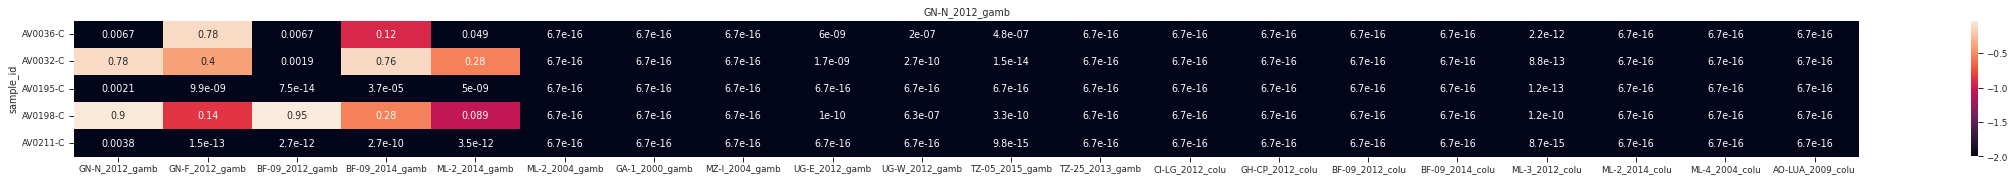

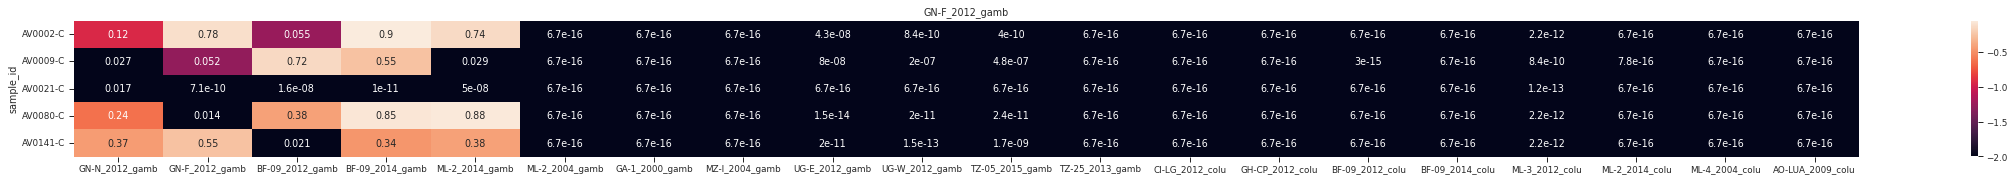

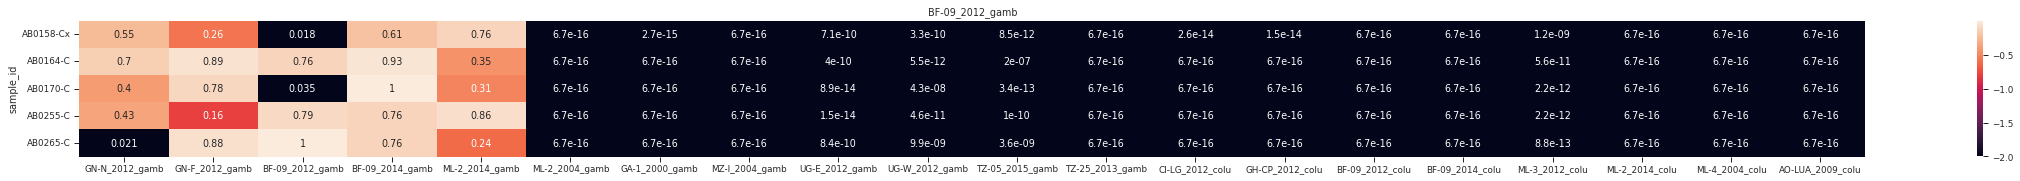

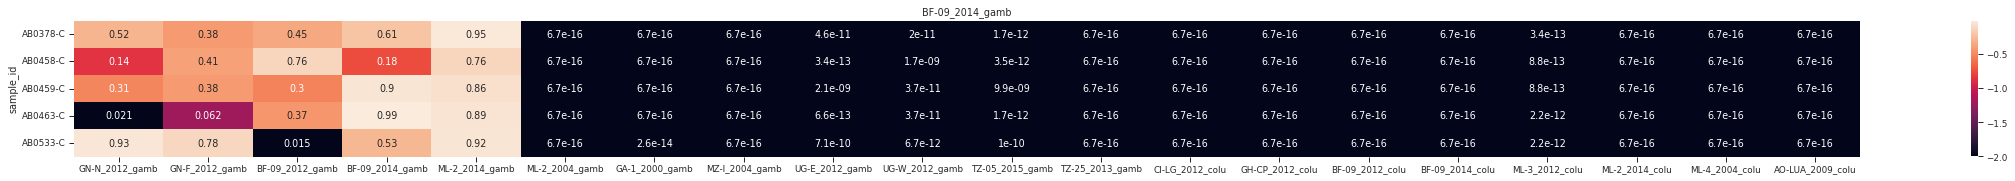

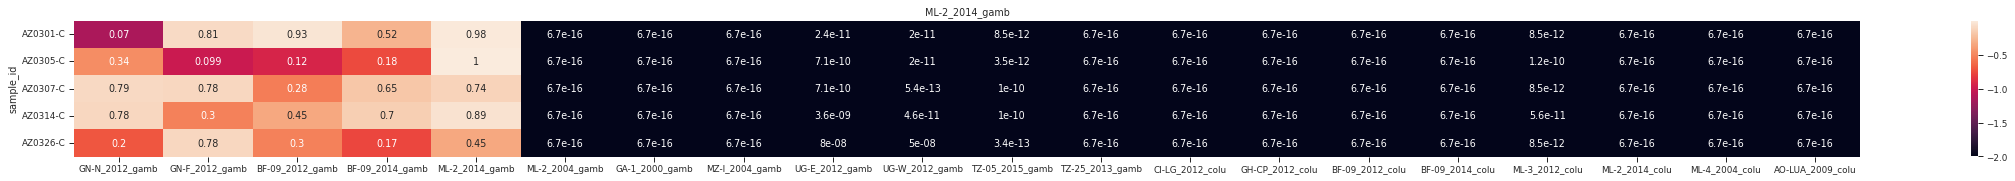

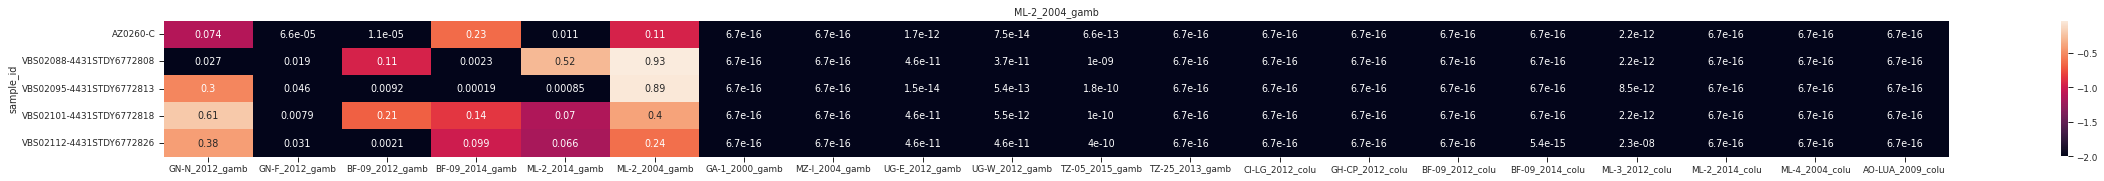

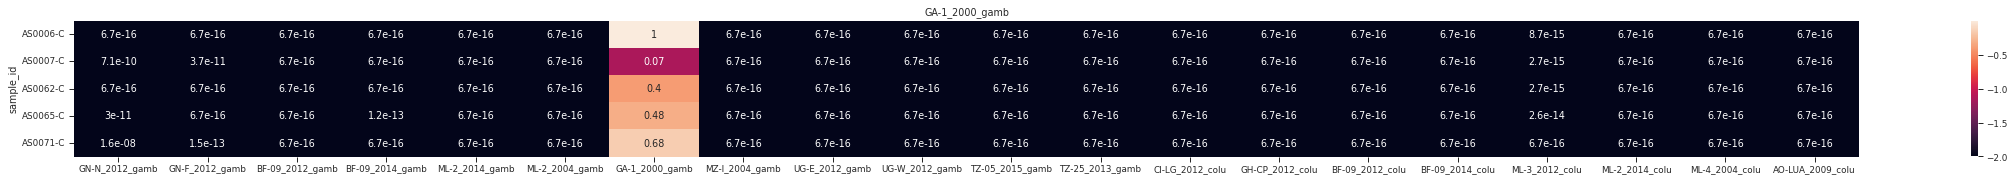

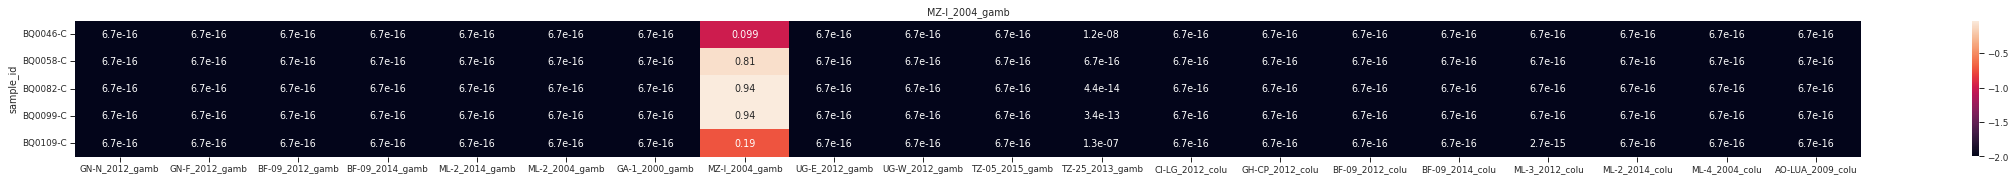

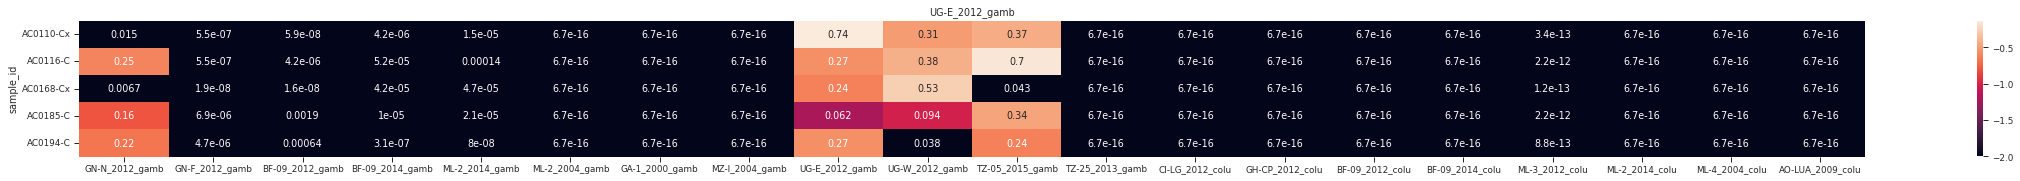

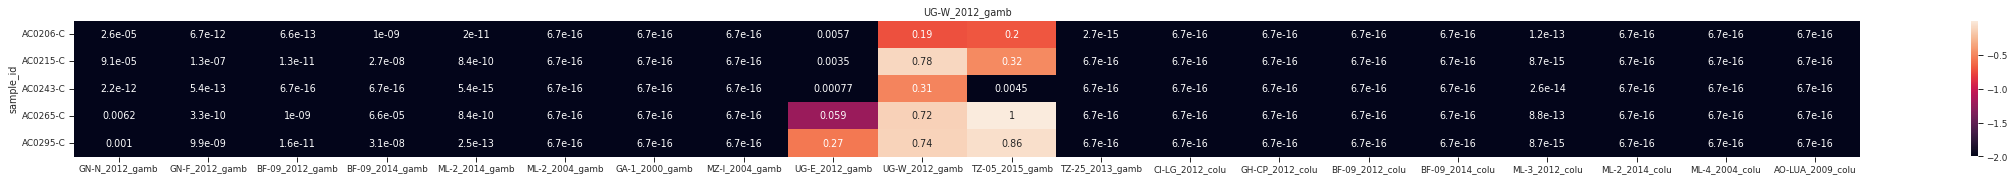

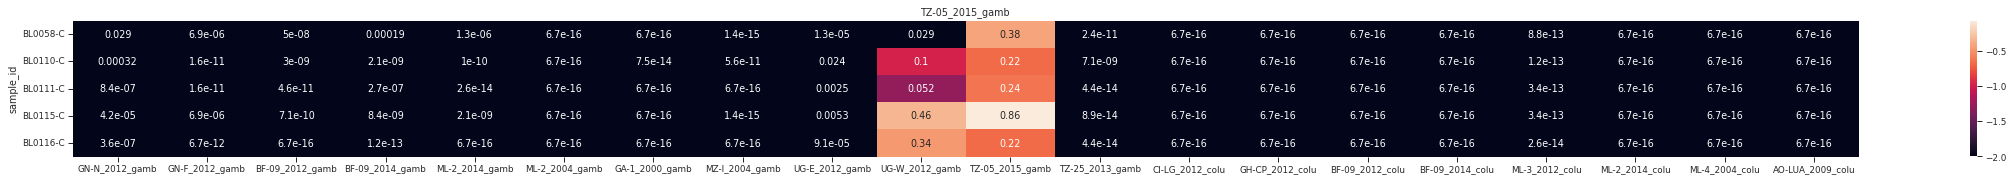

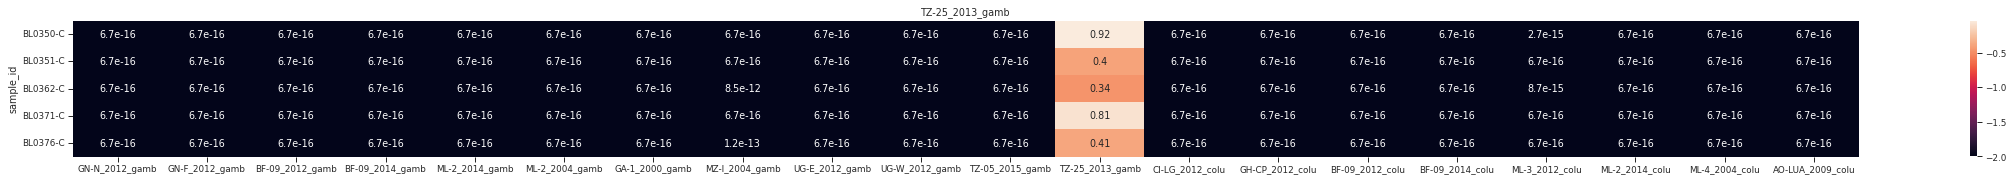

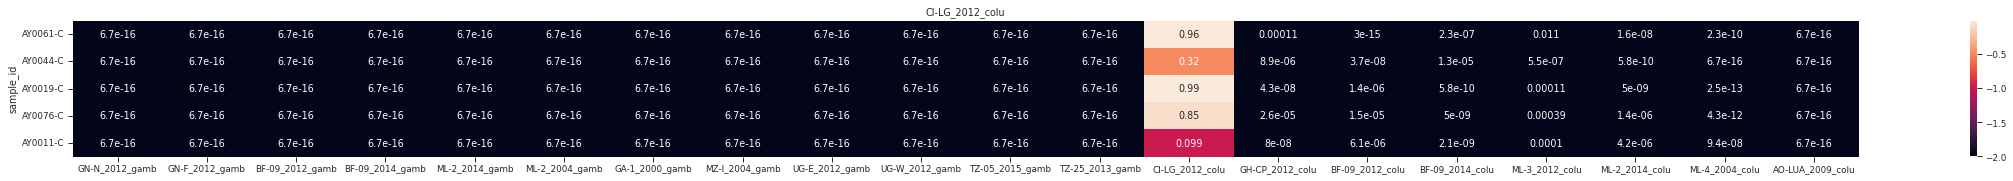

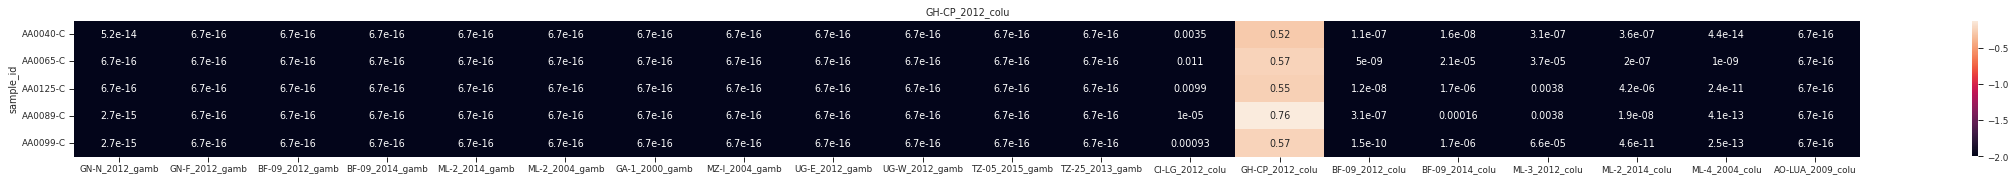

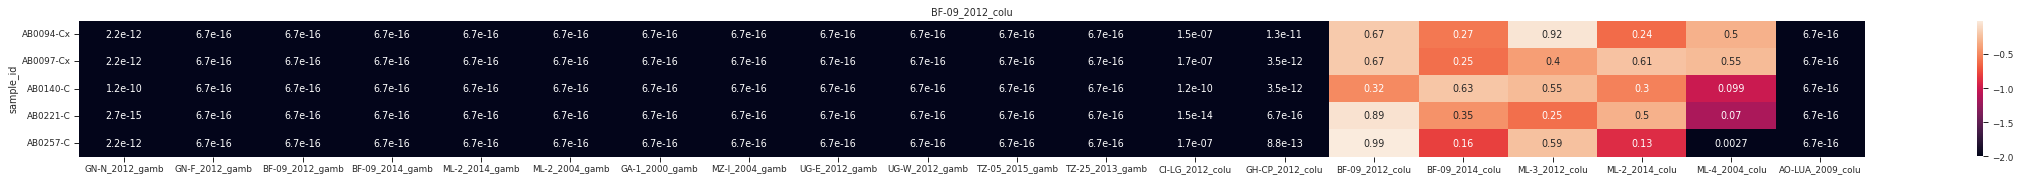

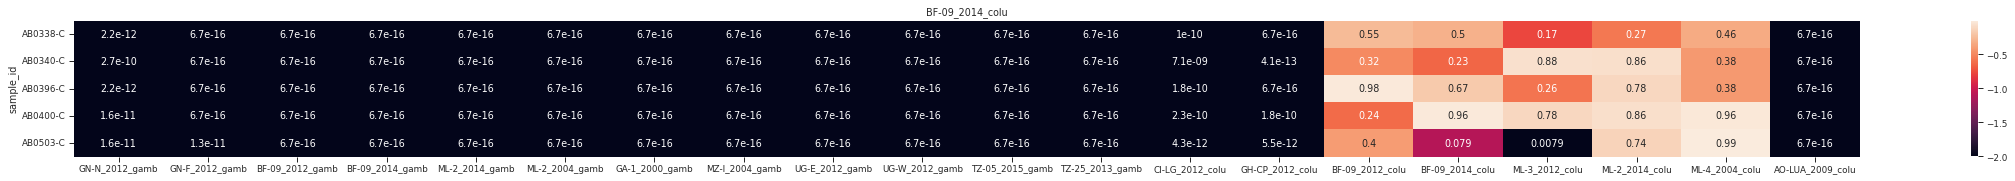

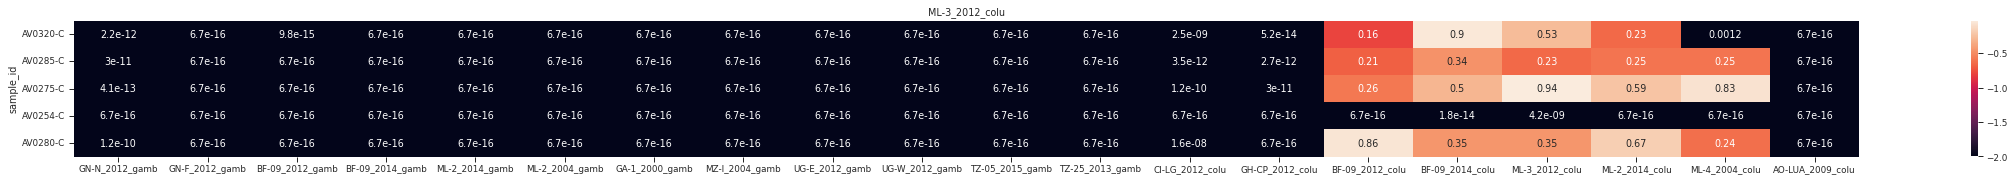

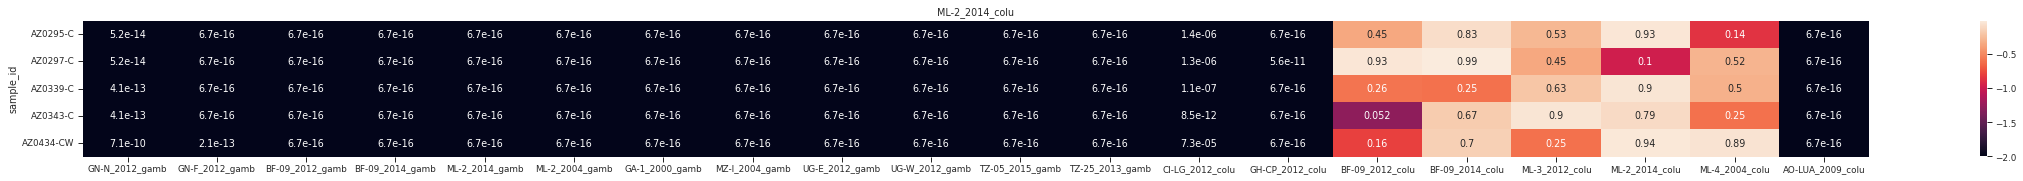

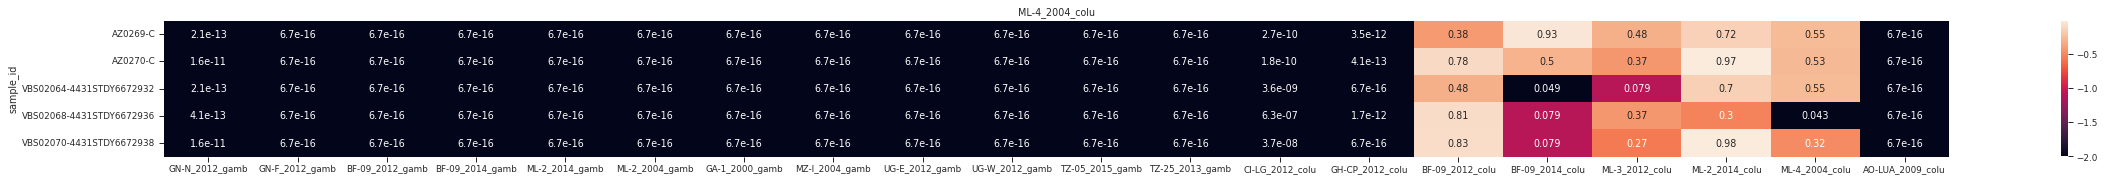

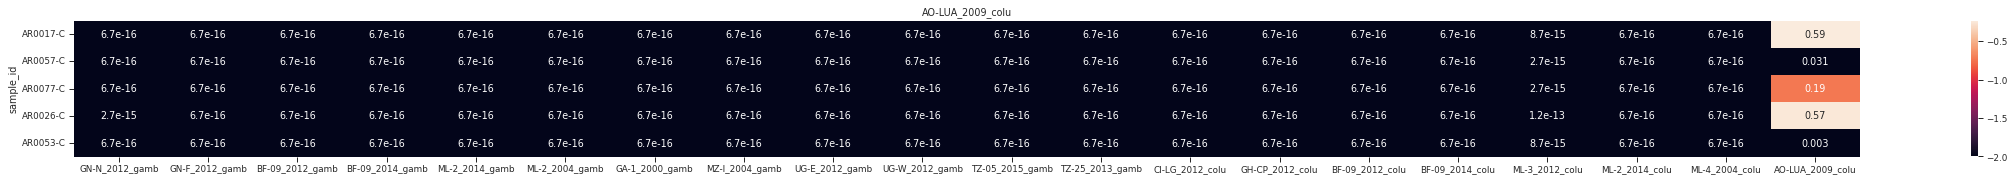

In [53]:
for pop in cohorts_red:
    heatmap_compare_short(pop, cohorts_red, cohorts_idx_query, cohorts_idx_ref, ssidx, pairwise_dbl);

In [54]:
pairwise_dbl_3R, loc_dbl_3R = count_pairwise_doubletons('3R', 'gamb_colu', gamb_ssidx, "v3")#count_pairwise_doubletons('3R', 'gamb_colu', ssidx, "v3")

load and subset genotypes
locate doubletons
load and subset genotypes
count hom alt genotypes
count alleles
filter for missingness
locate doubletons
compress genotypes to doubletons
Number of positions kept: 1135513
count pairwise shared doubletons


In [55]:
pairwise_dbl_3L, loc_dbl_3L = count_pairwise_doubletons('3L', 'gamb_colu', gamb_ssidx, "v3")#count_pairwise_doubletons('3L', 'gamb_colu', ssidx, "v3")

load and subset genotypes
locate doubletons
load and subset genotypes
count hom alt genotypes
count alleles
filter for missingness
locate doubletons
compress genotypes to doubletons
Number of positions kept: 832650
count pairwise shared doubletons


In [56]:
pairwise_dbl = pairwise_dbl_3L + pairwise_dbl_3R

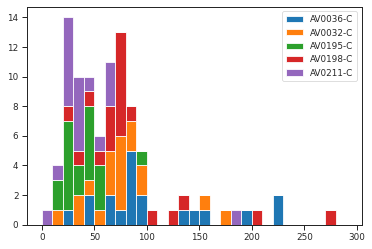

In [57]:
hist_comparison_plot('GN-N_2012_gamb','GN-N_2012_gamb',gamb_ssidx)

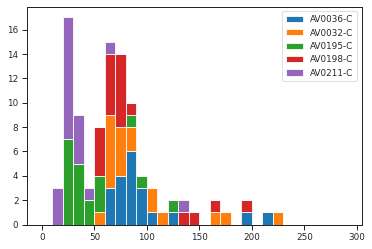

In [58]:
hist_comparison_plot('ML-2_2014_gamb','GN-N_2012_gamb',gamb_ssidx)

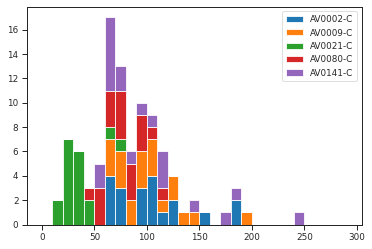

In [59]:
hist_comparison_plot('GN-F_2012_gamb','GN-F_2012_gamb',gamb_ssidx)

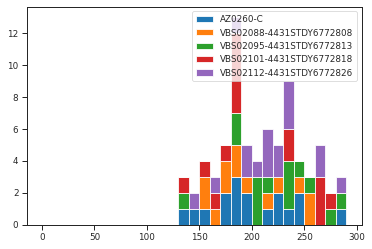

In [60]:
hist_comparison_plot('ML-2_2004_gamb','ML-2_2004_gamb',gamb_ssidx)

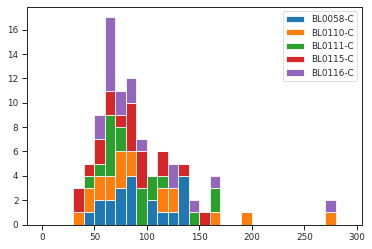

In [61]:
hist_comparison_plot('TZ-05_2015_gamb','TZ-05_2015_gamb',gamb_ssidx)

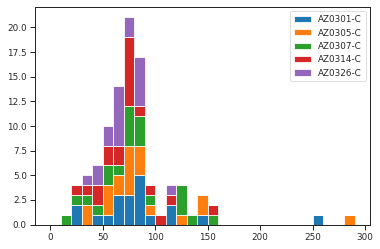

In [62]:
hist_comparison_plot('GN-N_2012_gamb','ML-2_2014_gamb',gamb_ssidx)

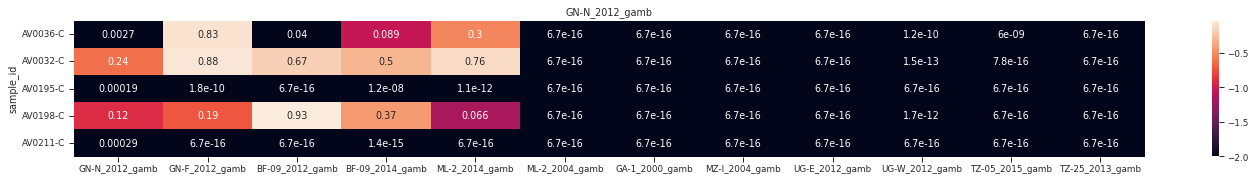

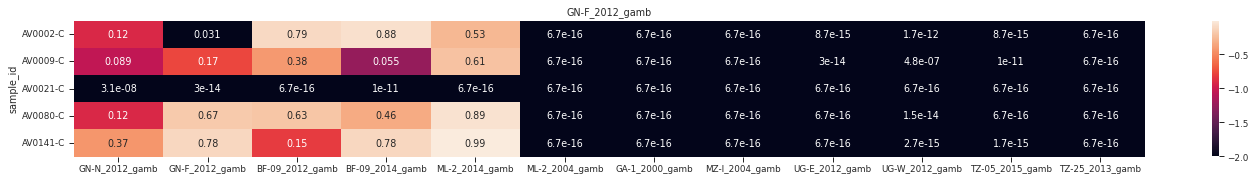

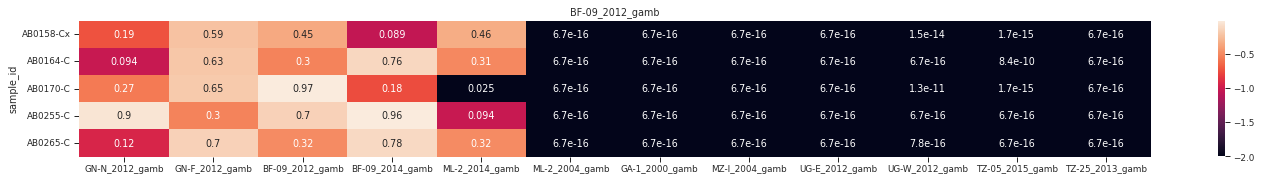

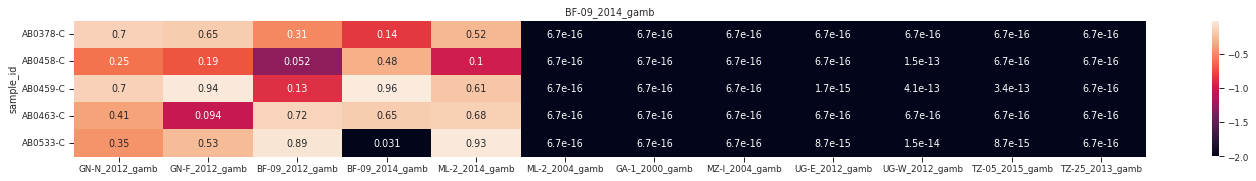

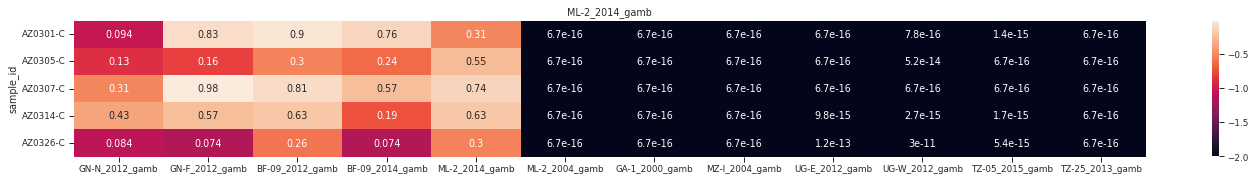

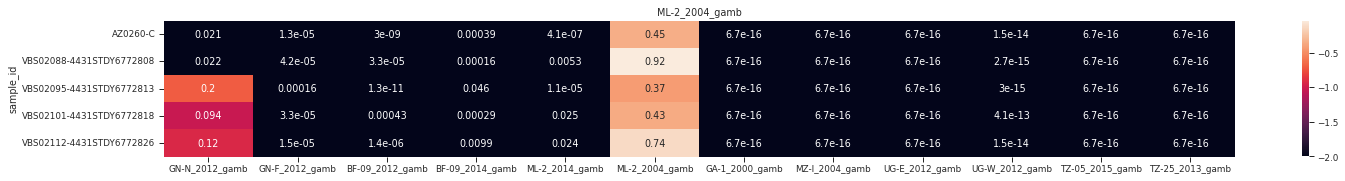

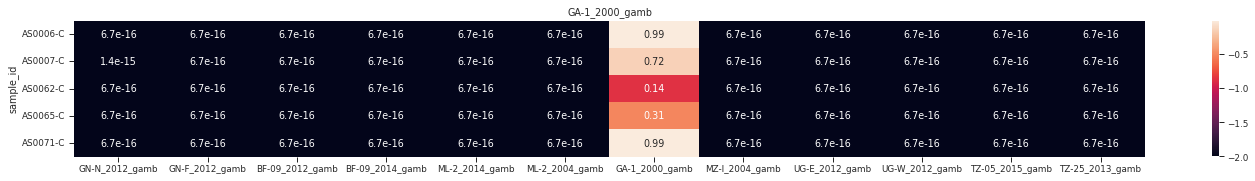

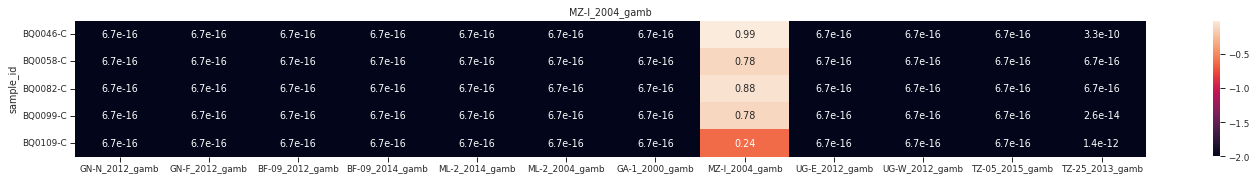

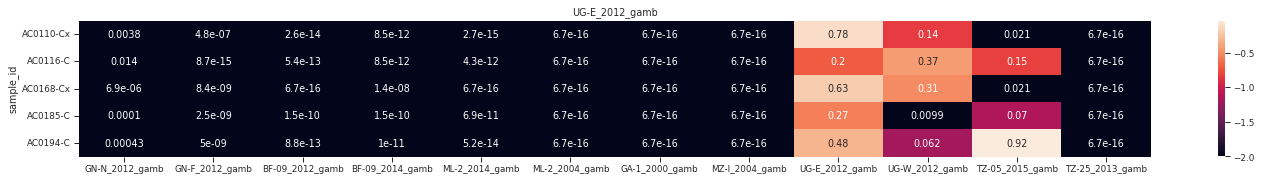

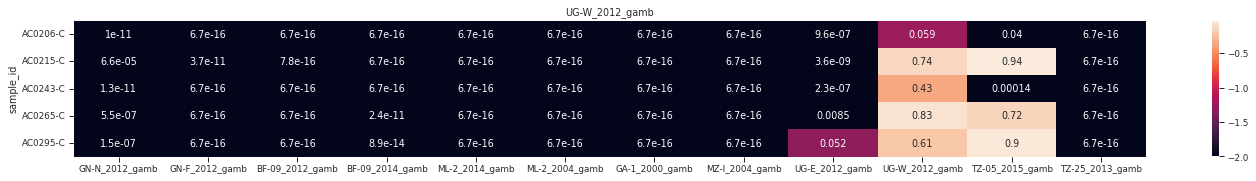

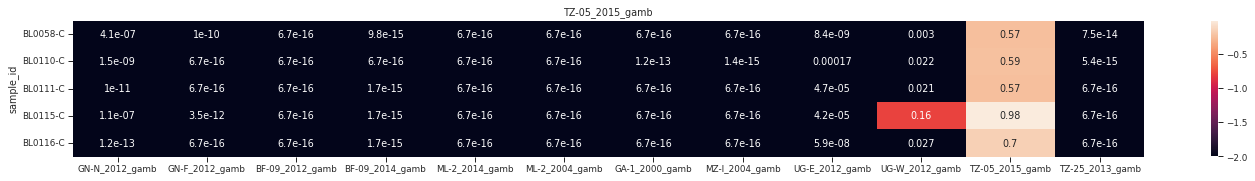

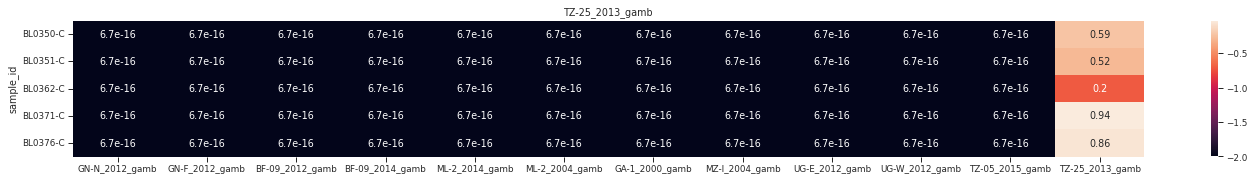

In [63]:
for pop in gamb_cohorts:
    heatmap_compare_short(pop, gamb_cohorts, cohorts_idx_query, cohorts_idx_ref, gamb_ssidx, pairwise_dbl);

In [61]:
pairwise_dbl_3R, loc_dbl_3R = count_pairwise_doubletons('3R', 'gamb_colu', colu_ssidx, "v3")

load and subset genotypes
locate doubletons
load and subset genotypes
count hom alt genotypes
count alleles
filter for missingness
locate doubletons
compress genotypes to doubletons
Number of positions kept: 989989
count pairwise shared doubletons


In [62]:
pairwise_dbl_3L, loc_dbl_3L = count_pairwise_doubletons('3L', 'gamb_colu', colu_ssidx, "v3")

load and subset genotypes
locate doubletons
load and subset genotypes
count hom alt genotypes
count alleles
filter for missingness
locate doubletons
compress genotypes to doubletons
Number of positions kept: 716128
count pairwise shared doubletons


In [63]:
pairwise_dbl = pairwise_dbl_3L + pairwise_dbl_3R

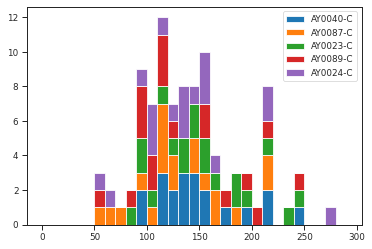

In [64]:
hist_comparison_plot('CI-LG_2012_colu','CI-LG_2012_colu',colu_ssidx)

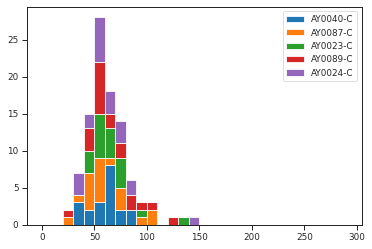

In [65]:
hist_comparison_plot('BF-09_2012_colu','CI-LG_2012_colu',colu_ssidx)

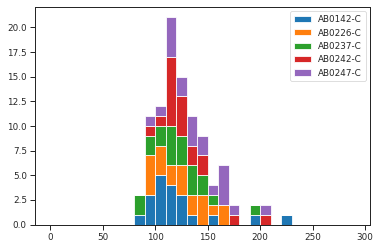

In [66]:
hist_comparison_plot('BF-09_2012_colu','BF-09_2012_colu',colu_ssidx)

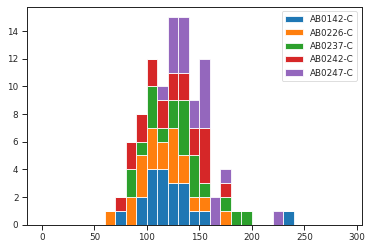

In [67]:
hist_comparison_plot('BF-09_2014_colu','BF-09_2012_colu',colu_ssidx)

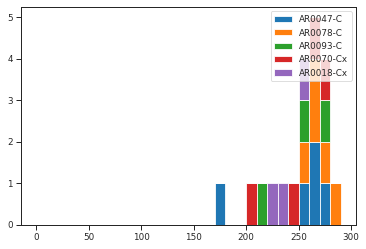

In [68]:
hist_comparison_plot('AO-LUA_2009_colu','AO-LUA_2009_colu',colu_ssidx)

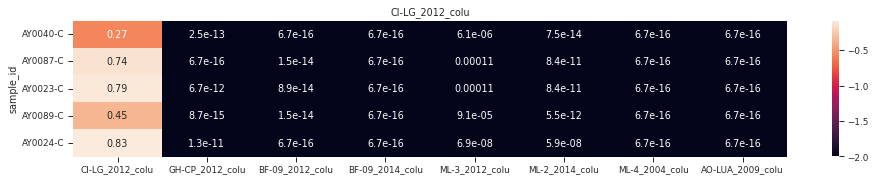

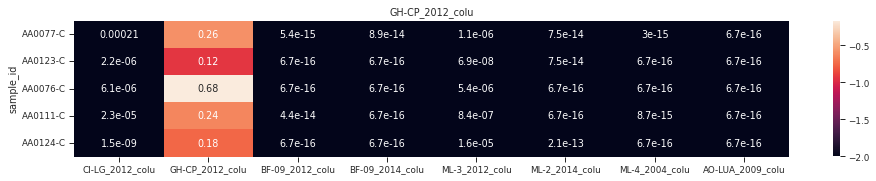

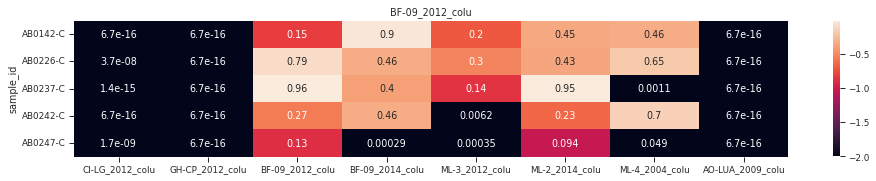

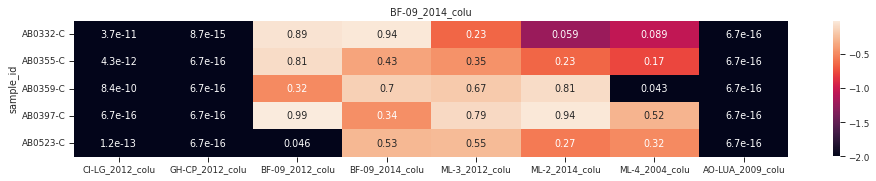

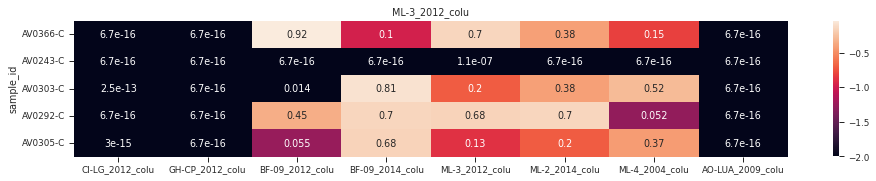

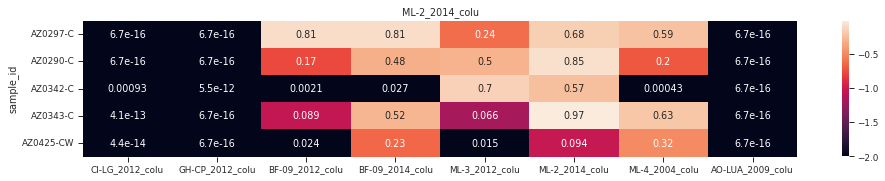

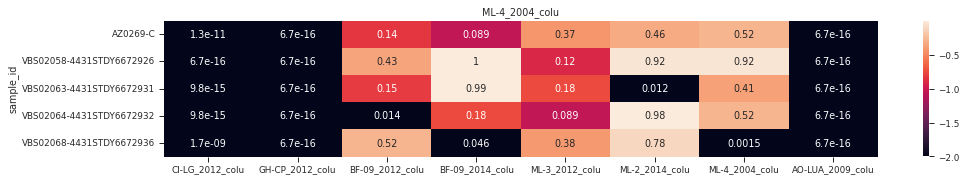

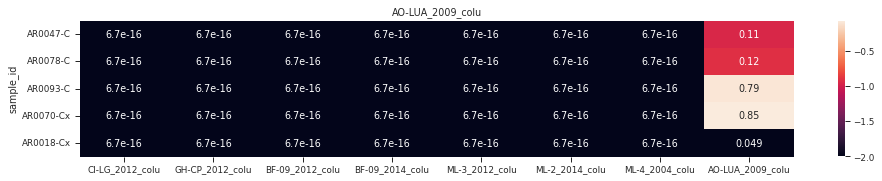

In [69]:
for pop in colu_cohorts:
    heatmap_compare_short(pop, colu_cohorts, colu_cohorts_idx_query, colu_cohorts_idx_ref, colu_ssidx, pairwise_dbl);

In [ ]:
df_samples_sub = pd.concat([ag3.sample_cohorts()[ag3.sample_cohorts().index.isin(gamb_cohorts_idx_ref_query[p])] for p in gamb_cohorts])#pd.concat([ag3.sample_cohorts()[ag3.sample_cohorts().index.isin(cohorts_idx_ref_query[p])] for p in cohorts_red])

In [ ]:
df_samples_sub.reset_index(drop=True, inplace=True)
df_samples_sub

In [ ]:
cohorts_sub_idx_query = {pop: df_samples_sub[df_samples_sub.sample_id.isin(list(ag3.sample_cohorts()[ag3.sample_cohorts().index.isin(gamb_cohorts_idx_query[pop])].sample_id))].index for pop in gamb_cohorts}#{pop: df_samples_sub[df_samples_sub.sample_id.isin(list(ag3.sample_cohorts()[ag3.sample_cohorts().index.isin(cohorts_idx_query[pop])].sample_id))].index for pop in cohorts_red}
cohorts_sub_idx_ref = {pop: df_samples_sub[df_samples_sub.sample_id.isin(list(ag3.sample_cohorts()[ag3.sample_cohorts().index.isin(gamb_cohorts_idx_ref[pop])].sample_id))].index for pop in gamb_cohorts}#{pop: df_samples_sub[df_samples_sub.sample_id.isin(list(ag3.sample_cohorts()[ag3.sample_cohorts().index.isin(cohorts_idx_ref[pop])].sample_id))].index for pop in cohorts_red}
cohorts_sub_idx_ref_query = {pop: df_samples_sub[df_samples_sub.sample_id.isin(list(ag3.sample_cohorts()[ag3.sample_cohorts().index.isin(gamb_cohorts_idx_ref_query[pop])].sample_id))].index for pop in gamb_cohorts}#{pop: df_samples_sub[df_samples_sub.sample_id.isin(list(ag3.sample_cohorts()[ag3.sample_cohorts().index.isin(cohorts_idx_ref_query[pop])].sample_id))].index for pop in cohorts_red}

In [ ]:
score_q, p_val_q = estimate_cohort_assignment_precision('query')
score_r, p_val_r = estimate_cohort_assignment_precision('ref')
score_a, p_val_a = estimate_cohort_assignment_precision('all')

In [ ]:
best_match_q = np.zeros(score_q.shape)
best_match_r = np.zeros(score_r.shape)
best_match_a = np.zeros(score_a.shape)

In [ ]:
for j in range(0,p_val_q.shape[1]):
    for i in range(0,p_val_q.shape[0]):
        best_match_q[i,j] = (p_val_q[i,j] == max(p_val_q[i]))
for j in range(0,p_val_r.shape[1]):
    for i in range(0,p_val_r.shape[0]):
        best_match_r[i,j] = (p_val_r[i,j] == max(p_val_r[i]))
for j in range(0,p_val_a.shape[1]):
    for i in range(0,p_val_a.shape[0]):
        best_match_a[i,j] = (p_val_a[i,j] == max(p_val_a[i]))

In [ ]:
class_score_best_q = np.zeros((len(cohorts_red), len(cohorts_red)))
class_score_best_r = np.zeros((len(cohorts_red), len(cohorts_red)))
class_score_best_a = np.zeros((len(cohorts_red), len(cohorts_red)))

for i in range(0,len(cohorts_red)):
    for j in range(0,len(cohorts_red)):
        class_score_best_q[i,j] = np.nansum(best_match_q[i*n_query:(i+1)*n_query][:,j])/n_query
        class_score_best_r[i,j] = np.nansum(best_match_r[i*n_ref:(i+1)*n_ref][:,j])/n_ref
        class_score_best_a[i,j] = np.nansum(best_match_a[i*(n_query+n_ref):(i+1)*(n_query+n_ref)][:,j])/(n_query+n_ref)

In [ ]:
class_score_best_a[1]

In [ ]:
sns.heatmap(pd.DataFrame(data=class_score_best_q, index = cohorts_red, columns=cohorts_red))

In [ ]:
sns.heatmap(pd.DataFrame(data=class_score_best_r, index = cohorts_red, columns=cohorts_red))

In [ ]:
sns.heatmap(pd.DataFrame(data=class_score_best_a, index = cohorts_red, columns=cohorts_red))

In [ ]:
high_match_proba_q = p_val_q > .50
high_match_proba_r = p_val_r > .50
high_match_proba_a = p_val_a > .50

In [ ]:
class_score_proba_q = np.zeros((len(cohorts_red), len(cohorts_red)))
class_score_proba_r = np.zeros((len(cohorts_red), len(cohorts_red)))
class_score_proba_a = np.zeros((len(cohorts_red), len(cohorts_red)))

for i in range(0,len(cohorts_red)):
    den_q = np.sum(high_match_proba_q[i*n_query:(i+1)*n_query], axis = 1)
    den_r = np.sum(high_match_proba_r[i*n_ref:(i+1)*n_ref], axis = 1)
    den_a = np.sum(high_match_proba_a[i*(n_query+n_ref):(i+1)*(n_query+n_ref)], axis = 1)
    for j in range(0,len(cohorts_red)):
        class_score_proba_q[i,j] = np.nansum(high_match_proba_q[i*n_query:(i+1)*n_query][:,j] / den_q)/n_query
        class_score_proba_r[i,j] = np.nansum(high_match_proba_r[i*n_ref:(i+1)*n_ref][:,j] / den_r)/n_ref
        class_score_proba_a[i,j] = np.nansum(high_match_proba_a[i*(n_query+n_ref):(i+1)*(n_query+n_ref)][:,j] / den_a)/(n_query+n_ref)

In [ ]:
sns.heatmap(pd.DataFrame(data=class_score_proba_q, index = cohorts_red, columns=cohorts_red))

In [ ]:
sns.heatmap(pd.DataFrame(data=class_score_proba_r, index = cohorts_red, columns=cohorts_red))

In [ ]:
sns.heatmap(pd.DataFrame(data=class_score_proba_a, index = cohorts_red, columns=cohorts_red))

In [ ]:
p_val_adj_q = np.zeros((n_query*len(cohorts_red), len(cohorts_red)))
p_val_adj_r = np.zeros((n_ref*len(cohorts_red), len(cohorts_red)))
p_val_adj_a = np.zeros(((n_query+n_ref)*len(cohorts_red), len(cohorts_red)))

class_score_proba_adj_q = np.zeros((len(cohorts_red), len(cohorts_red)))
class_score_proba_adj_r = np.zeros((len(cohorts_red), len(cohorts_red)))
class_score_proba_adj_a = np.zeros((len(cohorts_red), len(cohorts_red)))

for k in range(0,p_val_q.shape[0]):
    p_val_adj_q[k] = p_val_q[k]/np.sum(p_val_q[k])
for k in range(0,p_val_r.shape[0]):
    p_val_adj_r[k] = p_val_r[k]/np.sum(p_val_r[k])
for k in range(0,p_val_a.shape[0]):
    p_val_adj_a[k] = p_val_a[k]/np.sum(p_val_a[k])

for i in range(0,len(cohorts_red)):
    for j in range(0,len(cohorts_red)):
        class_score_proba_adj_q[i,j] = np.nansum(p_val_adj_q[i*n_query:(i+1)*n_query][:,j])/n_query
        class_score_proba_adj_r[i,j] = np.nansum(p_val_adj_r[i*n_ref:(i+1)*n_ref][:,j])/n_ref
        class_score_proba_adj_a[i,j] = np.nansum(p_val_adj_a[i*(n_query+n_ref):(i+1)*(n_query+n_ref)][:,j])/(n_query+n_ref)

In [ ]:
p_val_adj_r

In [ ]:
np.sum(class_score_proba_adj_q, axis = 1)

In [ ]:
sns.heatmap(pd.DataFrame(data=class_score_proba_adj_q, index = cohorts_red, columns=cohorts_red))

In [ ]:
sns.heatmap(pd.DataFrame(data=class_score_proba_adj_r, index = cohorts_red, columns=cohorts_red))

In [ ]:
sns.heatmap(pd.DataFrame(data=class_score_proba_adj_a, index = cohorts_red, columns=cohorts_red))

In [ ]:
pairwise_dbl_3R, loc_dbl_3R = count_pairwise_doubletons('3R', 'gamb_colu', colu_ssidx, "v3")#count_pairwise_doubletons('3R', 'gamb_colu', ssidx, "v3")

In [ ]:
pairwise_dbl_3L, loc_dbl_3L = count_pairwise_doubletons('3L', 'gamb_colu', colu_ssidx, "v3")#count_pairwise_doubletons('3R', 'gamb_colu', ssidx, "v3")

In [ ]:
pairwise_dbl = pairwise_dbl_3L + pairwise_dbl_3R

In [ ]:
for pop in colu_cohorts:#cohorts_red:
    heatmap_compare_short(pop, colu_cohorts, colu_cohorts_idx_query, colu_cohorts_idx_ref, colu_ssidx, pairwise_dbl);

# Sample size effect?

In [50]:
n_query = 10

In [51]:
cohorts_idx_query = {pop: sorted(random.sample(cohorts_idx[pop], n_query)) for pop in gamb_cohorts}
cohorts_idx_not_query = {pop: list(set(cohorts_idx[pop]) - set(cohorts_idx_query[pop])) for pop in gamb_cohorts}

5
load and subset genotypes
locate doubletons
load and subset genotypes
count hom alt genotypes
count alleles
filter for missingness
locate doubletons
compress genotypes to doubletons
Number of positions kept: 1008519
count pairwise shared doubletons
load and subset genotypes
locate doubletons
load and subset genotypes
count hom alt genotypes
count alleles
filter for missingness
locate doubletons
compress genotypes to doubletons
Number of positions kept: 728543
count pairwise shared doubletons


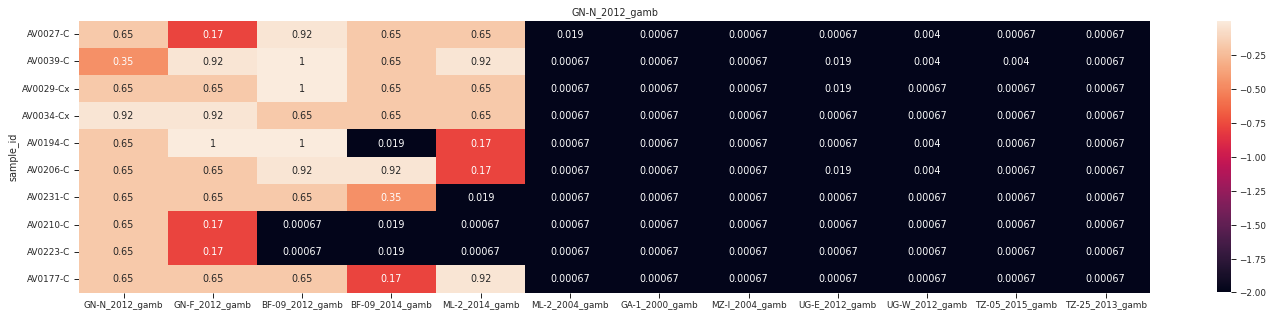

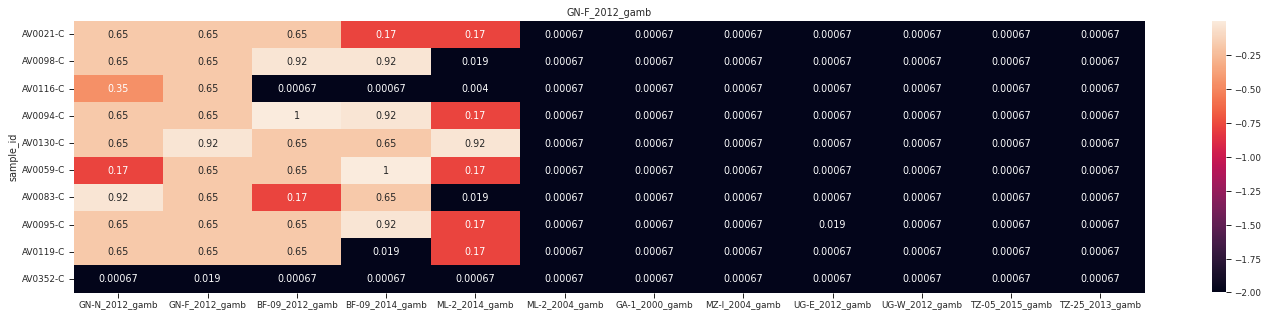

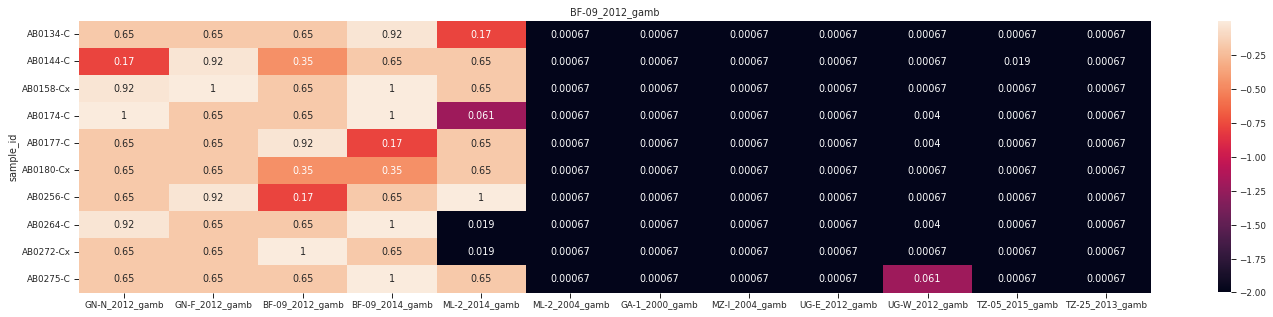

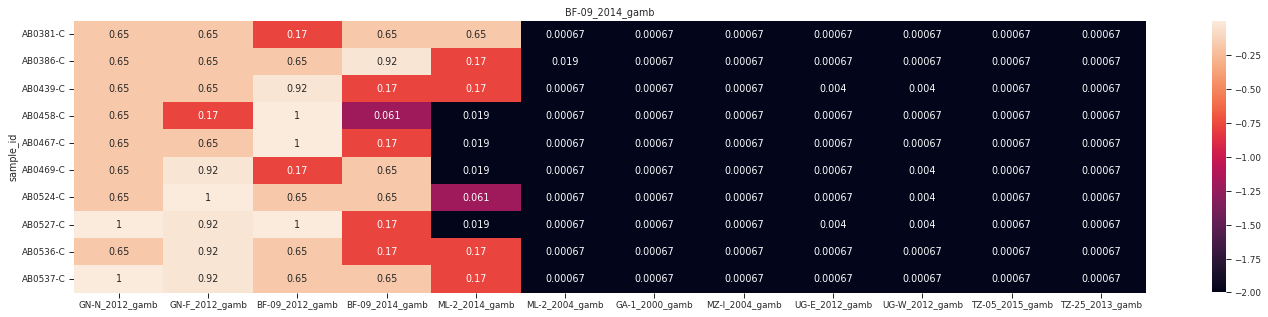

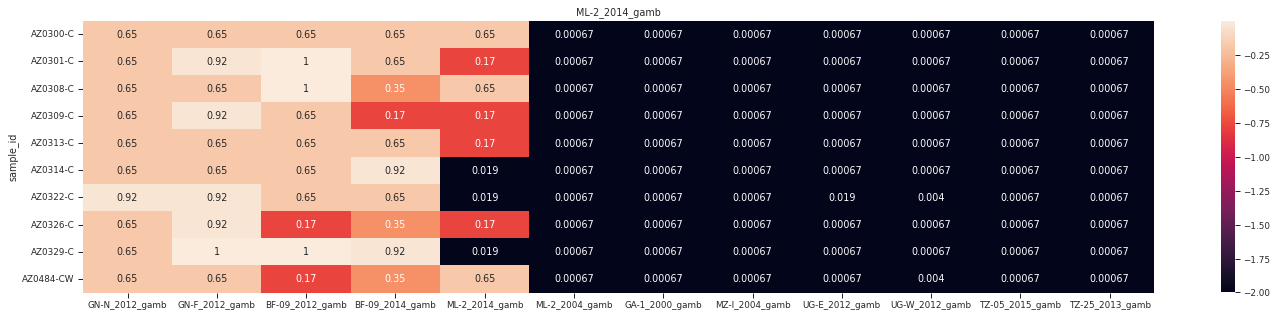

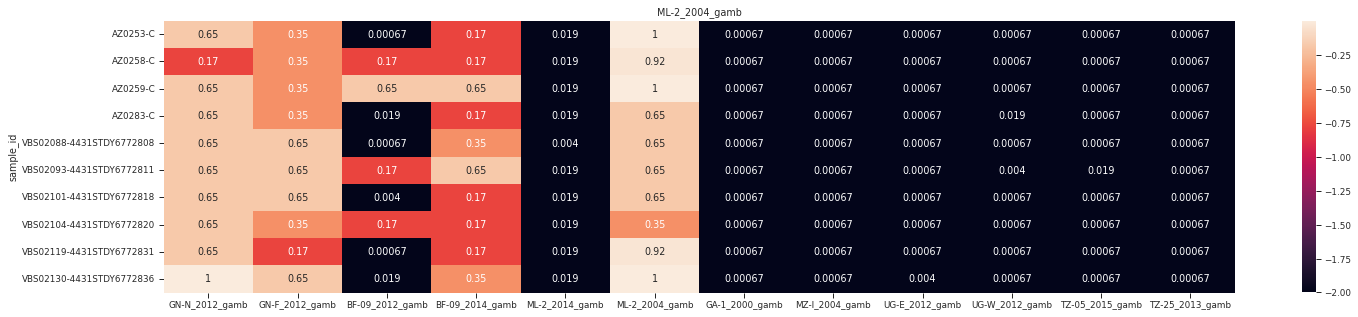

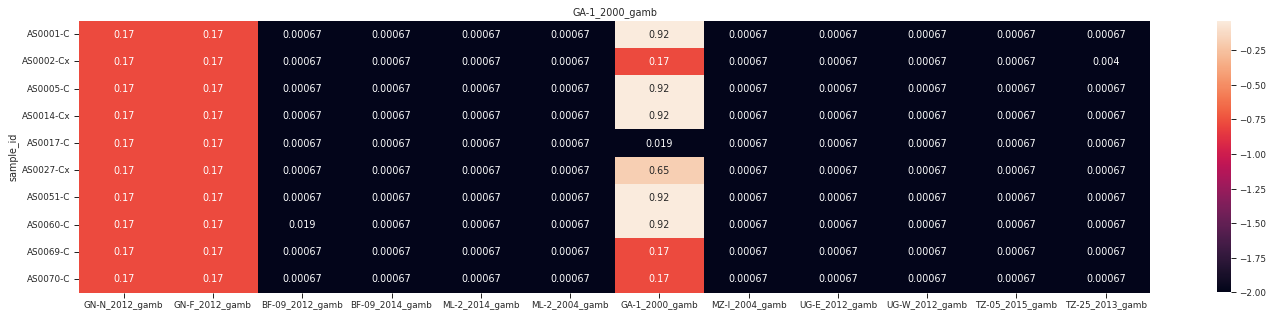

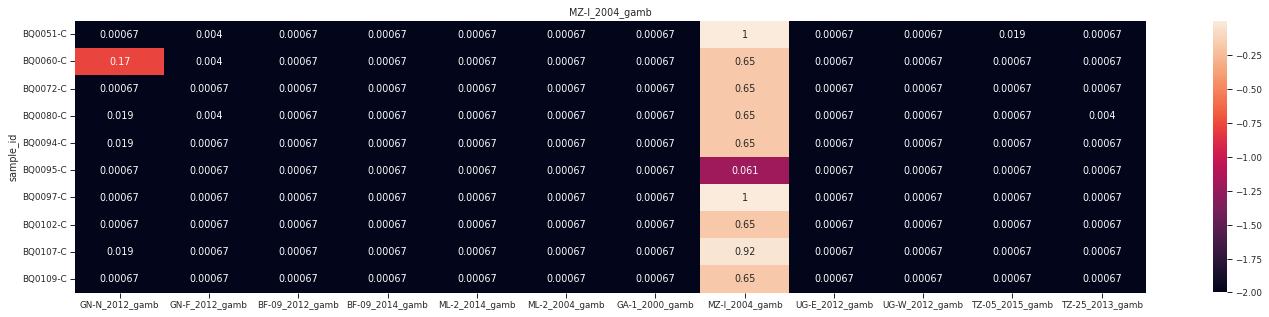

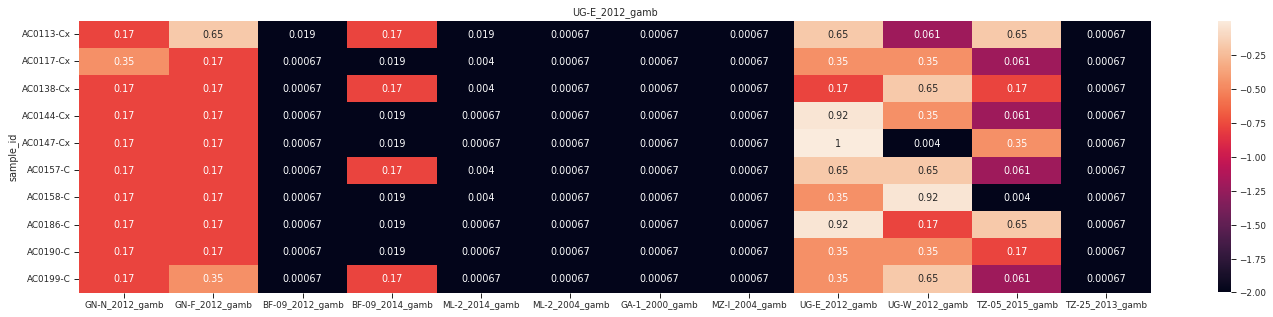

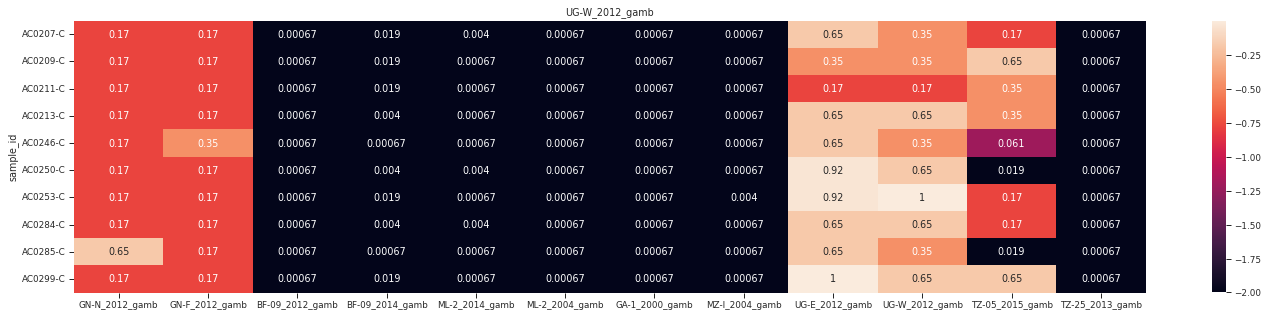

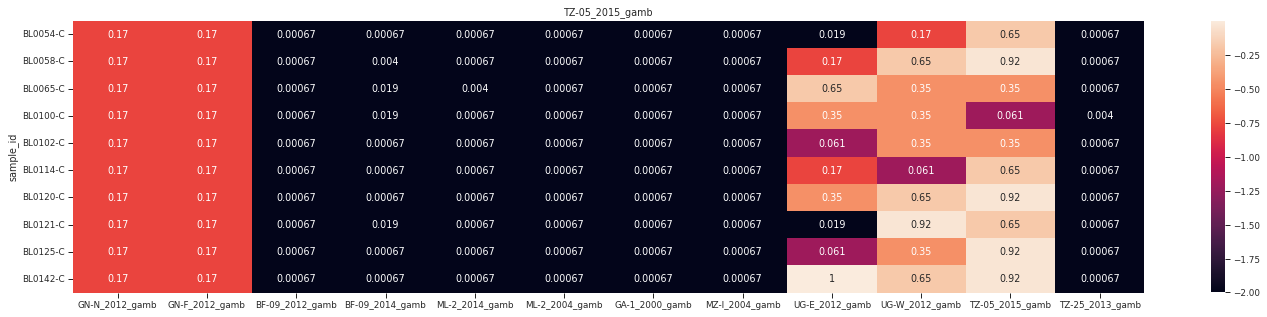

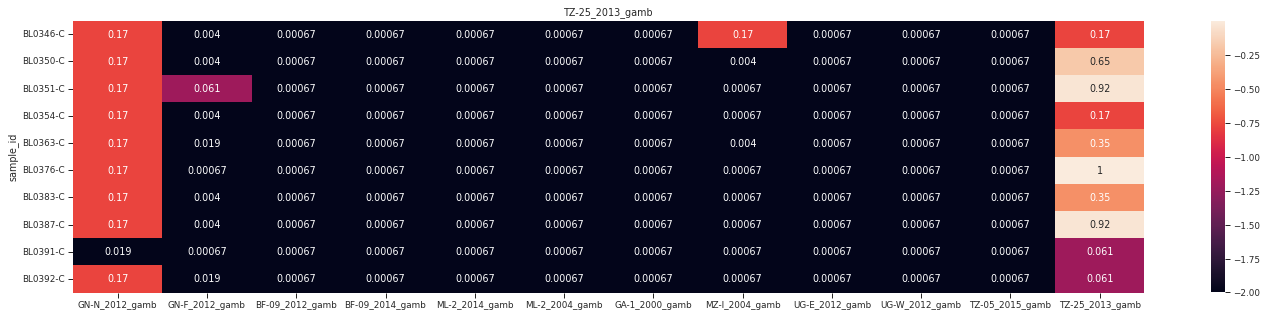

10
load and subset genotypes
locate doubletons
load and subset genotypes
count hom alt genotypes
count alleles
filter for missingness
locate doubletons
compress genotypes to doubletons
Number of positions kept: 1075233
count pairwise shared doubletons
load and subset genotypes
locate doubletons
load and subset genotypes
count hom alt genotypes
count alleles
filter for missingness
locate doubletons
compress genotypes to doubletons
Number of positions kept: 788823
count pairwise shared doubletons


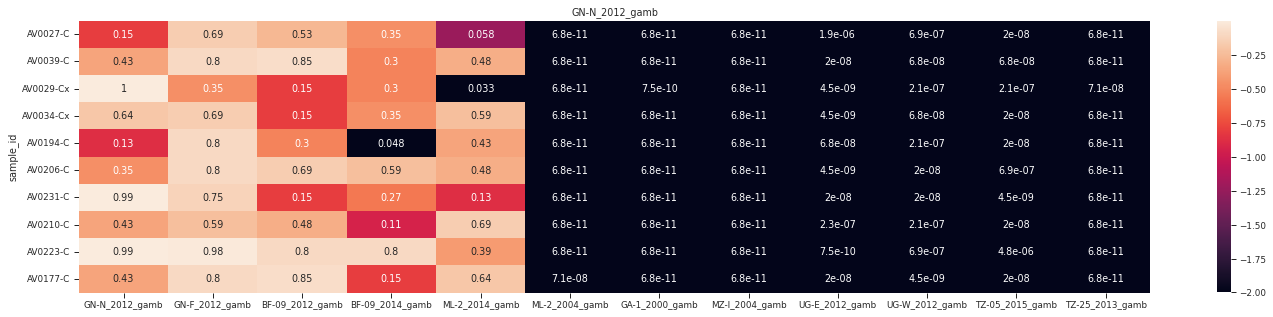

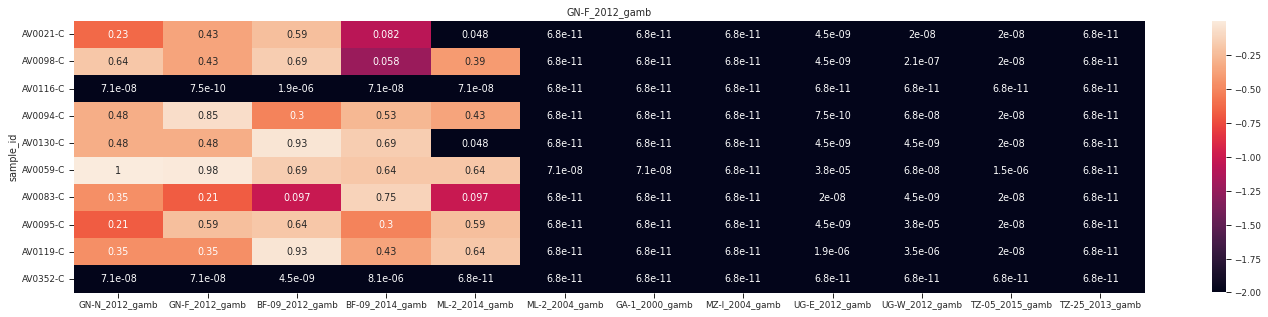

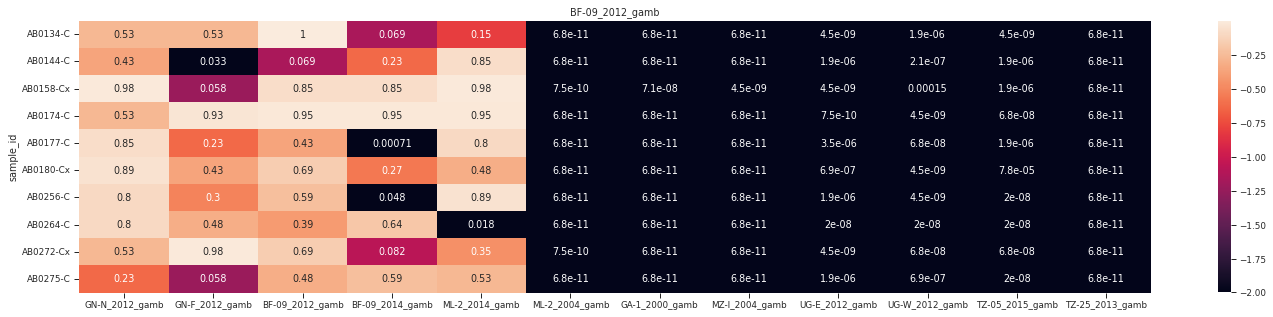

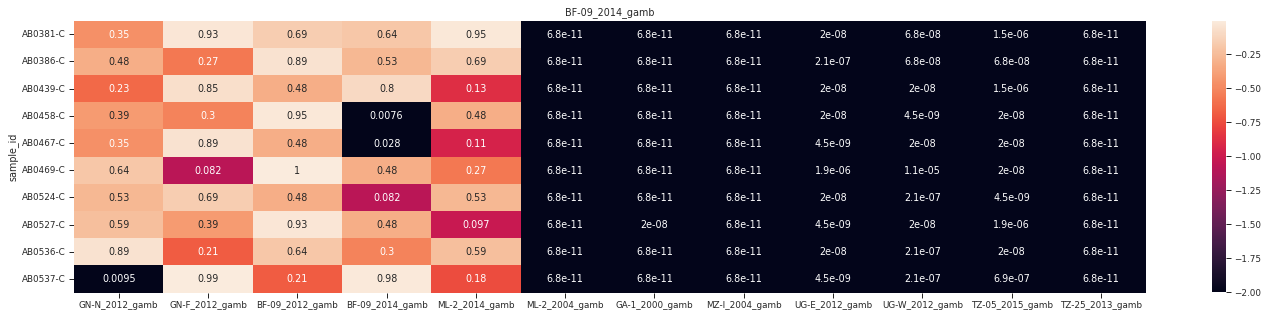

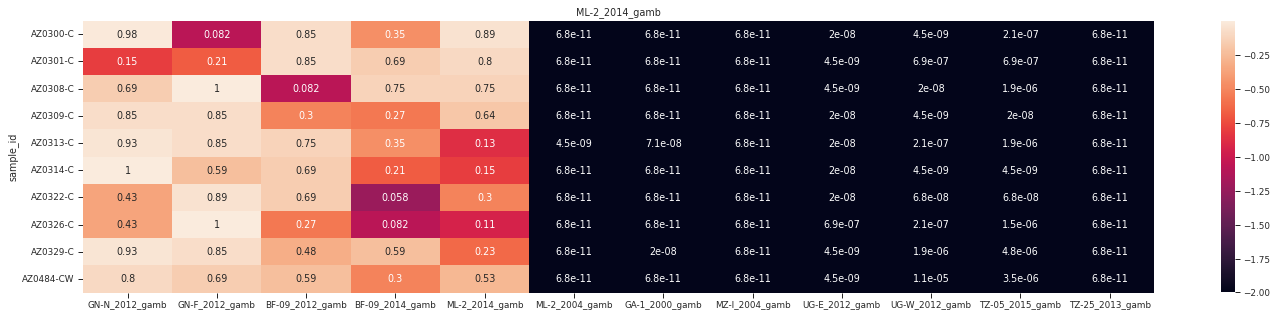

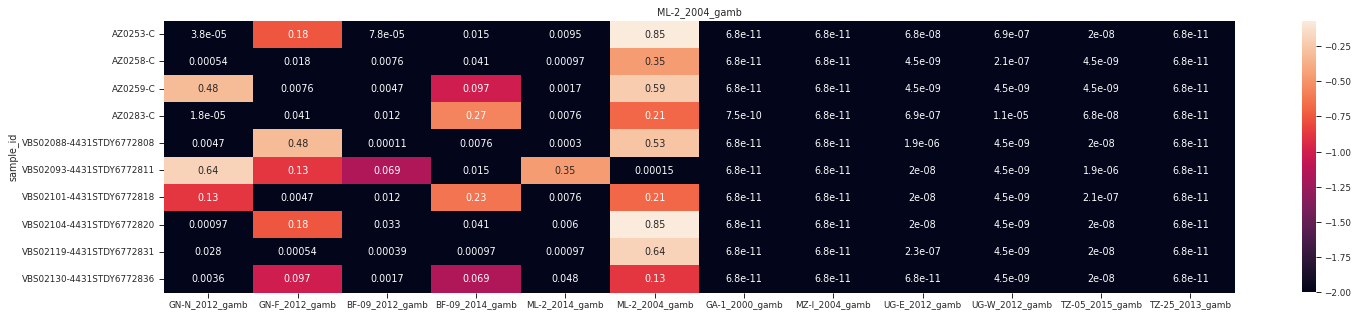

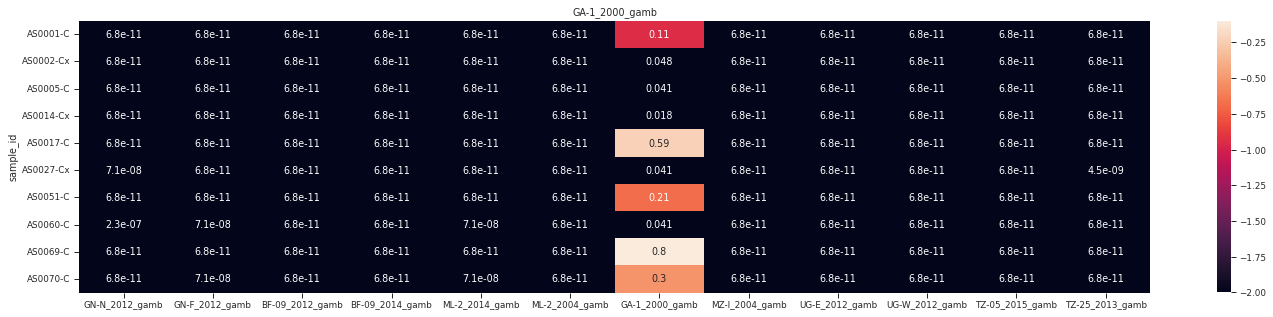

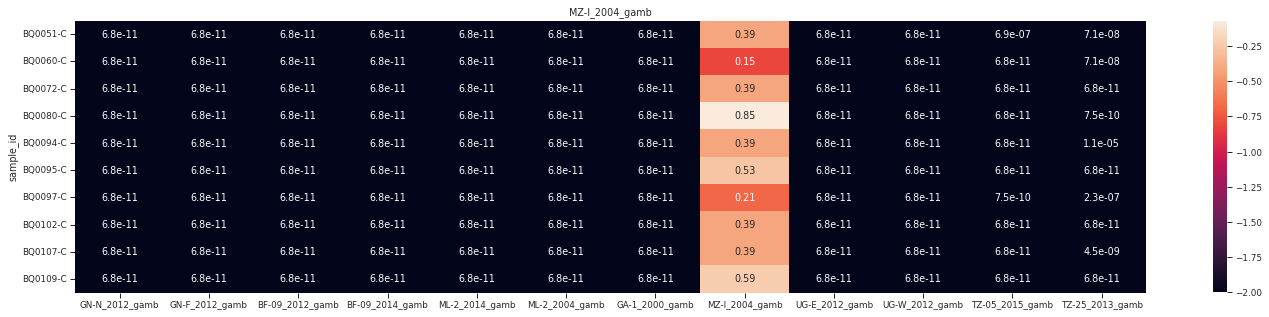

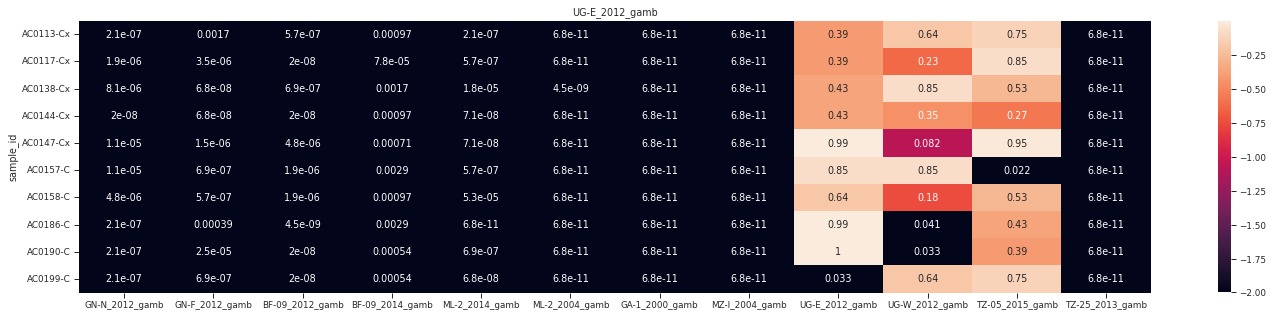

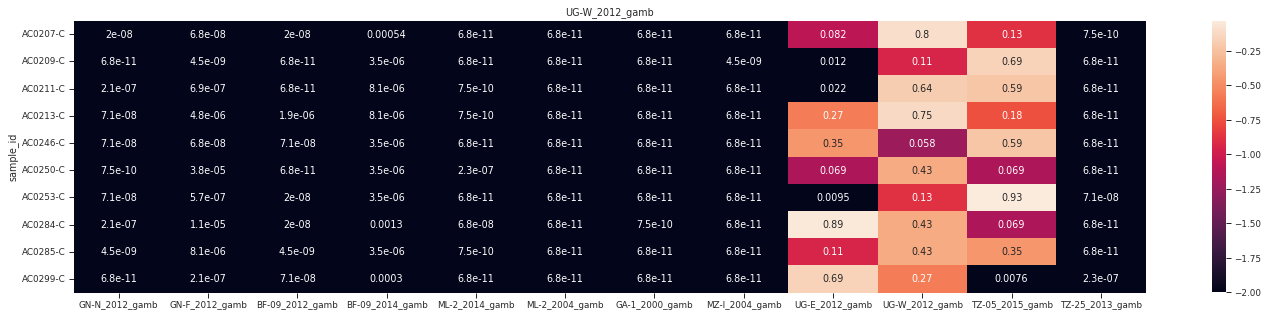

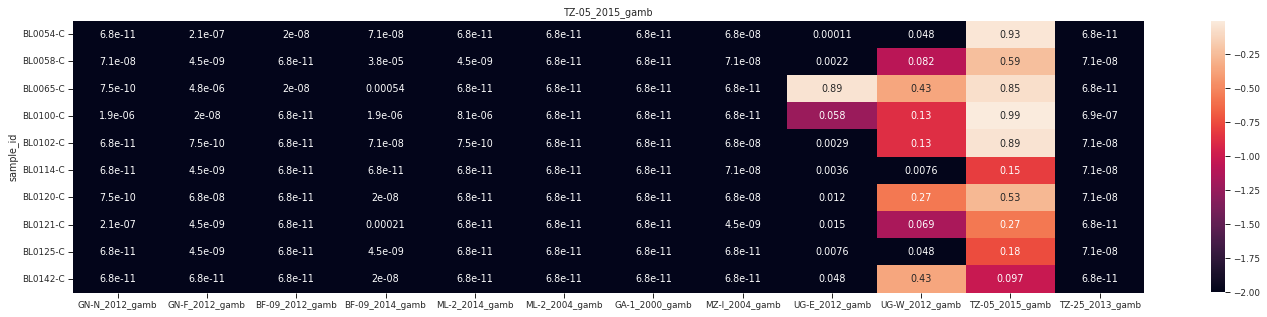

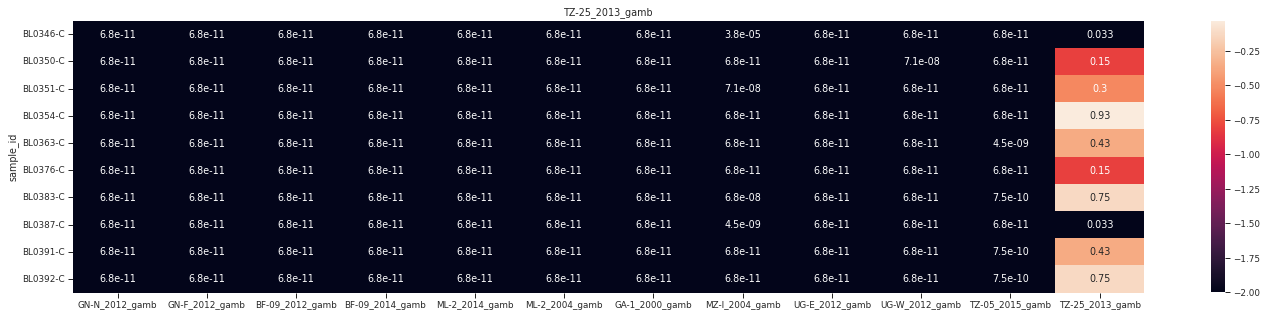

15
load and subset genotypes
locate doubletons
load and subset genotypes
count hom alt genotypes
count alleles
filter for missingness
locate doubletons
compress genotypes to doubletons
Number of positions kept: 1125657
count pairwise shared doubletons
load and subset genotypes
locate doubletons
load and subset genotypes
count hom alt genotypes
count alleles
filter for missingness
locate doubletons
compress genotypes to doubletons
Number of positions kept: 839616
count pairwise shared doubletons


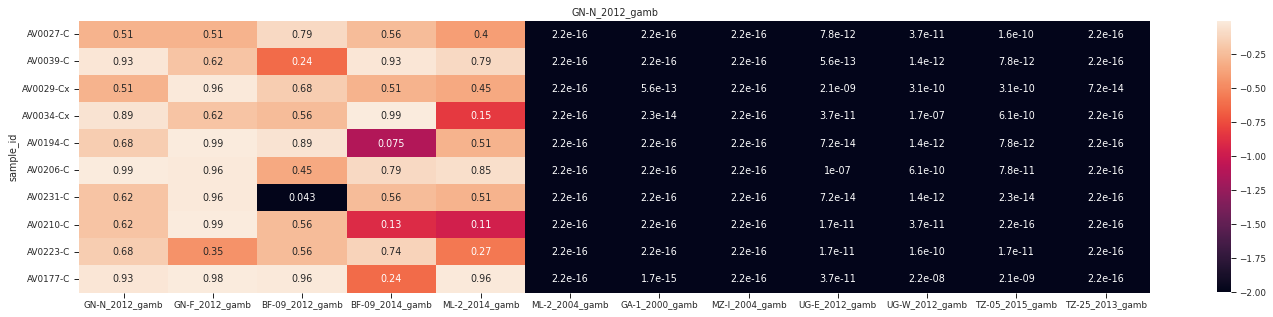

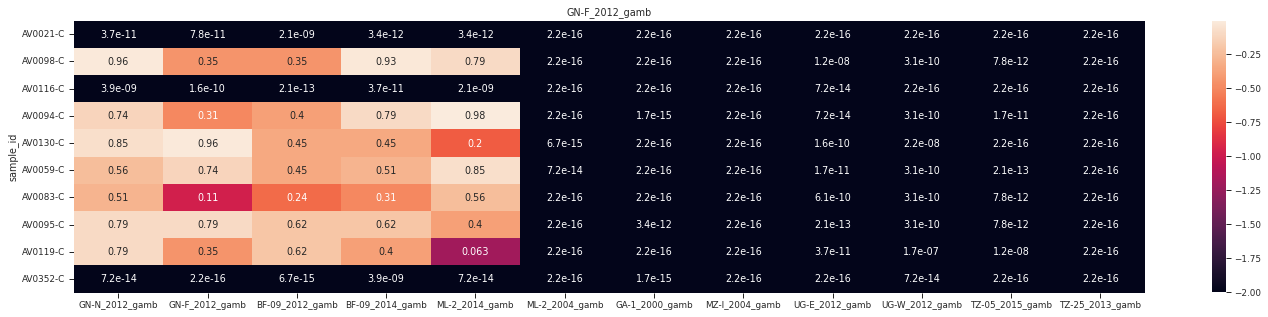

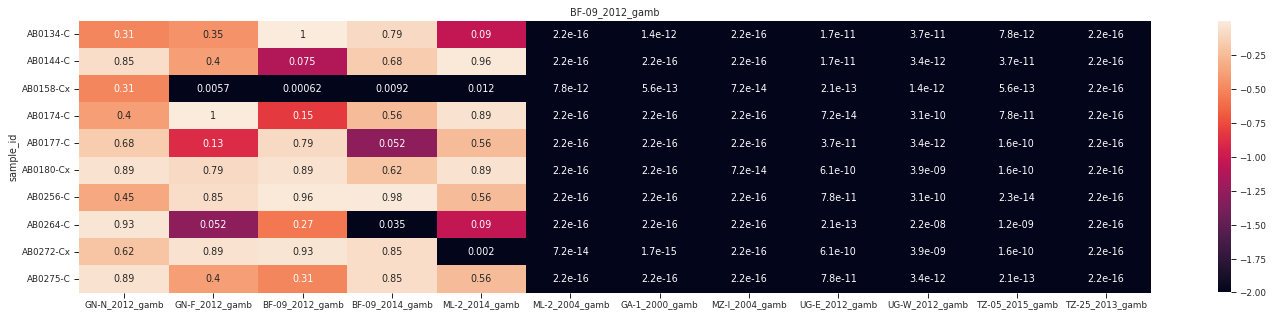

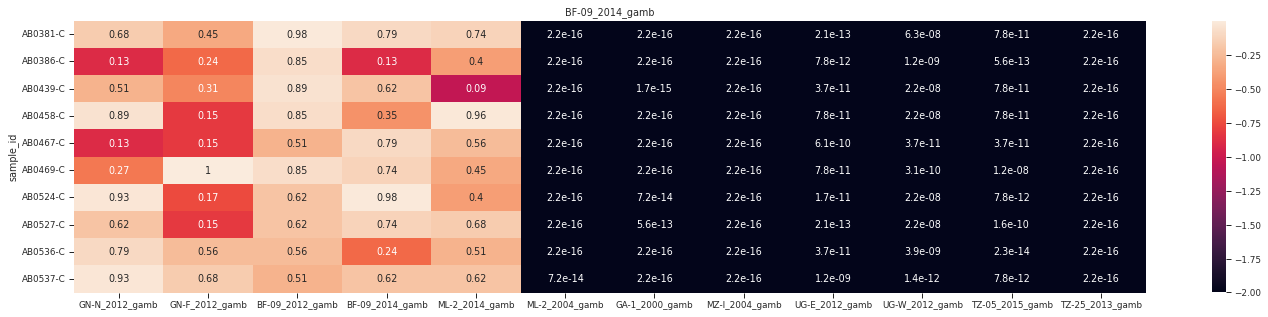

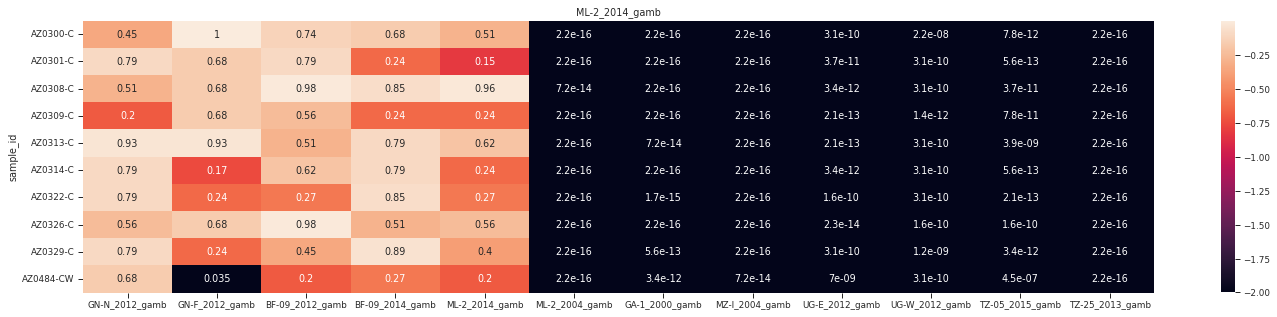

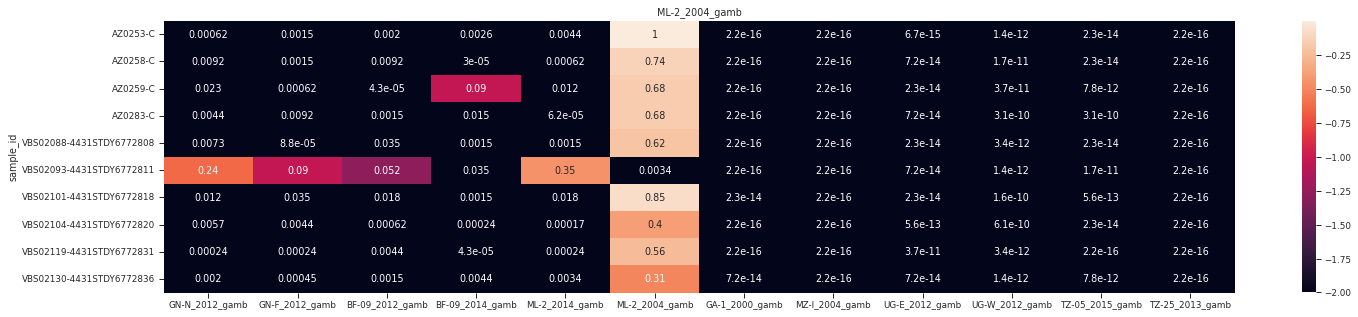

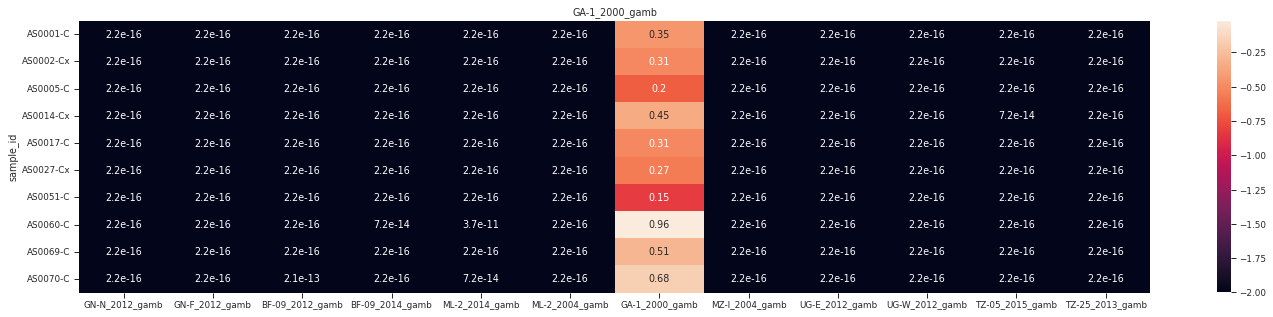

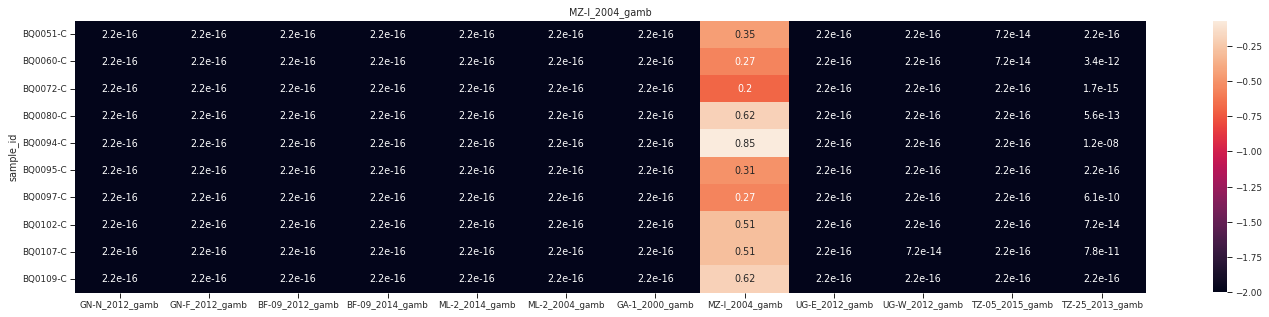

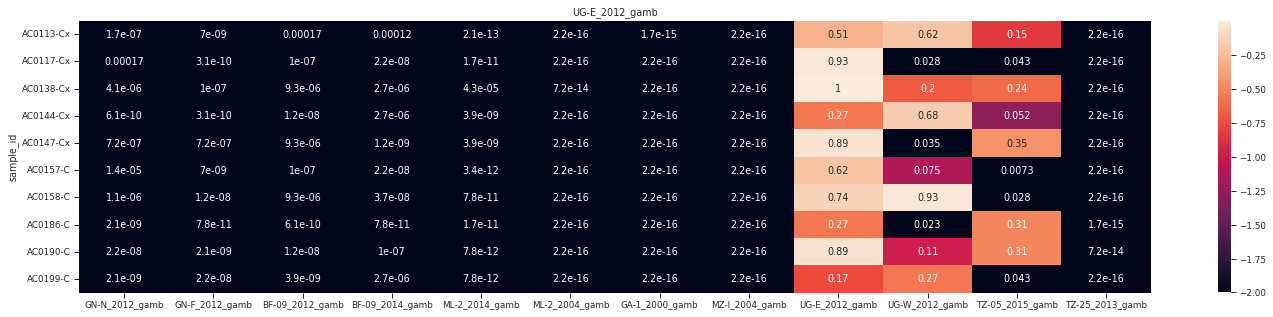

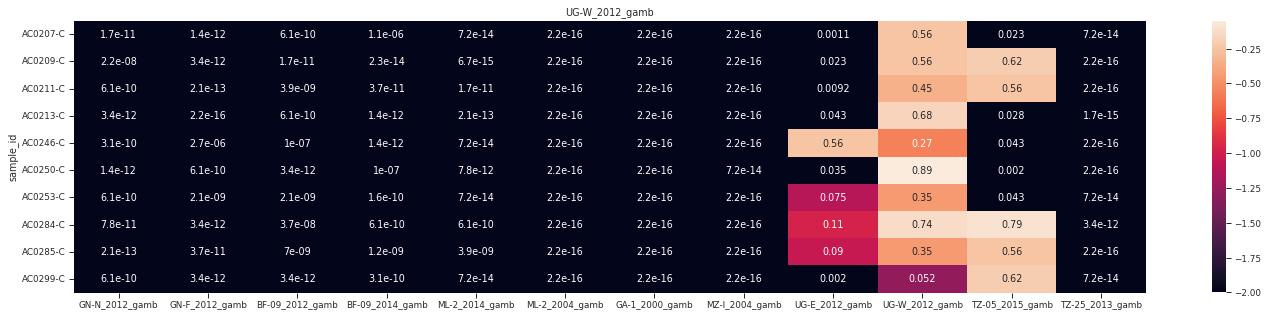

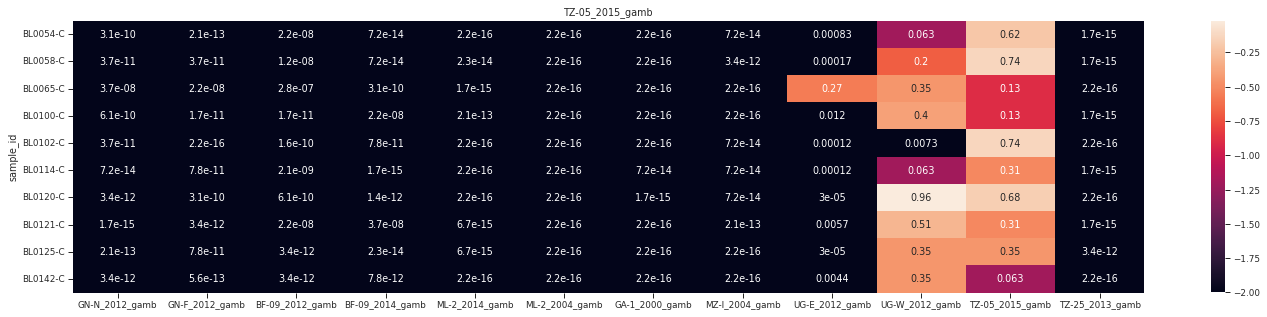

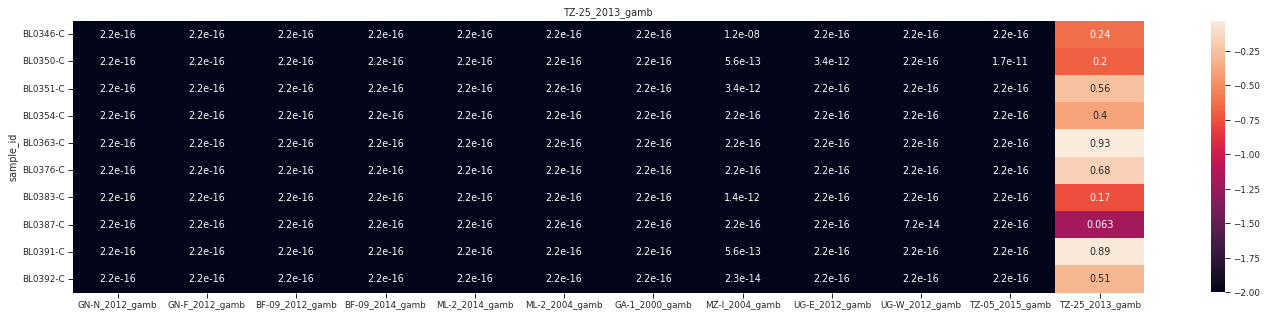

20
load and subset genotypes
locate doubletons
load and subset genotypes
count hom alt genotypes
count alleles
filter for missingness
locate doubletons
compress genotypes to doubletons
Number of positions kept: 1172214
count pairwise shared doubletons
load and subset genotypes
locate doubletons
load and subset genotypes
count hom alt genotypes
count alleles
filter for missingness
locate doubletons
compress genotypes to doubletons
Number of positions kept: 869425
count pairwise shared doubletons


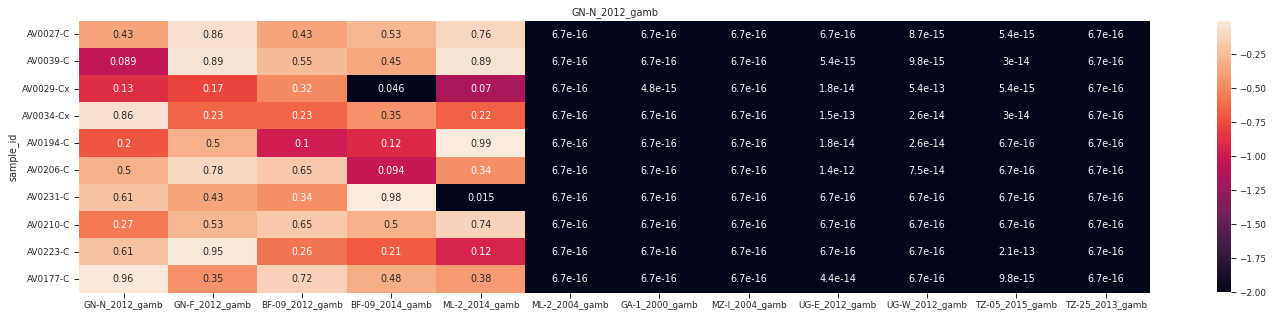

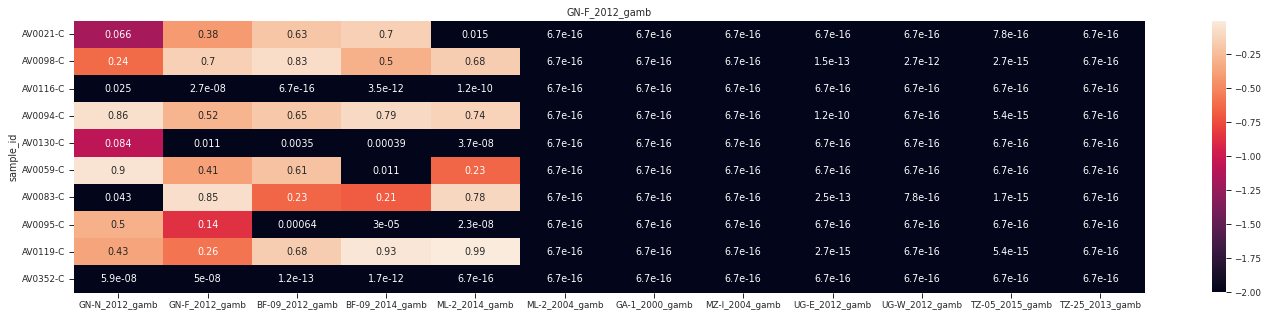

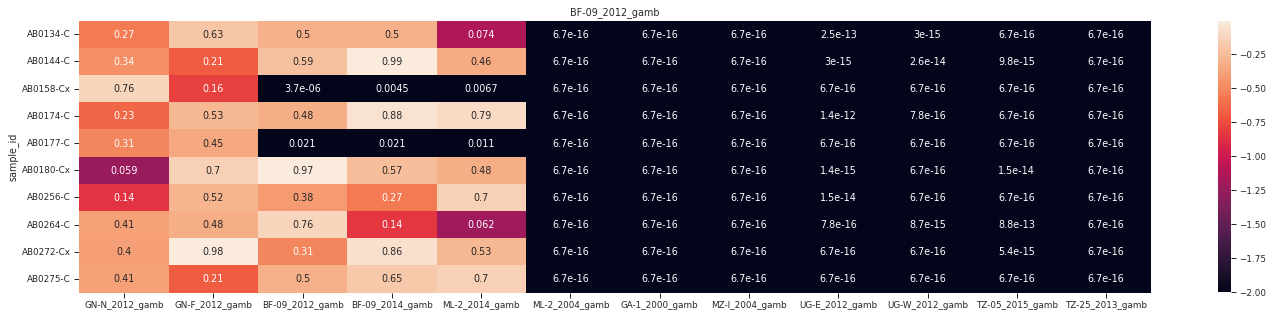

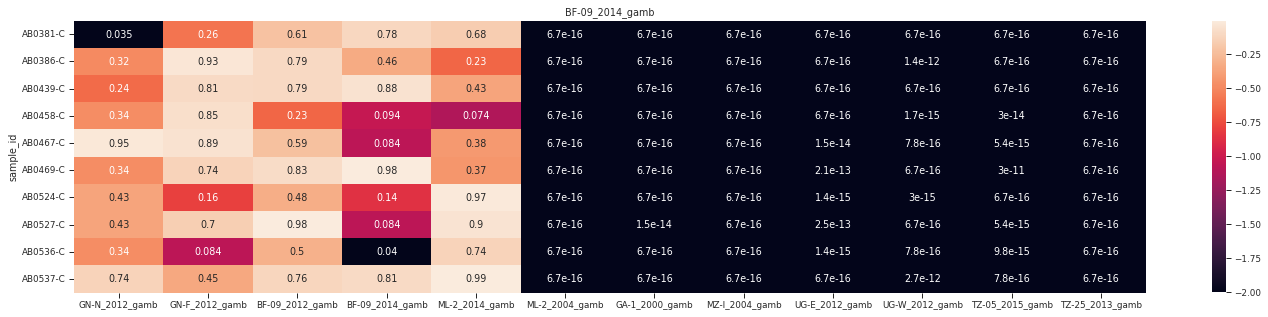

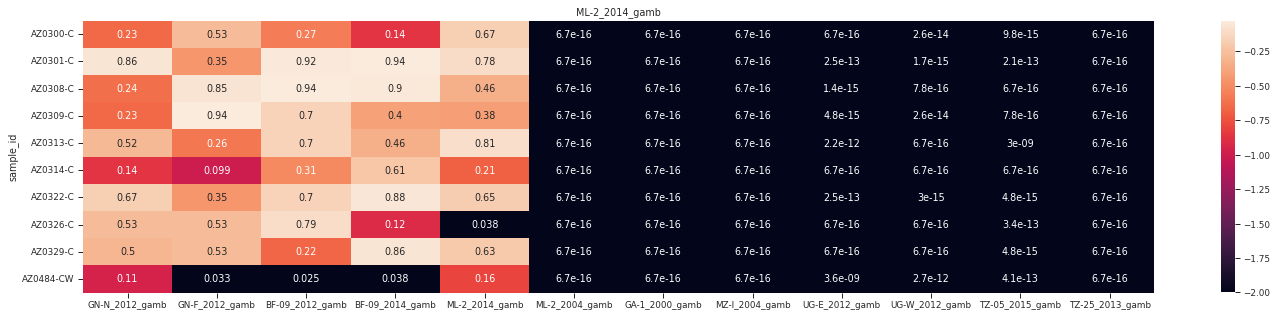

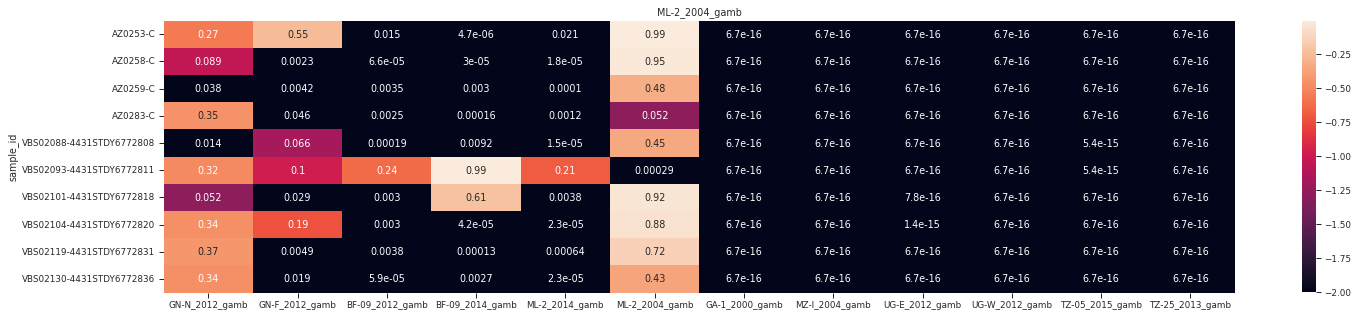

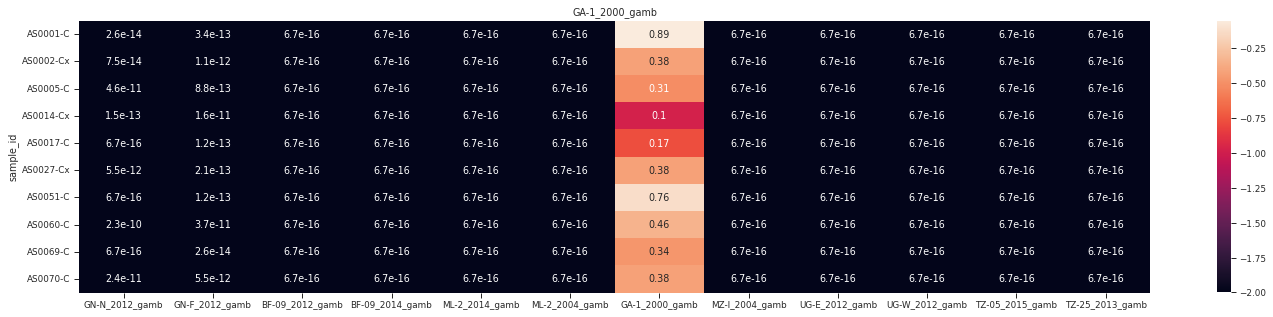

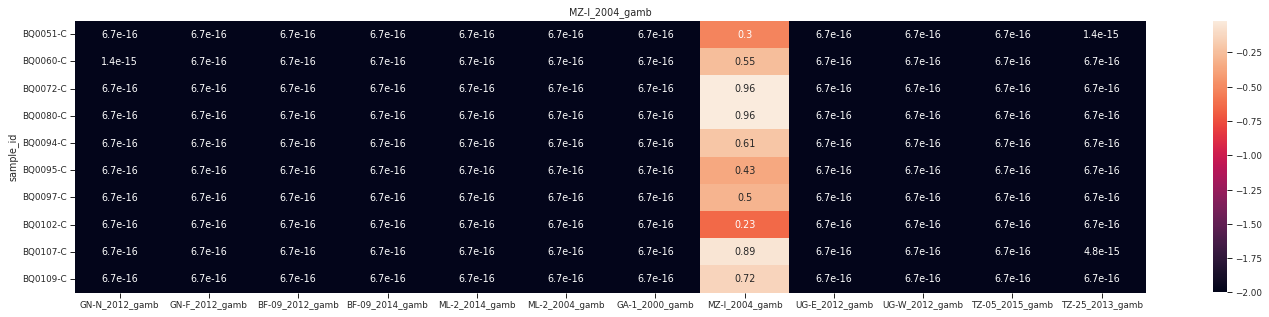

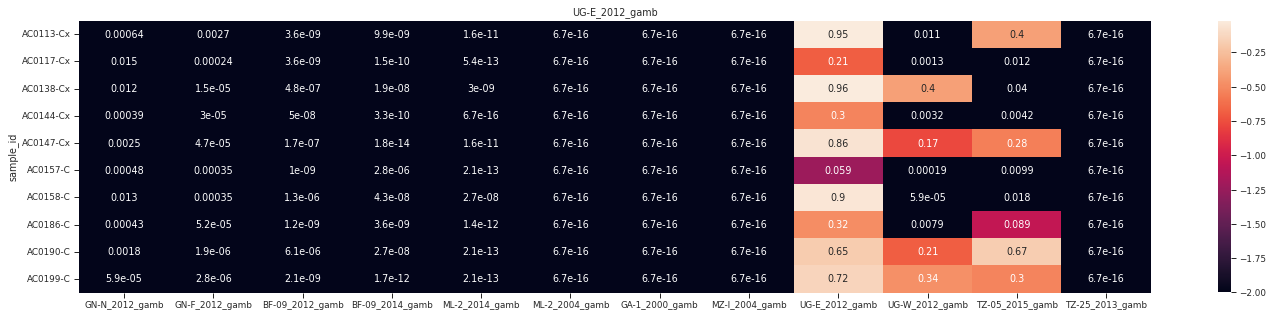

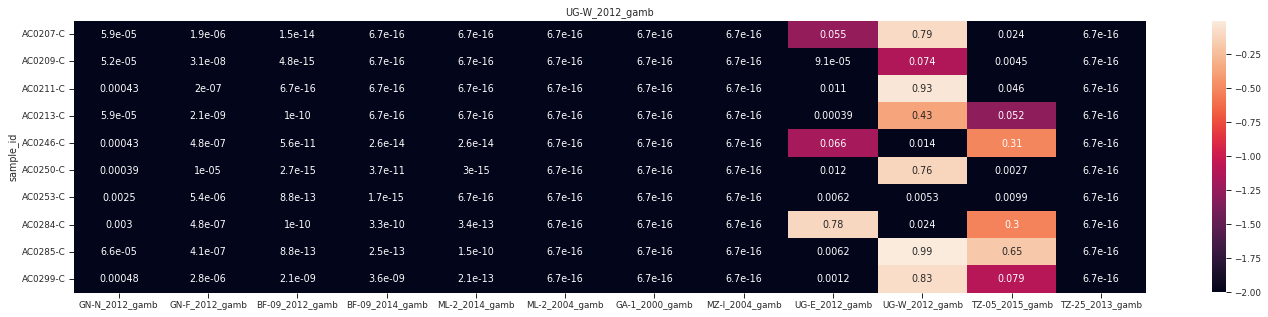

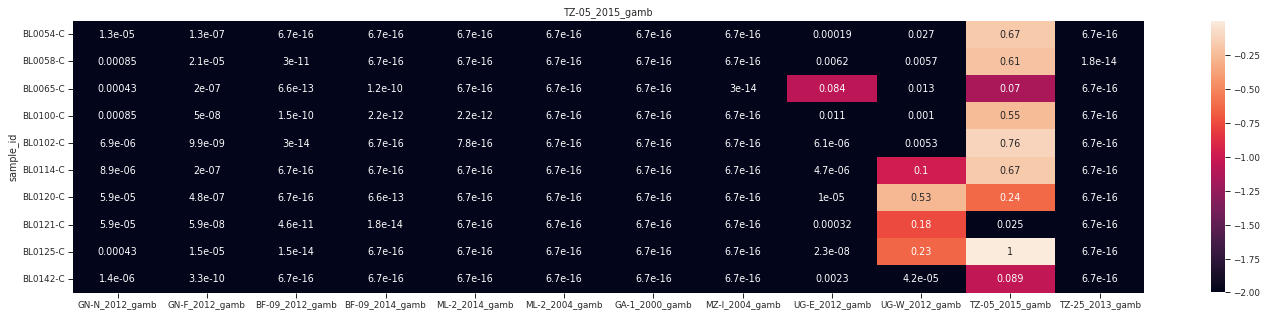

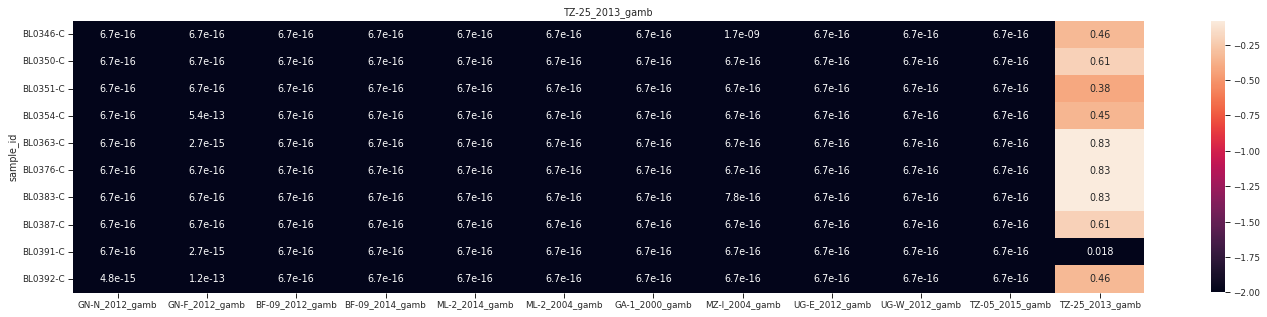

In [52]:
for n_ref in range(5,23,5):
    print(n_ref)
    cohorts_idx_ref = {pop: sorted(random.sample(cohorts_idx_not_query[pop], n_ref)) for pop in gamb_cohorts}
    cohorts_idx_ref_query = {pop: cohorts_idx_query[pop] + cohorts_idx_ref[pop] for pop in gamb_cohorts}
    sidx = list(itertools.chain(*cohorts_idx_ref_query.values()))
    ssidx = sorted(sidx)
    pairwise_dbl_3R, loc_dbl_3R = count_pairwise_doubletons('3R', 'gamb_colu', ssidx, "v3")
    pairwise_dbl_3L, loc_dbl_3L = count_pairwise_doubletons('3L', 'gamb_colu', ssidx, "v3")
    pairwise_dbl = pairwise_dbl_3L + pairwise_dbl_3R
    for pop in gamb_cohorts:
        heatmap_compare_short(pop, gamb_cohorts, cohorts_idx_query, cohorts_idx_ref, ssidx, pairwise_dbl);

## 1177-VO-ML-LEHMANN-VMF00004

In [64]:
df_leh = ag3.sample_metadata(sample_sets='v3.1')[['location','year','month','species_gambiae_coluzzii']]

In [65]:
df_leh.value_counts()

location           year  month  species_gambiae_coluzzii
Sokourani (Niono)  2015  10     coluzzii                    52
                         4      coluzzii                    52
Dallowere          2014  10     coluzzii                    50
                   2015  6      coluzzii                    49
                         9      coluzzii                    49
                   2014  6      coluzzii                    48
                   2015  4      coluzzii                    48
Sokourani (Niono)  2013  10     coluzzii                    45
                   2014  4      coluzzii                    39
Dallowere          2015  10     coluzzii                    33
                                gambiae                     17
                   2014  5      coluzzii                    16
Sokourani (Niono)  2013  4      coluzzii                    16
Dallowere          2014  10     gambiae                     14
                         9      coluzzii                    1

In [66]:
id_dall154col = list(df_leh.query("location == 'Dallowere' and year == 2015 and month == 4 and species_gambiae_coluzzii == 'coluzzii'").index)

In [67]:
id_soko154col = list(df_leh.query("location == 'Sokourani (Niono)' and year == 2015 and month == 4 and species_gambiae_coluzzii == 'coluzzii'").index)

In [68]:
max_sample_id_v3 = allel.GenotypeDaskArray(ag3.snp_genotypes(contig='3R', sample_sets='v3', site_mask='gamb_colu')).shape[1]

In [69]:
cohorts_idx_ref_query_loc = {}
cohorts_idx_query_loc = {}

In [70]:
cohorts_idx_ref_query_loc['Dall154col'] = sorted(random.sample(id_dall154col, n_ref+n_query))
cohorts_idx_ref_query_loc['Soko154col'] = sorted(random.sample(id_soko154col, n_ref+n_query))

cohorts_idx_query_loc['Dall154col'] = sorted(random.sample(cohorts_idx_ref_query_loc['Dall154col'], n_query))
cohorts_idx_query_loc['Soko154col'] = sorted(random.sample(cohorts_idx_ref_query_loc['Soko154col'], n_query))

In [71]:
cohorts_idx_ref_query['Dall154col'] = [i + max_sample_id_v3 for i in cohorts_idx_ref_query_loc['Dall154col']]
cohorts_idx_ref_query['Soko154col'] = [i + max_sample_id_v3 for i in cohorts_idx_ref_query_loc['Soko154col']]

cohorts_idx_query['Dall154col'] = [i + max_sample_id_v3 for i in cohorts_idx_query_loc['Dall154col']]
cohorts_idx_query['Soko154col'] = [i + max_sample_id_v3 for i in cohorts_idx_query_loc['Soko154col']]

cohorts_idx_ref['Dall154col'] = list(set(cohorts_idx_ref_query['Dall154col']) - set(cohorts_idx_query['Dall154col']))
cohorts_idx_ref['Soko154col'] = list(set(cohorts_idx_ref_query['Soko154col']) - set(cohorts_idx_query['Soko154col']))

In [72]:
colu_cohorts_ext = ['CI-LG_2012_colu', 'GH-CP_2012_colu',
                    'BF-09_2012_colu', 'BF-09_2014_colu', 'ML-3_2012_colu', 'ML-2_2014_colu', 'ML-4_2004_colu',
                    'Dall154col', 'Soko154col',
                    'AO-LUA_2009_colu']

In [73]:
colu_cohorts_idx_ref_query_ext = {pop: cohorts_idx_ref_query[pop] for pop in colu_cohorts_ext}
colu_cohorts_idx_query_ext = {pop: cohorts_idx_query[pop] for pop in colu_cohorts_ext}
colu_cohorts_idx_ref_ext = {pop: cohorts_idx_ref[pop] for pop in colu_cohorts_ext}

In [74]:
colu_sidx_all_ext = list(itertools.chain(*colu_cohorts_idx_ref_query_ext.values()))
colu_ssidx_all_ext = sorted(colu_sidx_all_ext)

In [75]:
pairwise_dbl_3R, loc_dbl_3R = count_pairwise_doubletons('3R', 'gamb_colu', colu_ssidx_all_ext, sample_sets=['v3',"v3.1"])

load and subset genotypes
locate doubletons
load and subset genotypes
count hom alt genotypes
count alleles
filter for missingness
locate doubletons
compress genotypes to doubletons
Number of positions kept: 1044953
count pairwise shared doubletons


In [76]:
pairwise_dbl_3L, loc_dbl_3L = count_pairwise_doubletons('3L', 'gamb_colu', colu_ssidx_all_ext, sample_sets=['v3',"v3.1"])

load and subset genotypes
locate doubletons
load and subset genotypes
count hom alt genotypes
count alleles
filter for missingness
locate doubletons
compress genotypes to doubletons
Number of positions kept: 755585
count pairwise shared doubletons


In [77]:
pairwise_dbl = pairwise_dbl_3R + pairwise_dbl_3L

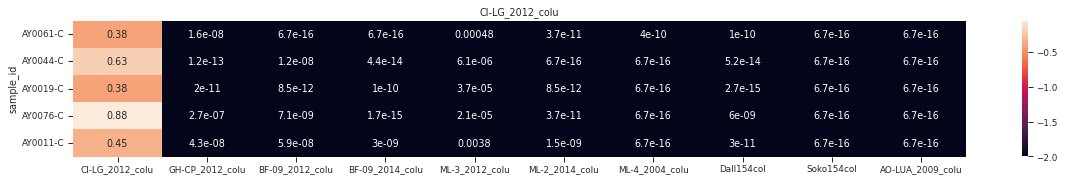

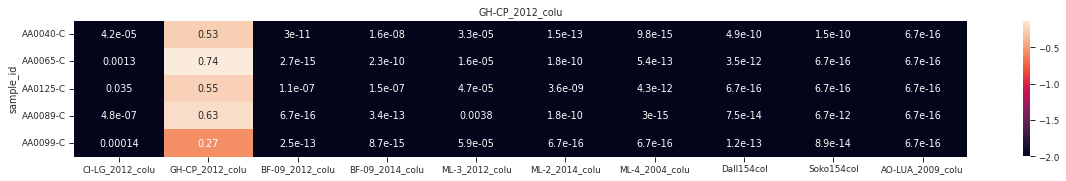

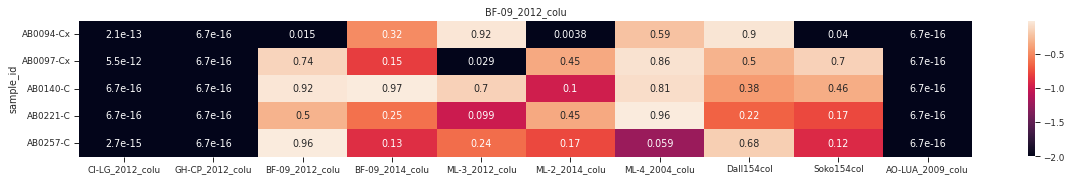

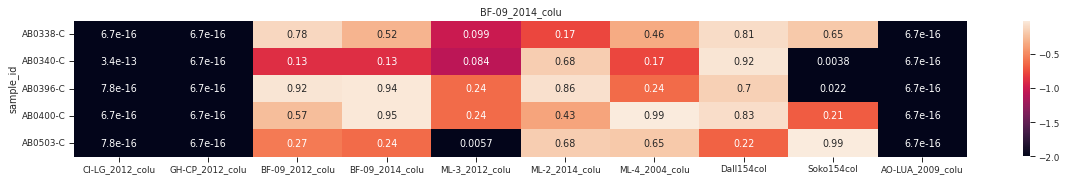

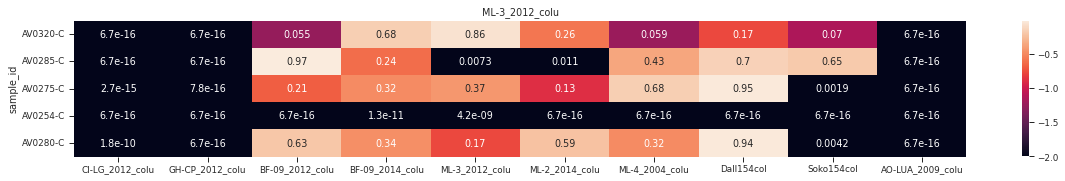

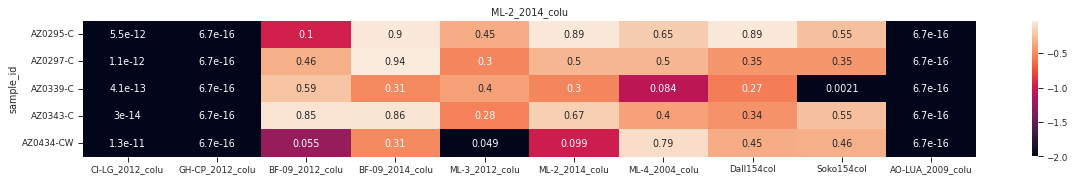

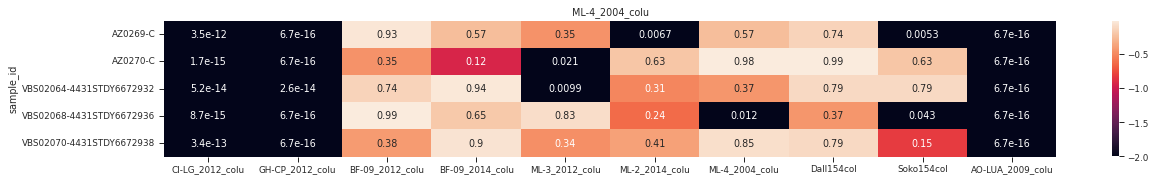

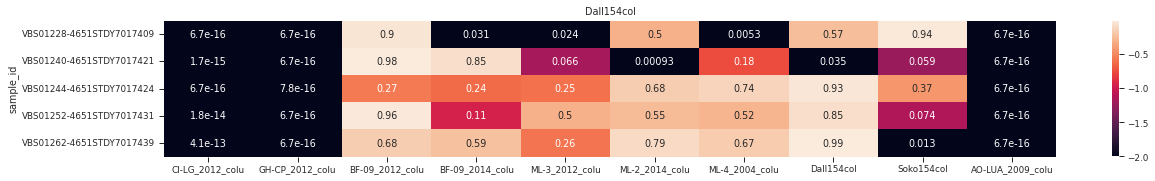

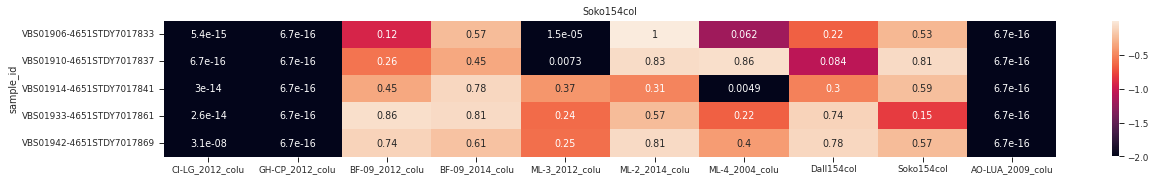

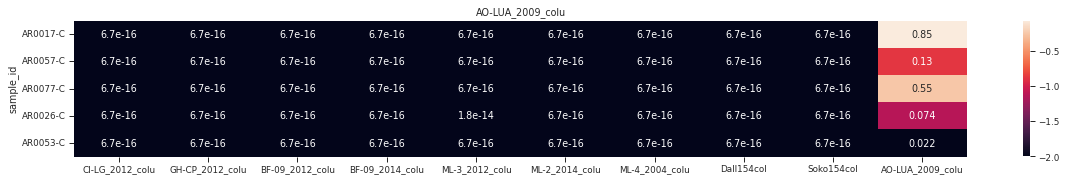

In [79]:
for pop in colu_cohorts_ext:
    heatmap_compare_short(pop, colu_cohorts_ext
                          , colu_cohorts_idx_query_ext, colu_cohorts_idx_ref_ext, colu_ssidx_all_ext, pairwise_dbl);

In [80]:
max_v31 = allel.GenotypeDaskArray(ag3.snp_genotypes(contig='3R', sample_sets='v3.1', site_mask='gamb_colu')).shape[1]

## Balloon mosquitoes

In [81]:
df_balloon = ag3.sample_metadata(sample_sets="1177-VO-ML-LEHMANN-VMF00015")
df_balloon = df_balloon[df_balloon.species_gambcolu_arabiensis == 'gamb_colu']
n_query = len(df_balloon)

In [82]:
query_idx_in_ball = [0,3,6,10,12,13,15,16,18,21]
ref_idx_in_ball = list(set(range(0,23)) - set(query_idx_in_ball))
query_idx_in_ball, ref_idx_in_ball

([0, 3, 6, 10, 12, 13, 15, 16, 18, 21],
 [1, 2, 4, 5, 7, 8, 9, 11, 14, 17, 19, 20, 22])

In [83]:
ball_idx_ref = [x + max_sample_id_v3 + max_v31 for x in ref_idx_in_ball]
ball_idx_query = [x + max_sample_id_v3 + max_v31 for x in query_idx_in_ball]
ball_idx_ref

[3730, 3731, 3733, 3734, 3736, 3737, 3738, 3740, 3743, 3746, 3748, 3749, 3751]

In [103]:
cohorts_ball_idx_ref = cohorts_idx_ref#{pop: sorted(random.sample(cohorts_idx[pop], n_ref)) for pop in cohorts_red}
cohorts_ball_idx_ref['1177-VO-ML-LEHMANN-VMF00015'] = ball_idx_ref
gamb_cohorts_ball_idx_ref = gamb_cohorts_idx_ref#{pop: sorted(random.sample(gamb_cohorts_idx[pop], n_ref)) for pop in gamb_cohorts}
gamb_cohorts_ball_idx_ref['1177-VO-ML-LEHMANN-VMF00015'] = ball_idx_ref
colu_cohorts_ball_idx_ref = colu_cohorts_idx_ref_ext
colu_cohorts_ball_idx_ref['1177-VO-ML-LEHMANN-VMF00015'] = ball_idx_ref

In [85]:
sidx_ref = list(itertools.chain(*cohorts_ball_idx_ref.values()))
gamb_sidx_ref = list(itertools.chain(*gamb_cohorts_ball_idx_ref.values()))
colu_sidx_ref = list(itertools.chain(*colu_cohorts_ball_idx_ref.values()))

In [86]:
#sidx_all = sidx_ref + list(range(max_sample_id_v3, max_sample_id_v3+n_query))
#gamb_sidx_all = gamb_sidx_ref + list(range(max_sample_id_v3, max_sample_id_v3+n_query))
#colu_sidx_all = colu_sidx_ref + list(range(max_sample_id_v3, max_sample_id_v3+n_query))

#ssidx_all = sorted(sidx_all)
#gamb_ssidx_all = sorted(gamb_sidx_all)
#colu_ssidx_all = sorted(colu_sidx_all)

In [97]:
cohorts_ball_idx_query = cohorts_idx_query
cohorts_ball_idx_query['1177-VO-ML-LEHMANN-VMF00015'] = ball_idx_query
gamb_cohorts_ball_idx_query = gamb_cohorts_idx_query
gamb_cohorts_ball_idx_query['1177-VO-ML-LEHMANN-VMF00015'] = ball_idx_query
colu_cohorts_ball_idx_query = colu_cohorts_idx_query_ext
colu_cohorts_ball_idx_query['1177-VO-ML-LEHMANN-VMF00015'] = ball_idx_query

In [130]:
cohorts_ball_idx_ref_query = cohorts_idx_ref_query
cohorts_ball_idx_ref_query['1177-VO-ML-LEHMANN-VMF00015'] = ball_idx_ref + ball_idx_query
gamb_cohorts_ball_idx_ref_query = gamb_cohorts_idx_ref_query
gamb_cohorts_ball_idx_ref_query['1177-VO-ML-LEHMANN-VMF00015'] = ball_idx_ref + ball_idx_query
colu_cohorts_ball_idx_ref_query = colu_cohorts_idx_ref_query_ext
colu_cohorts_ball_idx_ref_query['1177-VO-ML-LEHMANN-VMF00015'] = ball_idx_ref + ball_idx_query

In [134]:
colu_cohorts_ball_idx_ref_query

{'CI-LG_2012_colu': [529,
  532,
  535,
  536,
  537,
  538,
  539,
  546,
  548,
  549,
  550,
  559,
  561,
  565,
  568,
  569,
  572,
  579,
  581,
  587,
  588,
  596,
  597,
  599,
  602],
 'GH-CP_2012_colu': [1142,
  1147,
  1148,
  1149,
  1150,
  1151,
  1152,
  1161,
  1162,
  1163,
  1164,
  1169,
  1170,
  1171,
  1172,
  1176,
  1177,
  1182,
  1193,
  1197,
  1204,
  1205,
  1211,
  1237,
  1238],
 'BF-09_2012_colu': [86,
  89,
  90,
  92,
  95,
  99,
  102,
  103,
  120,
  128,
  163,
  169,
  189,
  200,
  202,
  206,
  208,
  209,
  225,
  226,
  227,
  234,
  239,
  240,
  243],
 'BF-09_2014_colu': [264,
  265,
  271,
  272,
  274,
  277,
  280,
  281,
  284,
  285,
  286,
  287,
  290,
  291,
  293,
  294,
  297,
  307,
  310,
  311,
  314,
  342,
  344,
  347,
  363],
 'ML-3_2012_colu': [1623,
  1681,
  1720,
  1721,
  1722,
  1723,
  1724,
  1726,
  1727,
  1728,
  1730,
  1732,
  1733,
  1734,
  1735,
  1738,
  1739,
  1741,
  1742,
  1743,
  1745,
  1746,
  1748,

In [89]:
#cohorts_ball_idx_ref_query = {pop: cohorts_ball_idx_ref[pop] + list(range(max_sample_id_v3, max_sample_id_v3+n_query)) for pop in gamb_cohorts[:5]}#cohorts_red}
#gamb_cohorts_ball_idx_ref_query = {pop: gamb_cohorts_ball_idx_ref[pop] + list(range(max_sample_id_v3, max_sample_id_v3+n_query)) for pop in gamb_cohorts}
#colu_cohorts_ball_idx_ref_query = {pop: colu_cohorts_ball_idx_ref[pop] + list(range(max_sample_id_v3, max_sample_id_v3+n_query)) for pop in colu_cohorts}

In [99]:
sidx_all = list(itertools.chain(*cohorts_ball_idx_ref_query.values()))
ssidx_all = sorted(sidx_all)
gamb_sidx_all = list(itertools.chain(*gamb_cohorts_ball_idx_ref_query.values()))
gamb_ssidx_all = sorted(gamb_sidx_all)
colu_sidx_all = list(itertools.chain(*colu_cohorts_ball_idx_ref_query.values()))
colu_ssidx_all = sorted(colu_sidx_all)

In [91]:
pairwise_dbl_3R, loc_dbl_3R = count_pairwise_doubletons('3R', 'gamb_colu', ssidx_all, sample_sets=['v3','v3.1',"1177-VO-ML-LEHMANN-VMF00015"])

load and subset genotypes
locate doubletons
load and subset genotypes
count hom alt genotypes
count alleles
filter for missingness
locate doubletons
compress genotypes to doubletons
Number of positions kept: 1339858
count pairwise shared doubletons


In [92]:
pairwise_dbl_3L, loc_dbl_3L = count_pairwise_doubletons('3L', 'gamb_colu', ssidx_all, sample_sets=['v3','v3.1',"1177-VO-ML-LEHMANN-VMF00015"])#count_pairwise_doubletons('3R', 'gamb_colu', ssidx, "v3")

load and subset genotypes
locate doubletons
load and subset genotypes
count hom alt genotypes
count alleles
filter for missingness
locate doubletons
compress genotypes to doubletons
Number of positions kept: 985959
count pairwise shared doubletons


In [93]:
pairwise_dbl = pairwise_dbl_3R + pairwise_dbl_3L

In [94]:
pairwise_dbl.shape, len(ssidx_all)

((163878,), 573)

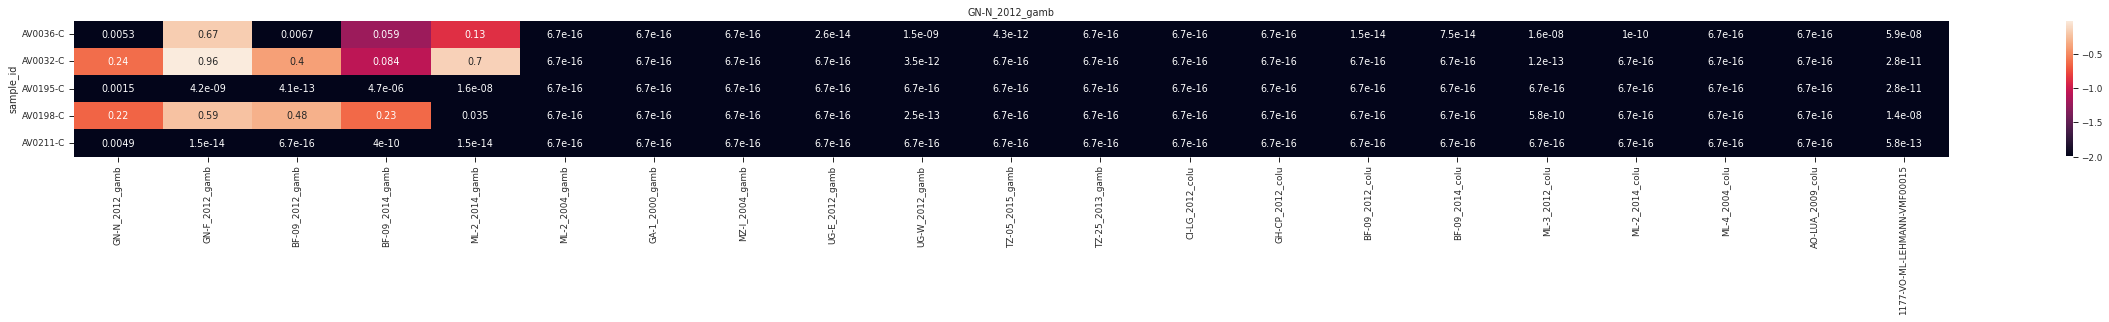

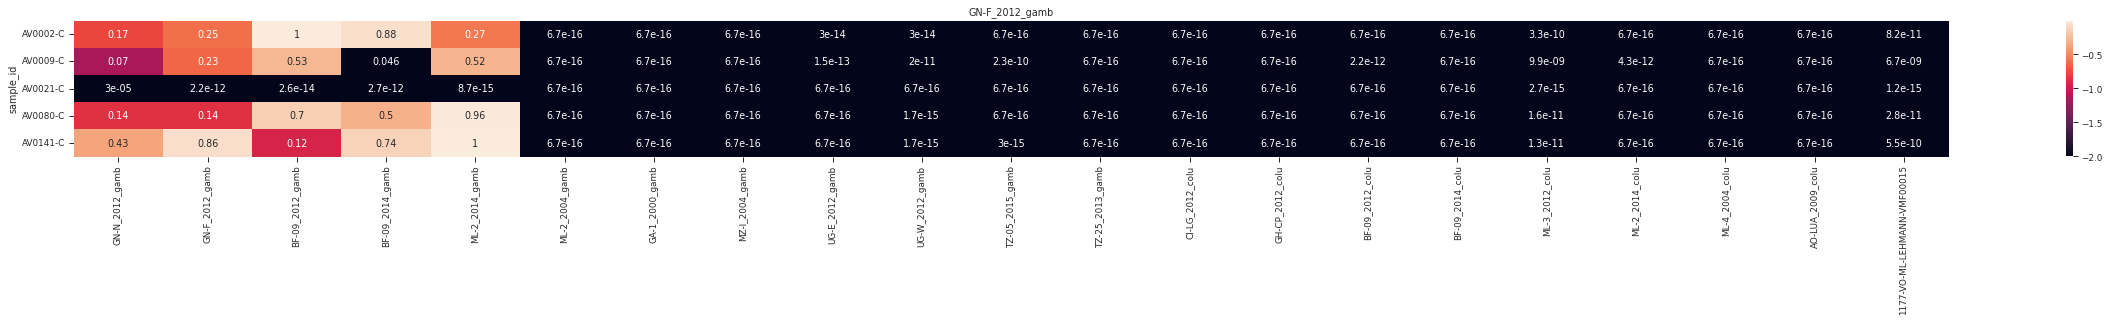

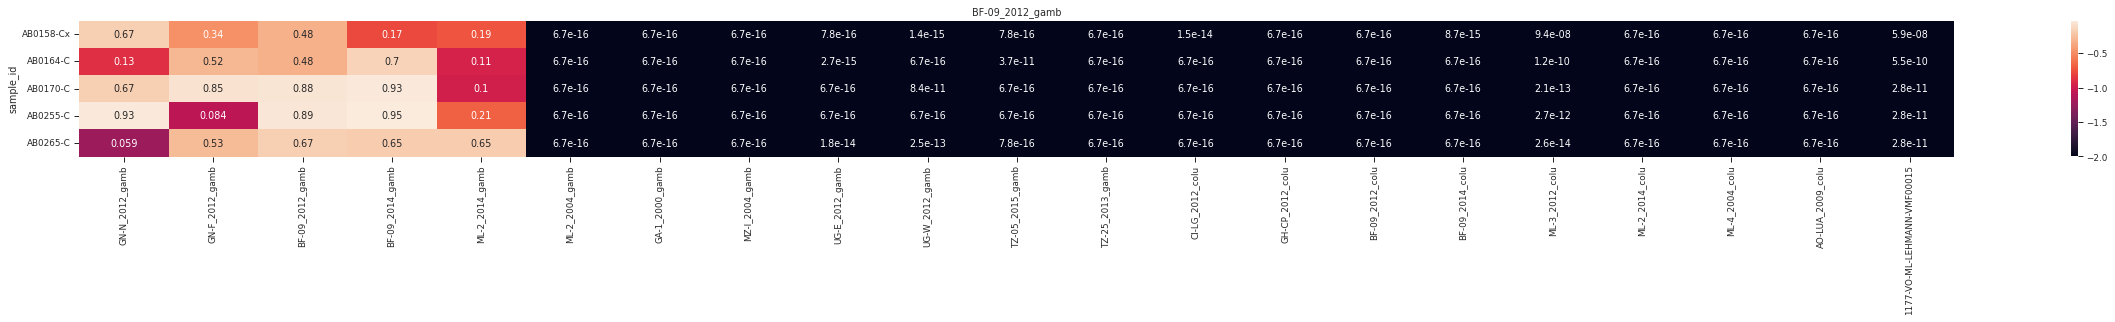

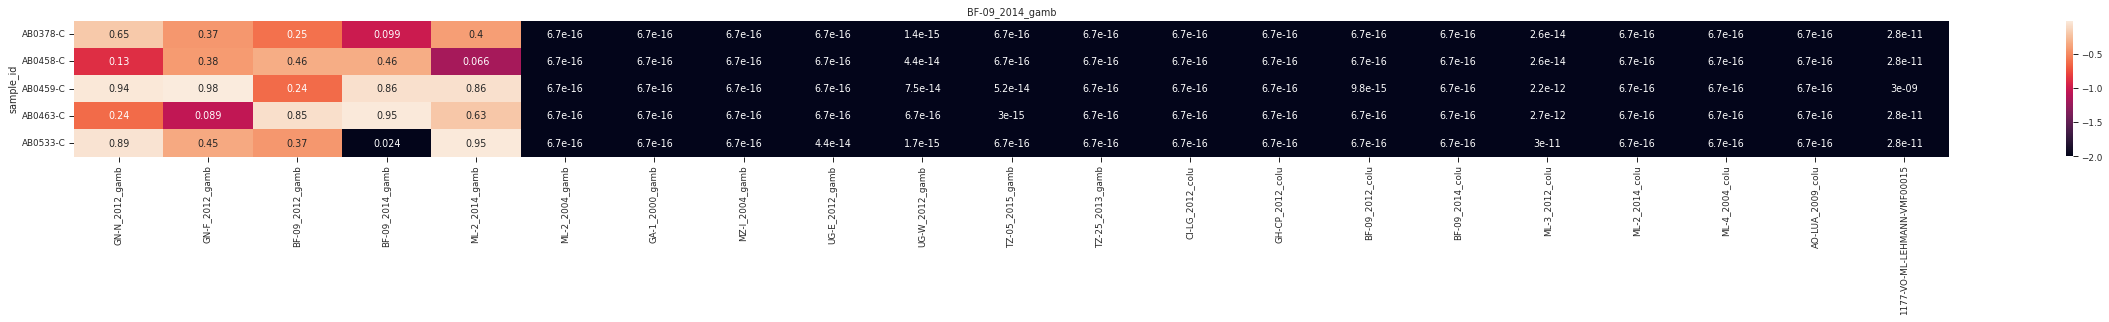

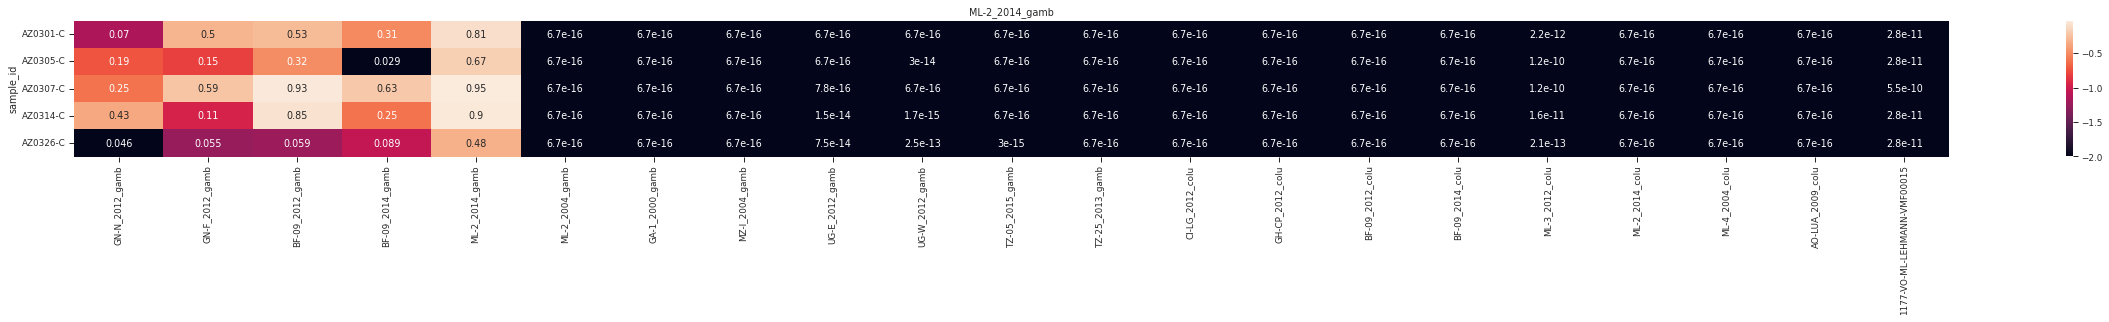

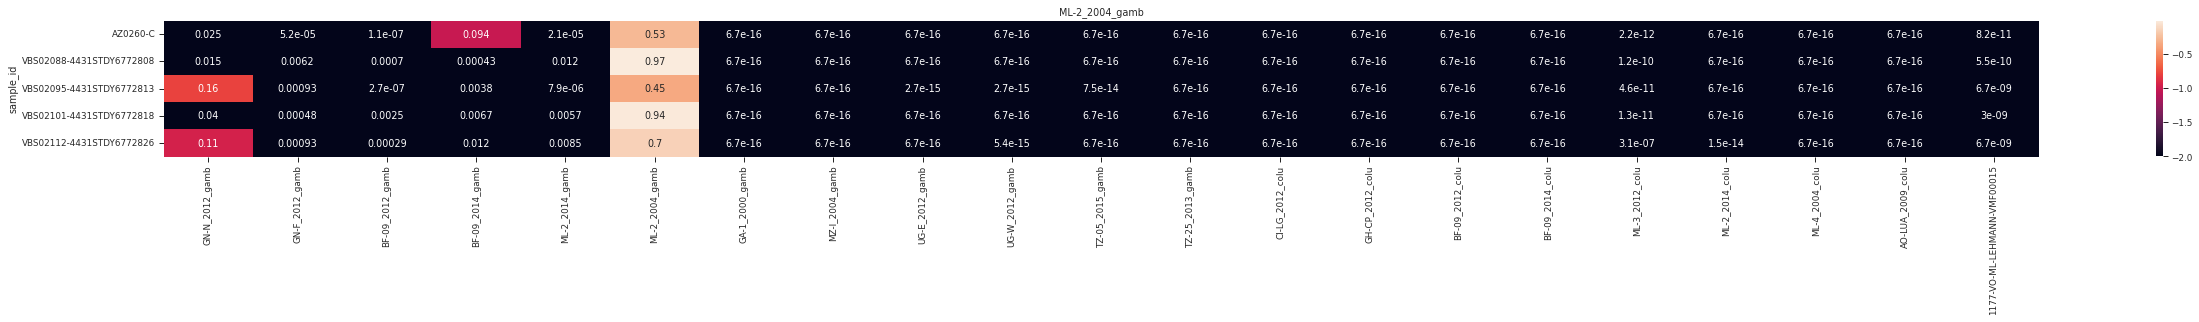

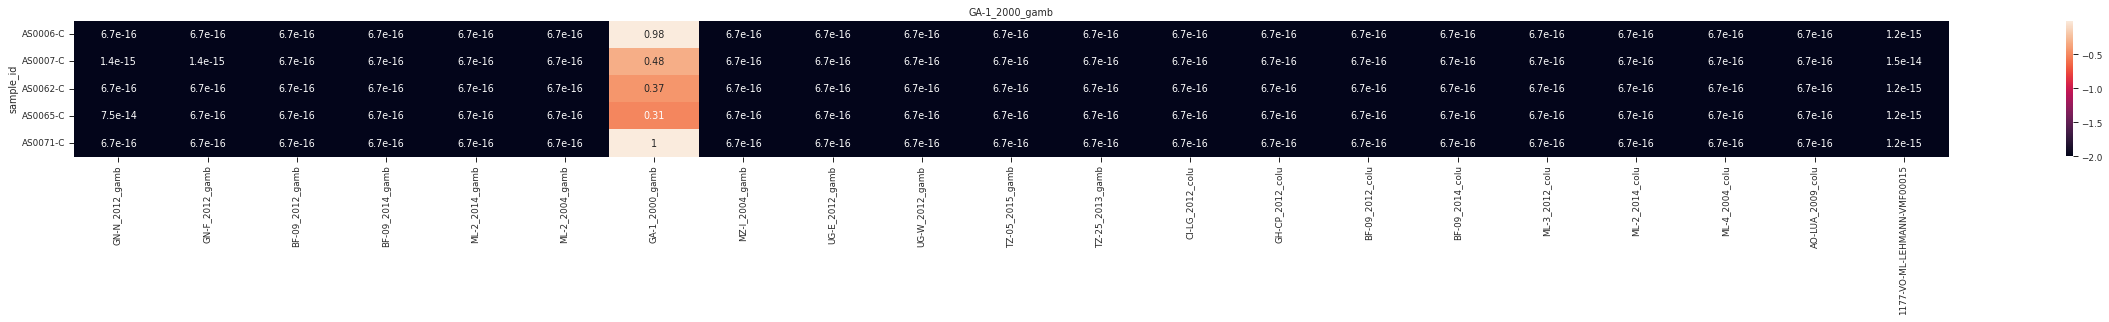

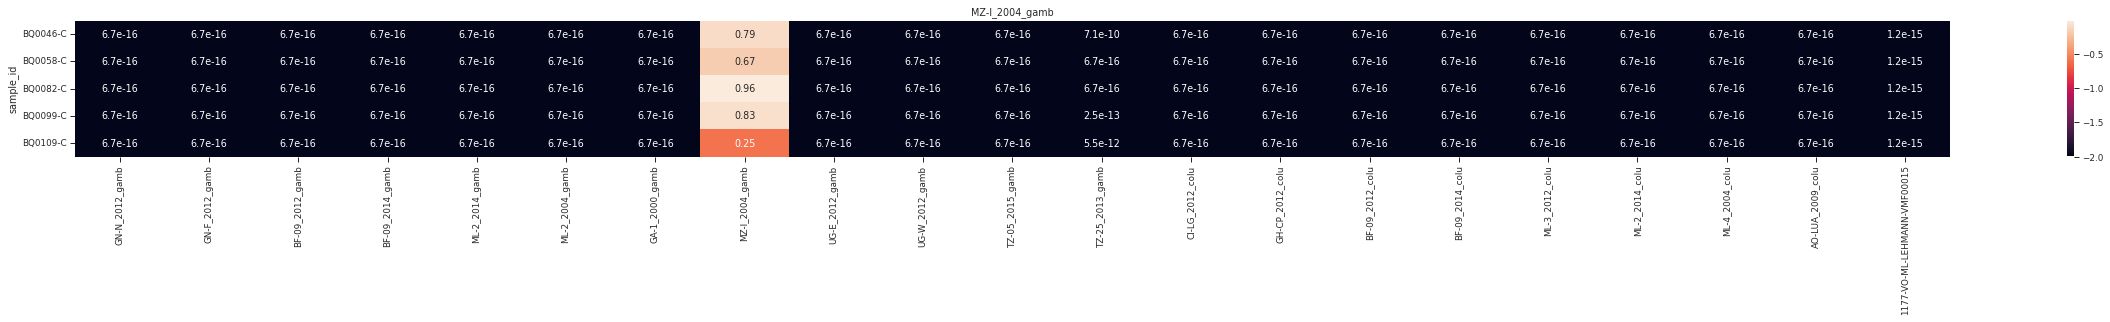

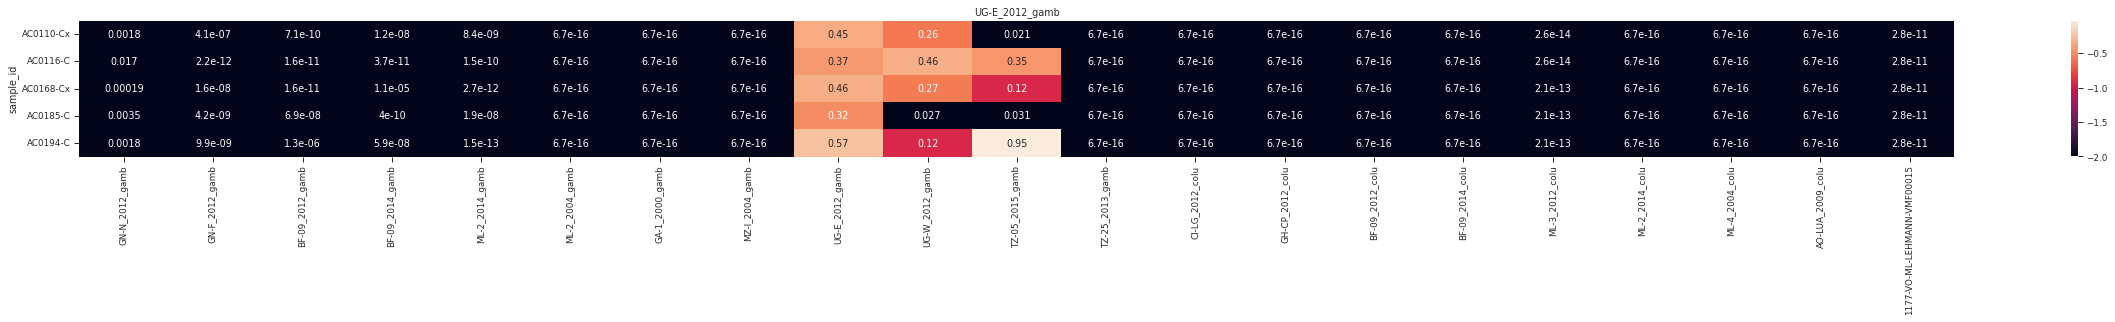

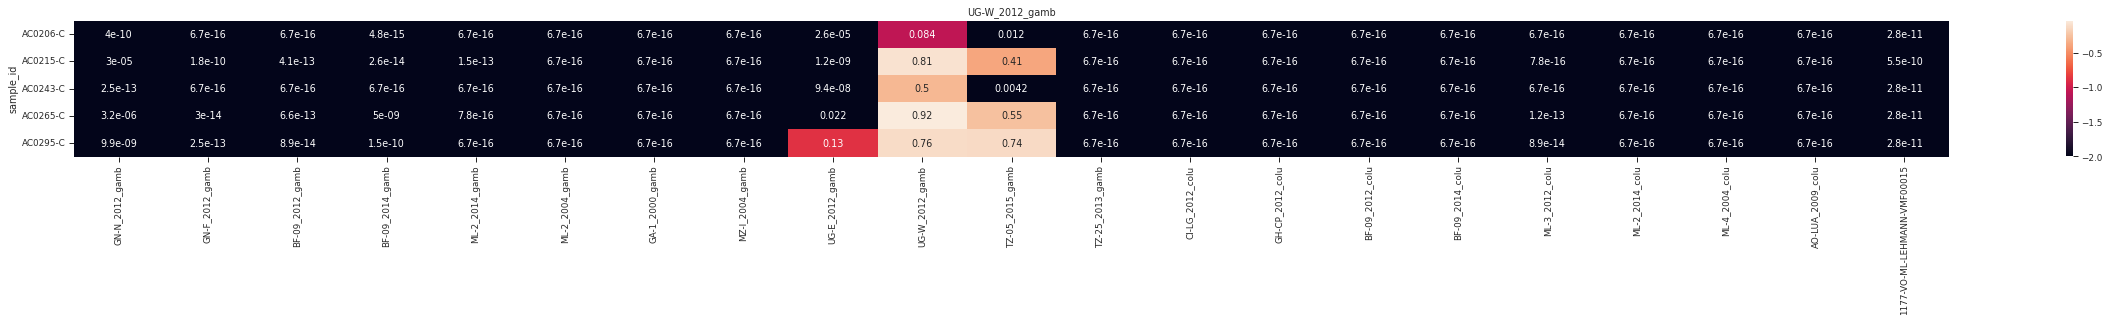

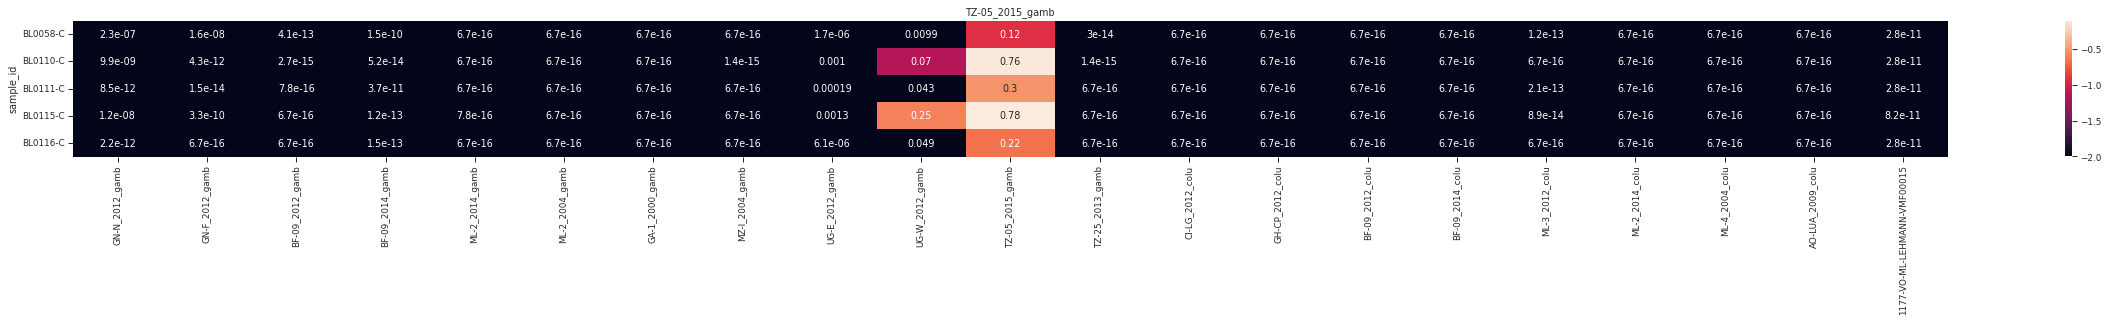

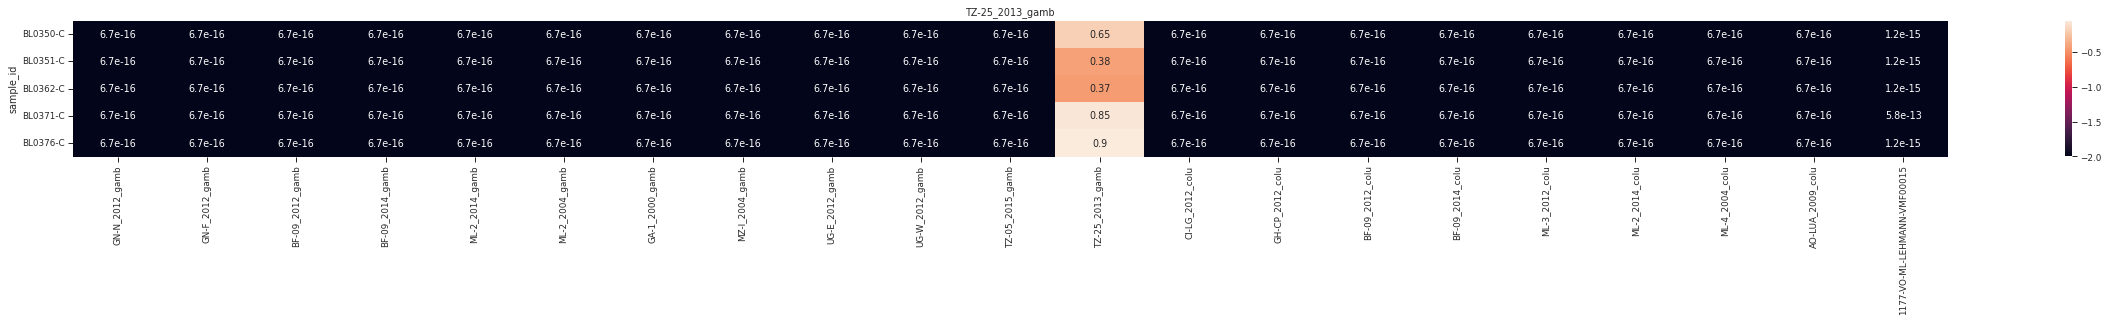

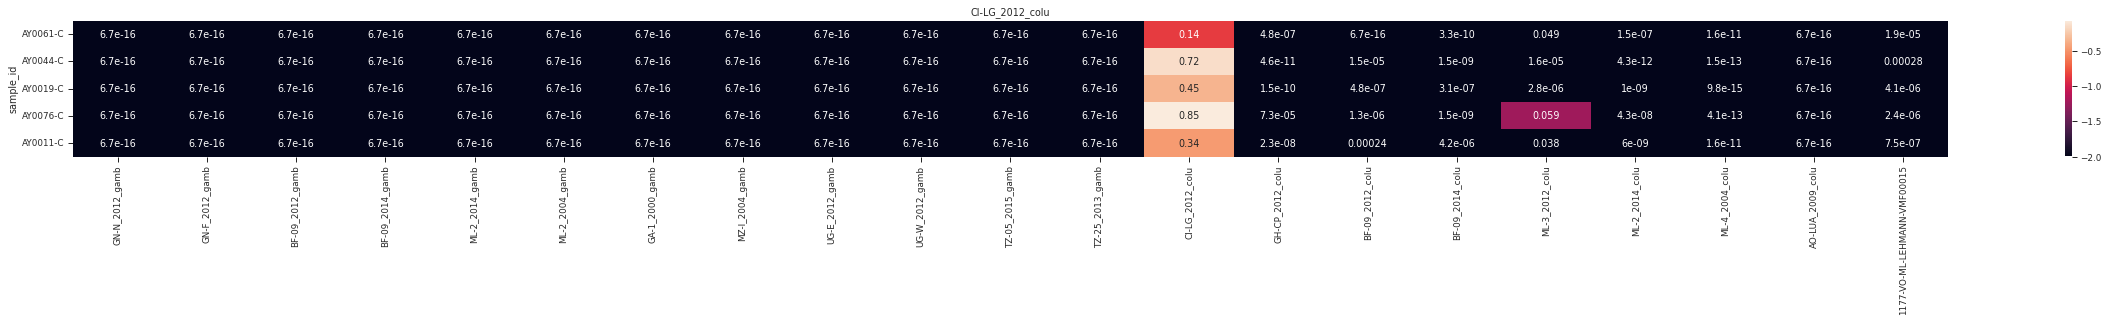

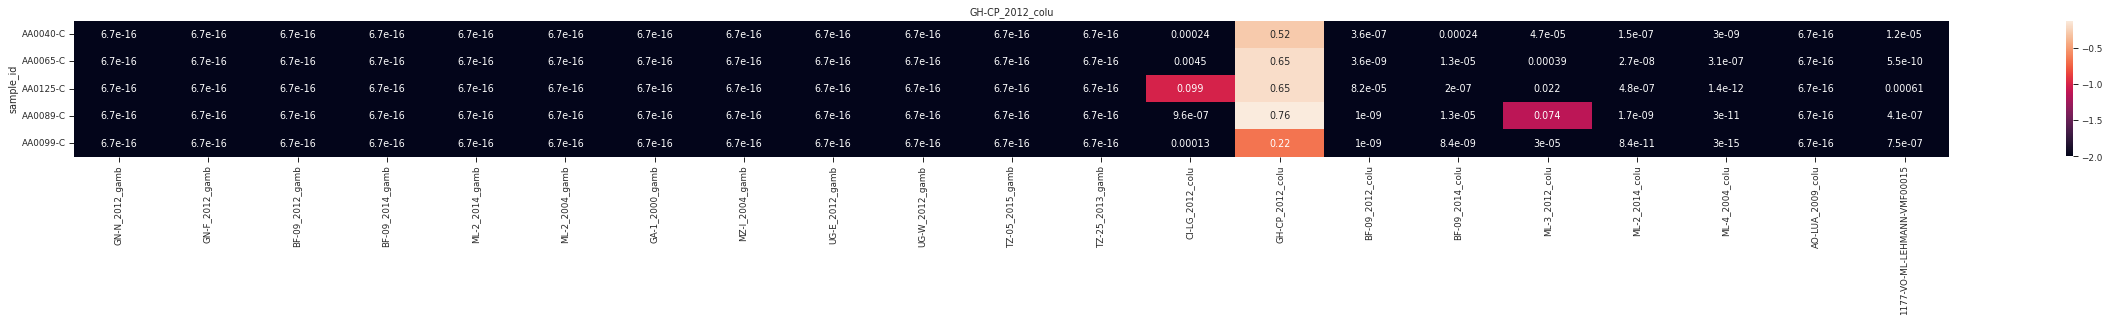

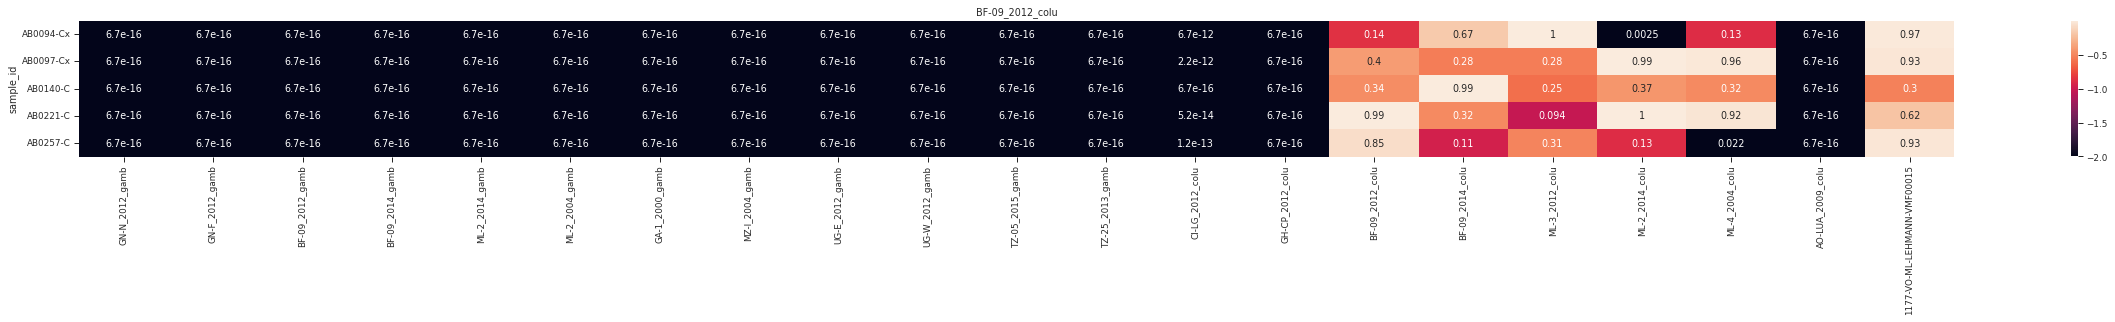

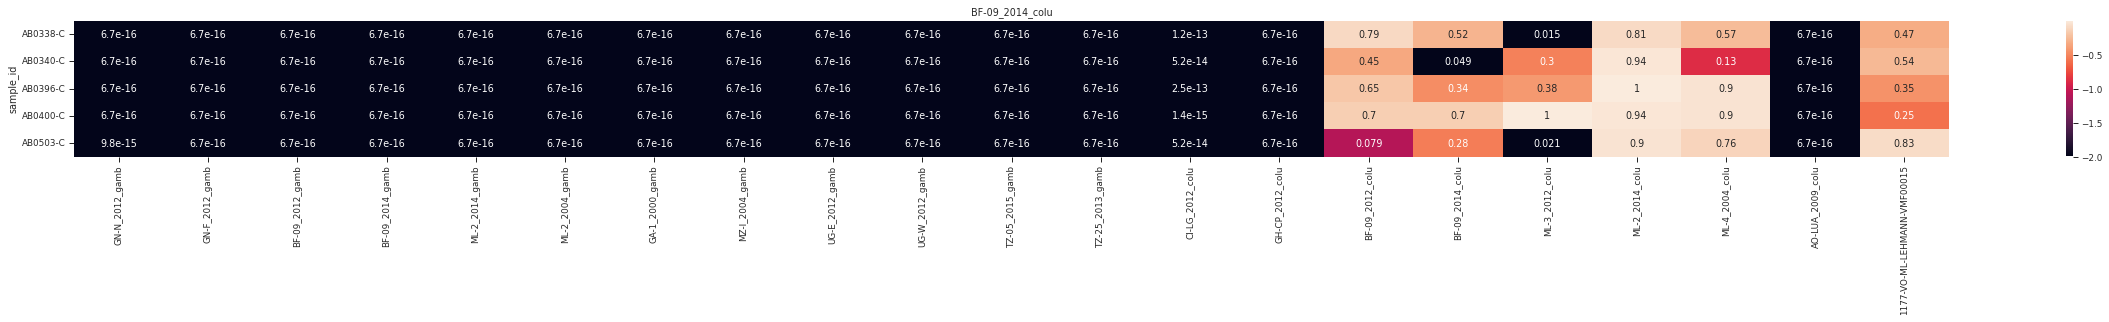

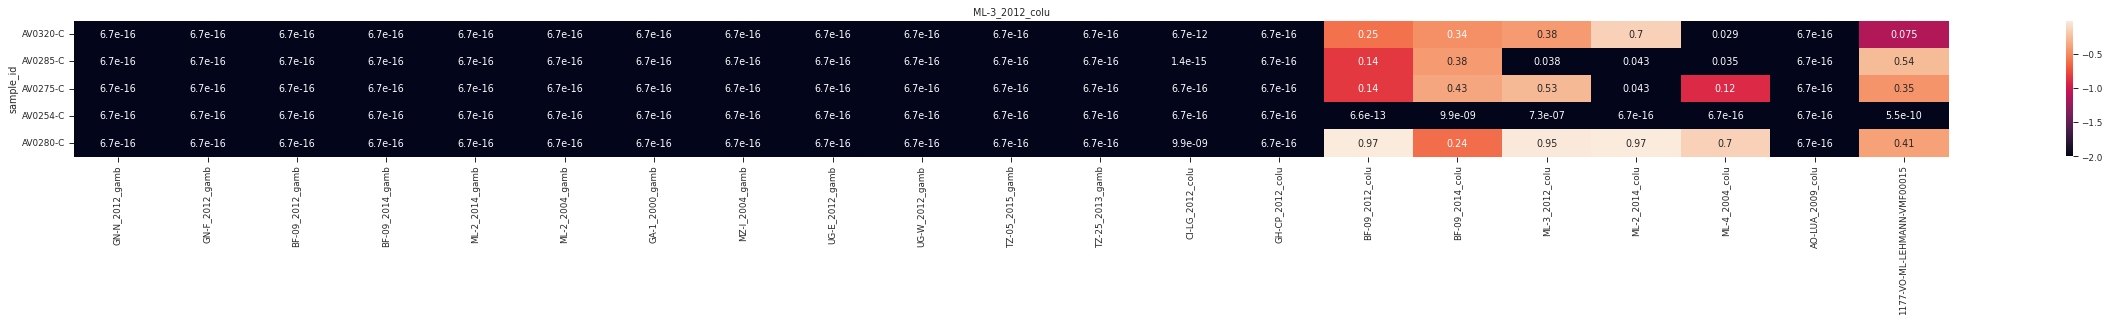

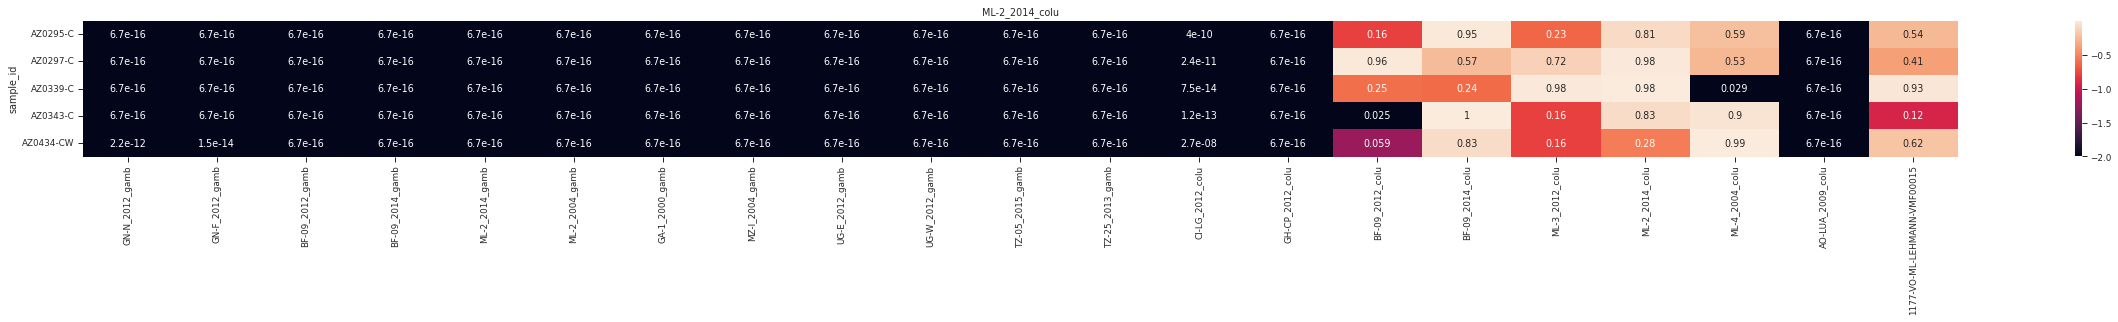

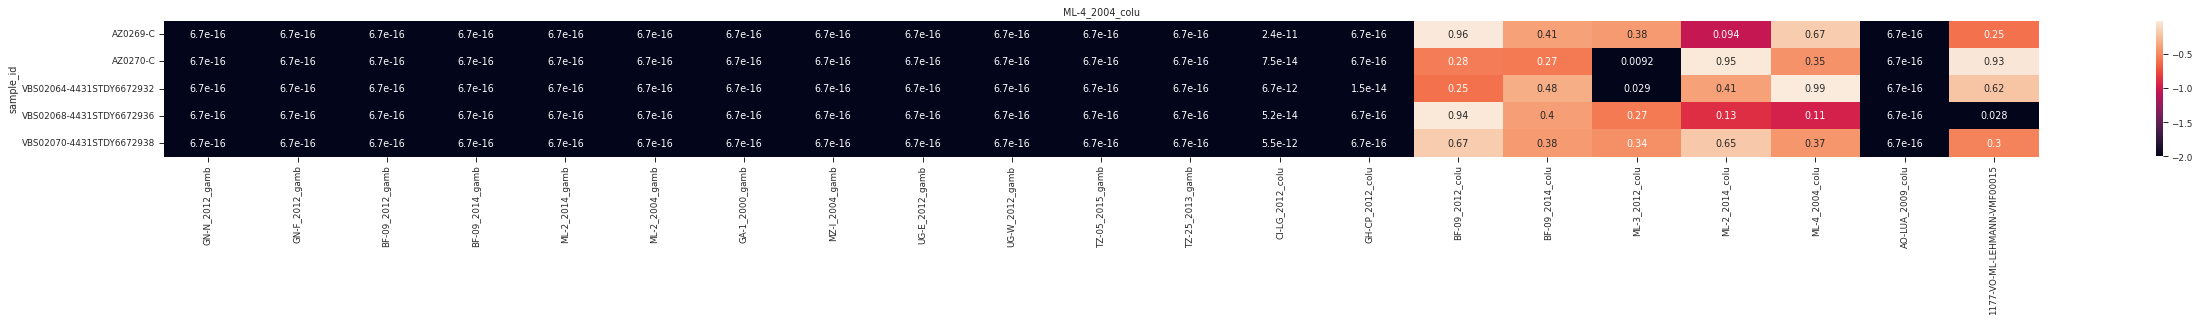

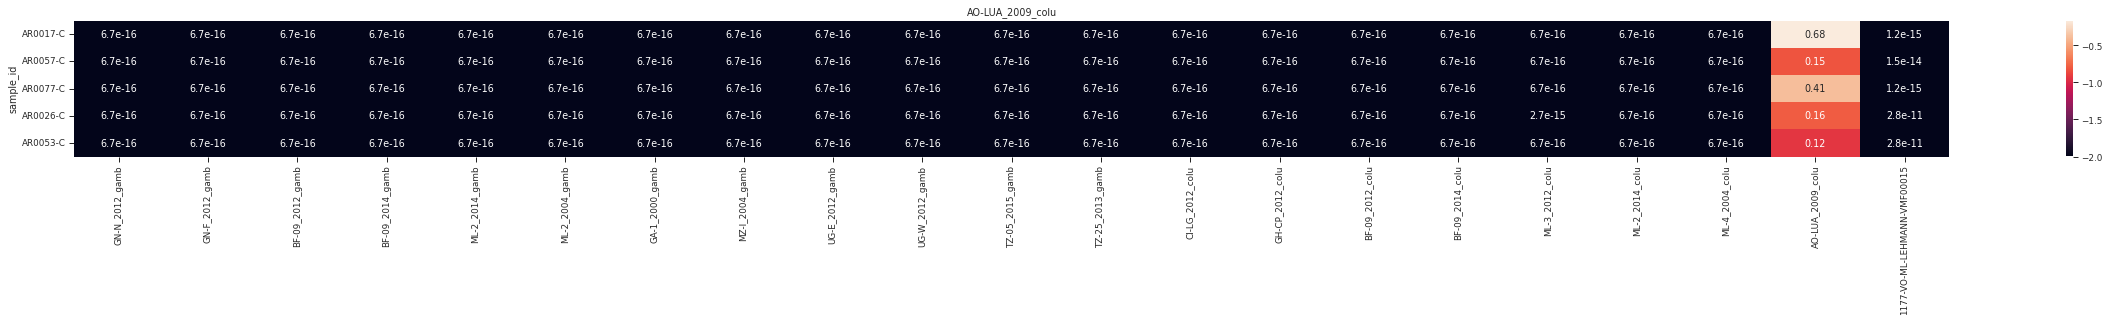

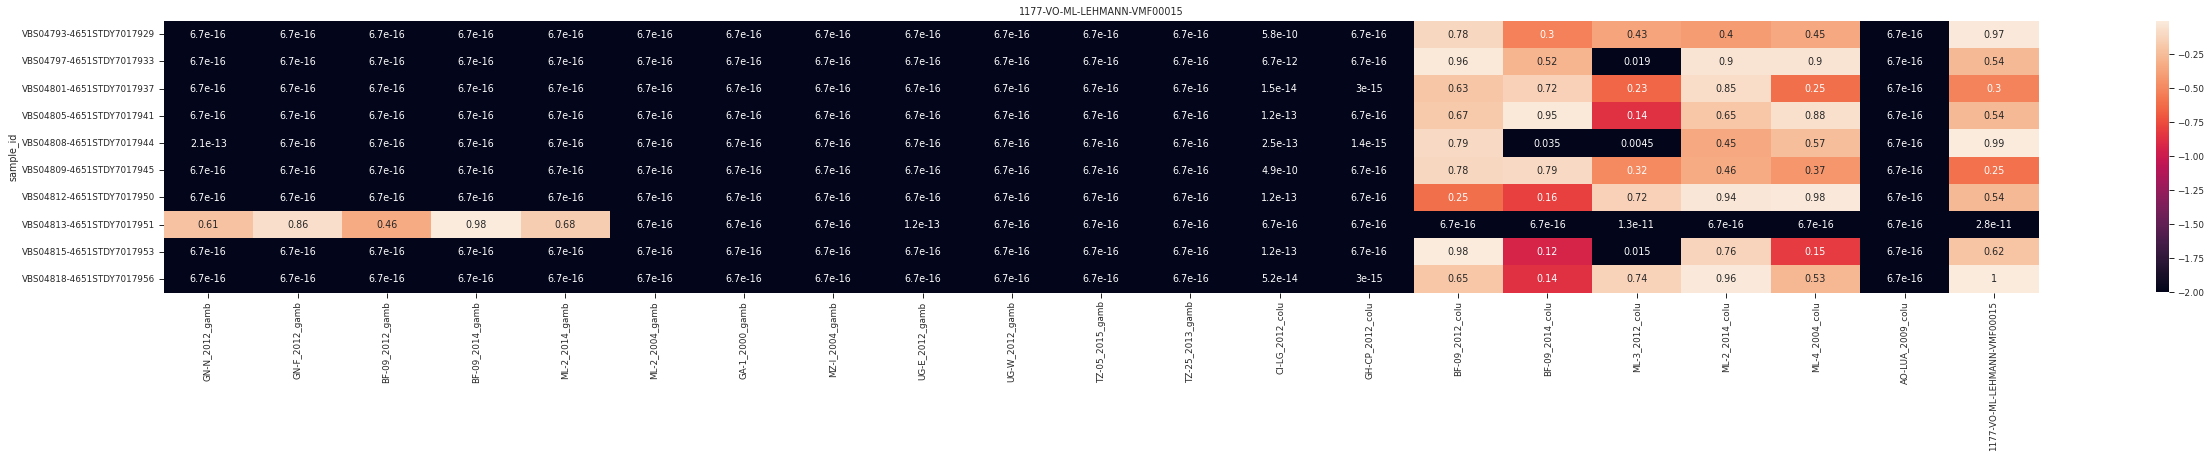

In [96]:
for pop in cohorts_red + ["1177-VO-ML-LEHMANN-VMF00015"]:
    heatmap_compare_short(pop, cohorts_red + ["1177-VO-ML-LEHMANN-VMF00015"]
                          , cohorts_ball_idx_query, cohorts_ball_idx_ref, ssidx_all, pairwise_dbl);

In [100]:
pairwise_dbl_3R, loc_dbl_3R = count_pairwise_doubletons('3R', 'gamb_colu', colu_ssidx_all, sample_sets=['v3','v3.1',"1177-VO-ML-LEHMANN-VMF00015"])

load and subset genotypes
locate doubletons
load and subset genotypes
count hom alt genotypes
count alleles
filter for missingness
locate doubletons
compress genotypes to doubletons
Number of positions kept: 1067756
count pairwise shared doubletons


In [101]:
pairwise_dbl_3L, loc_dbl_3L = count_pairwise_doubletons('3L', 'gamb_colu', colu_ssidx_all, sample_sets=['v3','v3.1',"1177-VO-ML-LEHMANN-VMF00015"])#count_pairwise_doubletons('3R', 'gamb_colu', ssidx, "v3")

load and subset genotypes
locate doubletons
load and subset genotypes
count hom alt genotypes
count alleles
filter for missingness
locate doubletons
compress genotypes to doubletons
Number of positions kept: 774528
count pairwise shared doubletons


In [102]:
pairwise_dbl = pairwise_dbl_3R + pairwise_dbl_3L

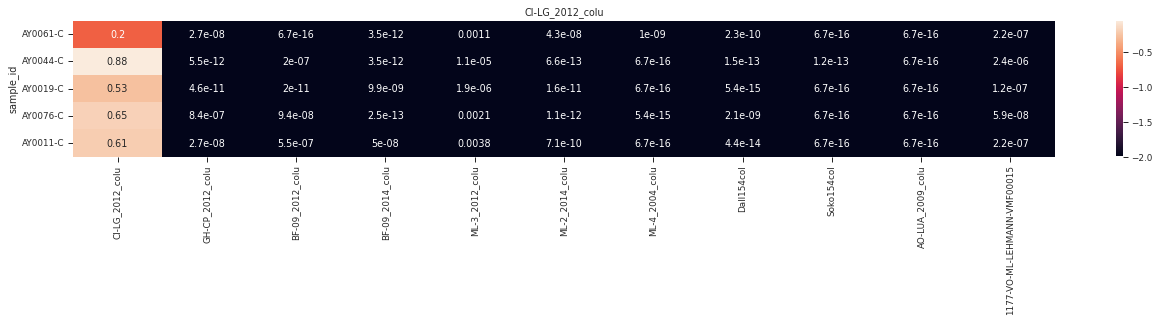

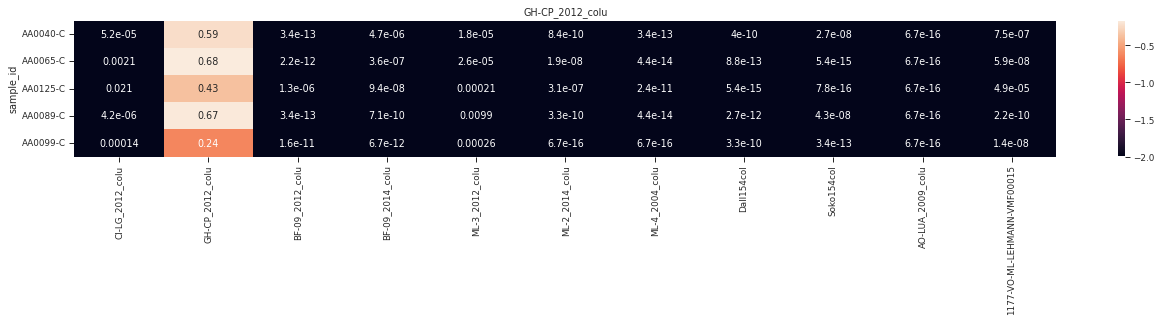

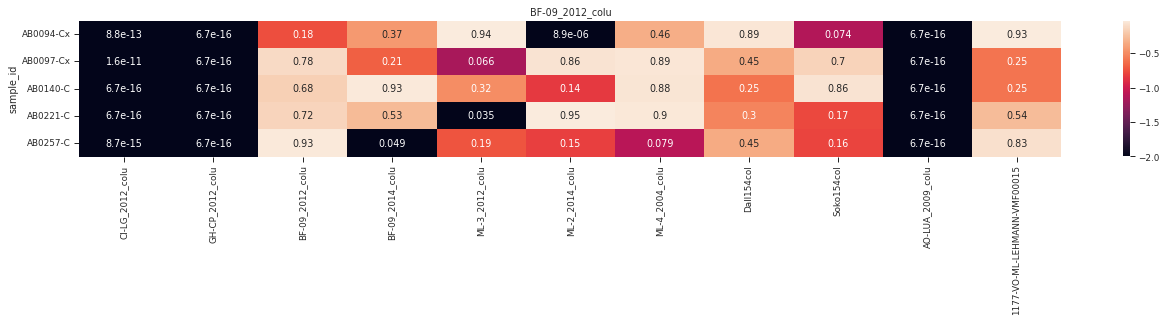

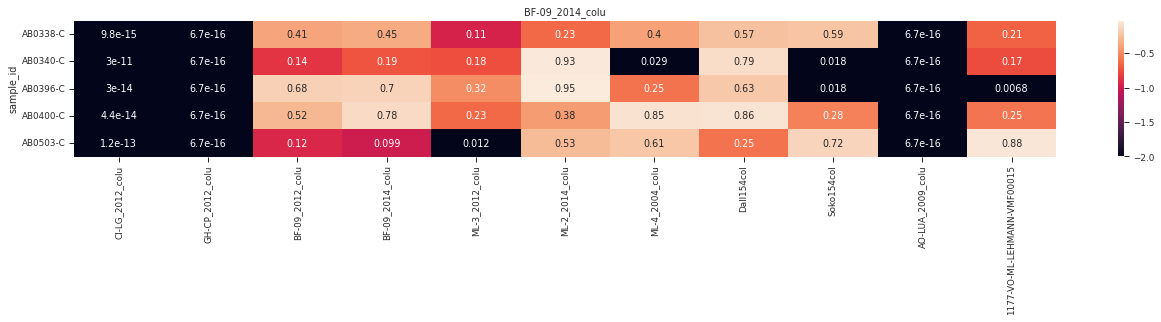

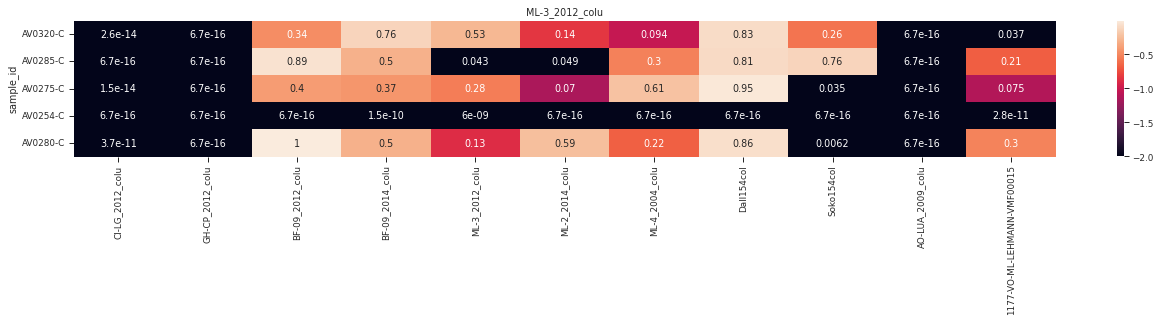

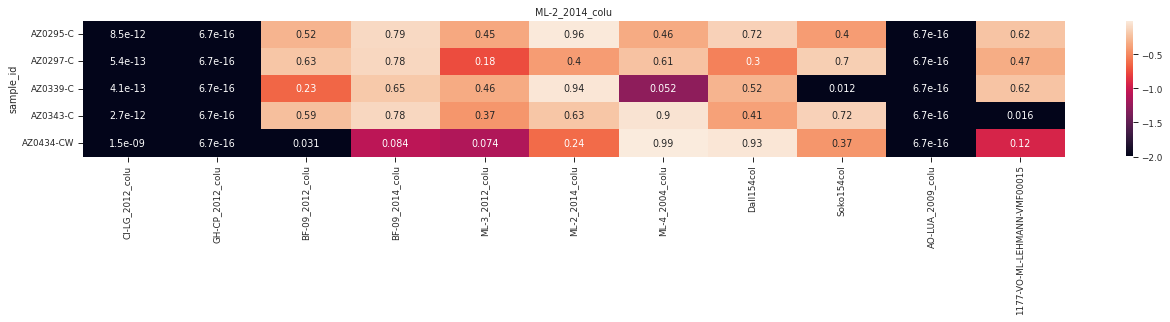

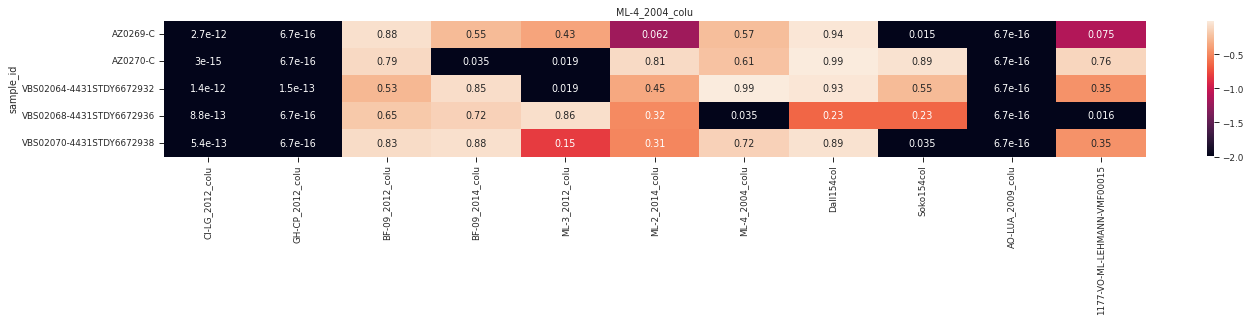

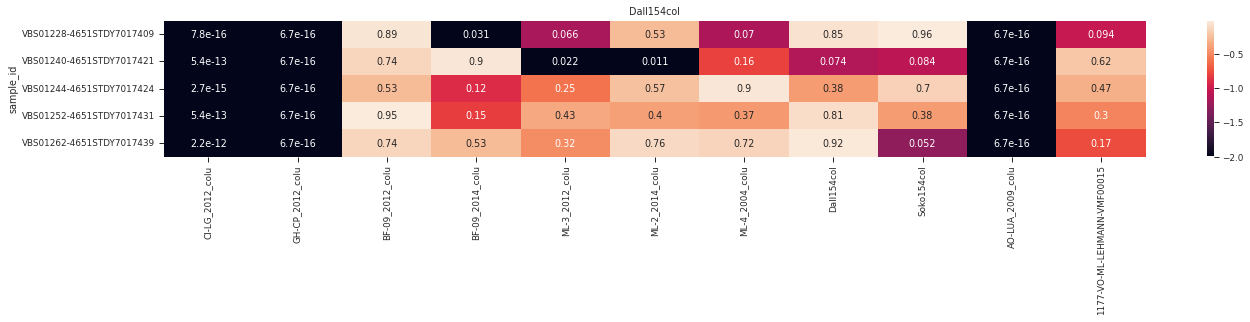

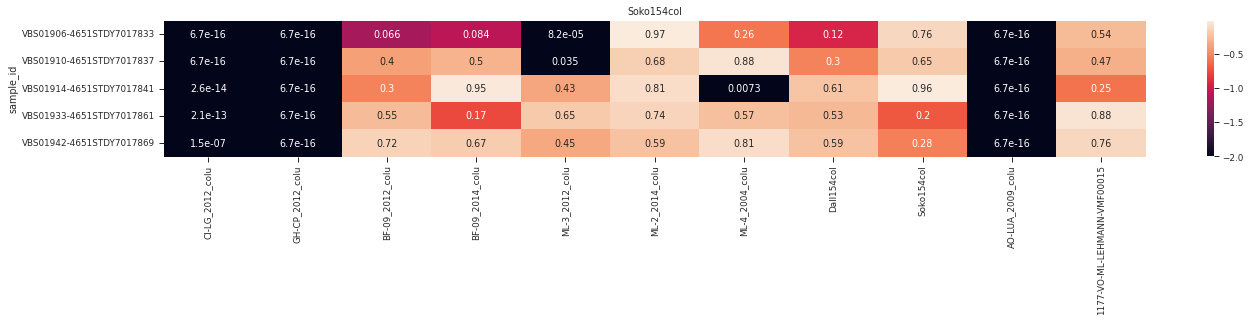

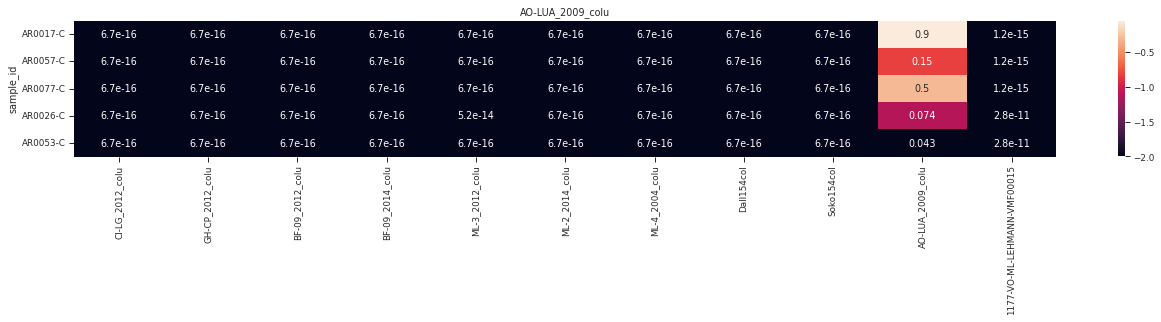

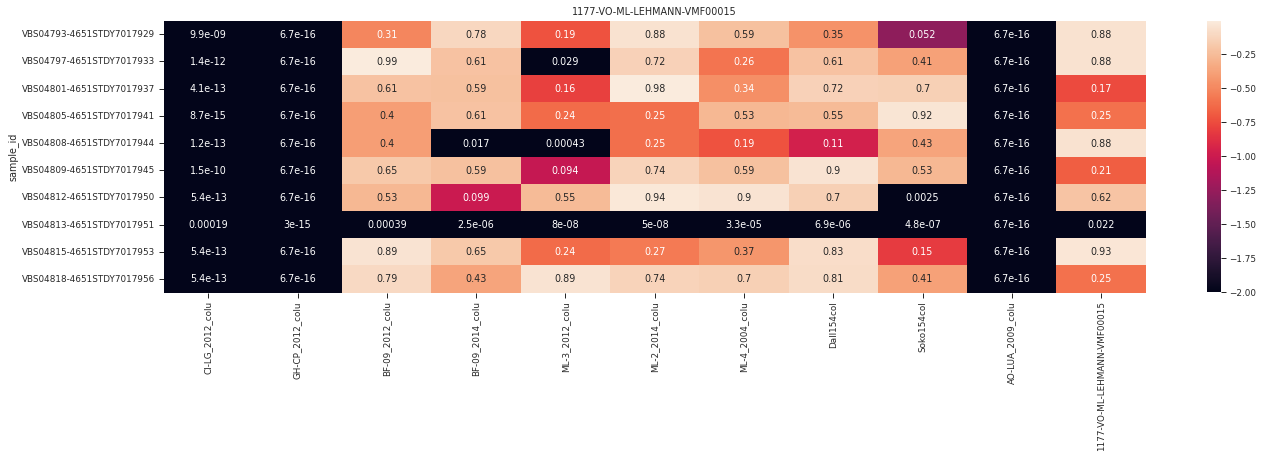

In [104]:
for pop in colu_cohorts_ext + ["1177-VO-ML-LEHMANN-VMF00015"]:
    heatmap_compare_short(pop, colu_cohorts_ext + ["1177-VO-ML-LEHMANN-VMF00015"]
                          , colu_cohorts_ball_idx_query, colu_cohorts_ball_idx_ref, colu_ssidx_all, pairwise_dbl);

In [62]:
n_query

23

In [159]:
cohorts_ball_idx_ref = cohorts_idx_ref#{pop: sorted(random.sample(cohorts_idx[pop], n_ref)) for pop in cohorts_red}
cohorts_ball_idx_ref['1177-VO-ML-LEHMANN-VMF00015'] = []
gamb_cohorts_ball_idx_ref = gamb_cohorts_idx_ref#{pop: sorted(random.sample(gamb_cohorts_idx[pop], n_ref)) for pop in gamb_cohorts}
gamb_cohorts_ball_idx_ref['1177-VO-ML-LEHMANN-VMF00015'] = []
colu_cohorts_ball_idx_ref = colu_cohorts_idx_ref_ext#{pop: sorted(random.sample(colu_cohorts_idx[pop], n_ref)) for pop in colu_cohorts}
colu_cohorts_ball_idx_ref['1177-VO-ML-LEHMANN-VMF00015'] = []

In [107]:
sidx_ref = list(itertools.chain(*cohorts_ball_idx_ref.values()))
gamb_sidx_ref = list(itertools.chain(*gamb_cohorts_ball_idx_ref.values()))
colu_sidx_ref = list(itertools.chain(*colu_cohorts_ball_idx_ref.values()))

In [108]:
len(colu_sidx_ref)

200

In [109]:
sidx_all = sidx_ref + ball_idx_ref + ball_idx_query
gamb_sidx_all = gamb_sidx_ref + ball_idx_ref + ball_idx_query
colu_sidx_all = colu_sidx_ref + ball_idx_ref + ball_idx_query

ssidx_all = sorted(sidx_all)
gamb_ssidx_all = sorted(gamb_sidx_all)
colu_ssidx_all = sorted(colu_sidx_all)

In [167]:
cohorts_ball_idx_ref_query = {pop: cohorts_ball_idx_ref[pop] + sorted(ball_idx_query + ball_idx_ref) for pop in cohorts_red}
gamb_cohorts_ball_idx_ref_query = {pop: gamb_cohorts_ball_idx_ref[pop] + sorted(ball_idx_query + ball_idx_ref) for pop in gamb_cohorts}
colu_cohorts_ball_idx_ref_query = {pop: colu_cohorts_ball_idx_ref[pop] + sorted(ball_idx_query + ball_idx_ref) for pop in colu_cohorts_ext}

In [169]:
pop, colu_cohorts_ball_idx_ref_query[pop]

('Dall154col',
 [3276,
  3278,
  3280,
  3282,
  3284,
  3286,
  3288,
  3289,
  3292,
  3294,
  3295,
  3298,
  3300,
  3309,
  3310,
  3312,
  3313,
  3316,
  3318,
  3320,
  3729,
  3730,
  3731,
  3732,
  3733,
  3734,
  3735,
  3736,
  3737,
  3738,
  3739,
  3740,
  3741,
  3742,
  3743,
  3744,
  3745,
  3746,
  3747,
  3748,
  3749,
  3750,
  3751])

In [170]:
loc_dbl_3R = load_dbl_pos('3R', 'gamb_colu', colu_ssidx_all, sample_sets=['v3','v3.1',"1177-VO-ML-LEHMANN-VMF00015"])

load and subset genotypes
count hom alt genotypes
count alleles
filter for missingness
locate doubletons


In [171]:
loc_dbl_3L = load_dbl_pos('3L', 'gamb_colu', colu_ssidx_all, sample_sets=['v3','v3.1',"1177-VO-ML-LEHMANN-VMF00015"])

load and subset genotypes
count hom alt genotypes
count alleles
filter for missingness
locate doubletons


In [172]:
len(colu_cohorts_ball_idx_ref[pop]), len(sorted(ball_idx_query + ball_idx_ref)), len(colu_cohorts_ball_idx_ref_query[pop]), n_ref+n_query

(20, 23, 43, 43)

In [173]:
len(pairwise_dbl)

903

In [174]:
n_pop_ref = len(colu_cohorts_ext)
n_q_samples = n_query
score_all = np.zeros((n_q_samples, len(colu_cohorts_ext)))
p_val_all = np.zeros((n_q_samples, len(colu_cohorts_ext)))


gt_3R = allel.GenotypeDaskArray(ag3.snp_genotypes(contig='3R', sample_sets=['v3','v3.1',"1177-VO-ML-LEHMANN-VMF00015"], site_mask='gamb_colu'))
gt_3L = allel.GenotypeDaskArray(ag3.snp_genotypes(contig='3L', sample_sets=['v3','v3.1',"1177-VO-ML-LEHMANN-VMF00015"], site_mask='gamb_colu'))


for j, pop in enumerate(colu_cohorts_ext):
#j = 0
#pop = cohorts_red[-2]
    genotype_sub_3R = gt_3R.take(colu_cohorts_ball_idx_ref_query[pop], axis=1)
    genotype_sub_3L = gt_3L.take(colu_cohorts_ball_idx_ref_query[pop], axis=1)
    genotype_dbl_3R = genotype_sub_3R.compress(loc_dbl_3R, axis=0)
    genotype_dbl_3L = genotype_sub_3L.compress(loc_dbl_3L, axis=0)
    gn_dbl_3R = genotype_dbl_3R.to_n_alt().compute()
    gn_dbl_3L = genotype_dbl_3L.to_n_alt().compute()
    pairwise_dbl_3R = allel.pairwise_distance(gn_dbl_3R, _dbl_count, chunked=True)
    pairwise_dbl_3L = allel.pairwise_distance(gn_dbl_3L, _dbl_count, chunked=True)
    pairwise_dbl = pairwise_dbl_3R + pairwise_dbl_3L
    for i, idx in enumerate(list(range(n_ref, n_ref+n_query))):
        score, p_val = stats.kstest(pairwise_dbl[allel.condensed_coords_between([idx], list(range(0,n_ref)), n_ref+n_query)],
                                    pairwise_dbl[allel.condensed_coords_within(list(range(0,n_ref)), n_ref+n_query)])
        score_all[i,j], p_val_all[i,j] = min(score, .45), p_val

In [175]:
pairwise_dbl_3R[allel.condensed_coords_between([22], list(range(0,n_ref)), n_ref+n_query)]

array([25., 17., 23., 29., 17.,  9., 16., 23., 19., 12., 19., 14., 12.,
       13., 19., 24., 19., 19., 46., 31.])

(array([4., 2., 7., 3., 0., 2., 1., 0., 0., 1.]),
 array([20. , 25.7, 31.4, 37.1, 42.8, 48.5, 54.2, 59.9, 65.6, 71.3, 77. ]),
 <BarContainer object of 10 artists>)

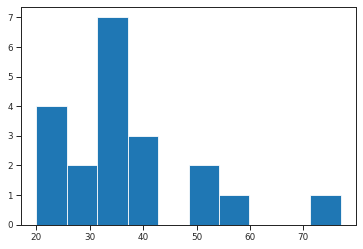

In [176]:
plt.hist(pairwise_dbl[allel.condensed_coords_between([22], list(range(0,n_ref)), n_ref+n_query)])

(array([1., 2., 2., 3., 5., 3., 2., 0., 0., 2.]),
 array([ 4. ,  6.1,  8.2, 10.3, 12.4, 14.5, 16.6, 18.7, 20.8, 22.9, 25. ]),
 <BarContainer object of 10 artists>)

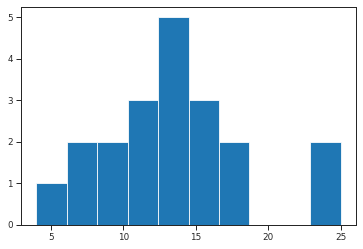

In [177]:
plt.hist(pairwise_dbl[allel.condensed_coords_between([23], list(range(0,n_ref)), n_ref+n_query)])

In [178]:
stats.kstest(pairwise_dbl[allel.condensed_coords_between([22], list(range(0,n_ref)), n_ref+n_query)],
             pairwise_dbl[allel.condensed_coords_within(list(range(0,n_ref)), n_ref+n_query)])

KstestResult(statistic=1.0, pvalue=6.661338147750939e-16)

In [179]:
stats.kstest(pairwise_dbl[allel.condensed_coords_between([30], list(range(0,n_ref)), n_ref+n_query)],
             pairwise_dbl[allel.condensed_coords_within(list(range(0,n_ref)), n_ref+n_query)])

KstestResult(statistic=1.0, pvalue=6.661338147750939e-16)

In [180]:
stats.kstest(pairwise_dbl[allel.condensed_coords_between([30], list(range(0,n_ref)), n_ref+n_query)][pairwise_dbl[allel.condensed_coords_between([30], list(range(0,n_ref)), n_ref+n_query)] < 600],
             pairwise_dbl[allel.condensed_coords_within(list(range(0,n_ref)), n_ref+n_query)])

KstestResult(statistic=1.0, pvalue=6.661338147750939e-16)

In [181]:
stats.kstest(pairwise_dbl[allel.condensed_coords_between([32], list(range(0,n_ref)), n_ref+n_query)],
             pairwise_dbl[allel.condensed_coords_between([33], list(range(0,n_ref)), n_ref+n_query)])

KstestResult(statistic=0.35, pvalue=0.17453300569806826)

In [182]:
log_data = np.where(p_val_all < .05, -2, np.log10(p_val_all))

<AxesSubplot:ylabel='sample_id'>

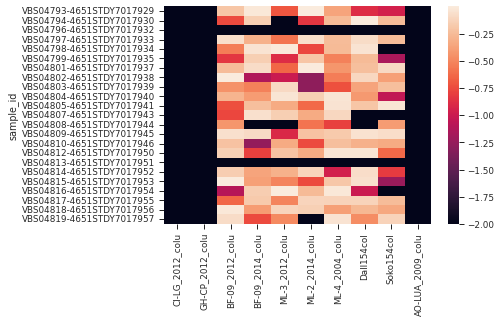

In [184]:
sns.heatmap(pd.DataFrame(data=log_data, index=df_balloon.sample_id, columns=colu_cohorts_ext))#, annot=p_val_all)

In [124]:
for i, sid in enumerate(df_balloon.sample_id):
    print(sid + ": [" + ", ".join(cohorts_red[p_val_all[i] > .5]) + "]")

TypeError: only integer scalar arrays can be converted to a scalar index

In [84]:
loc_dbl_3R = load_dbl_pos('3R', 'gamb_colu', gamb_ssidx_all, sample_sets=['v3',"1177-VO-ML-LEHMANN-MNF00004"])

load and subset genotypes
count hom alt genotypes
count alleles
filter for missingness
locate doubletons


In [85]:
loc_dbl_3L = load_dbl_pos('3L', 'gamb_colu', gamb_ssidx_all, sample_sets=['v3',"1177-VO-ML-LEHMANN-MNF00004"])

load and subset genotypes
count hom alt genotypes
count alleles
filter for missingness
locate doubletons


In [86]:
n_pop_ref = len(gamb_cohorts)
n_q_samples = n_query
score_all = np.zeros((n_q_samples, len(gamb_cohorts)))
p_val_all = np.zeros((n_q_samples, len(gamb_cohorts)))


gt_3R = allel.GenotypeDaskArray(ag3.snp_genotypes(contig='3R', sample_sets=['v3',"1177-VO-ML-LEHMANN-MNF00004"], site_mask='gamb_colu'))
gt_3L = allel.GenotypeDaskArray(ag3.snp_genotypes(contig='3L', sample_sets=['v3',"1177-VO-ML-LEHMANN-MNF00004"], site_mask='gamb_colu'))


for j, pop in enumerate(gamb_cohorts):
    genotype_sub_3R = gt_3R.take(gamb_cohorts_ball_idx_ref_query[pop], axis=1)
    genotype_sub_3L = gt_3L.take(gamb_cohorts_ball_idx_ref_query[pop], axis=1)
    genotype_dbl_3R = genotype_sub_3R.compress(loc_dbl_3R, axis=0)
    genotype_dbl_3L = genotype_sub_3L.compress(loc_dbl_3L, axis=0)
    gn_dbl_3R = genotype_dbl_3R.to_n_alt().compute()
    gn_dbl_3L = genotype_dbl_3L.to_n_alt().compute()
    pairwise_dbl_3R = allel.pairwise_distance(gn_dbl_3R, _dbl_count, chunked=True)
    pairwise_dbl_3L = allel.pairwise_distance(gn_dbl_3L, _dbl_count, chunked=True)
    pairwise_dbl = pairwise_dbl_3R + pairwise_dbl_3L
    for i, idx in enumerate(list(range(n_ref, n_ref+n_query))):
        score, p_val = stats.kstest(pairwise_dbl[allel.condensed_coords_between([idx], list(range(0,n_ref)), n_ref+n_query)],
                                    pairwise_dbl[allel.condensed_coords_within(list(range(0,n_ref)), n_ref+n_query)])
        score_all[i,j], p_val_all[i,j] = min(score, .45), p_val

<AxesSubplot:ylabel='sample_id'>

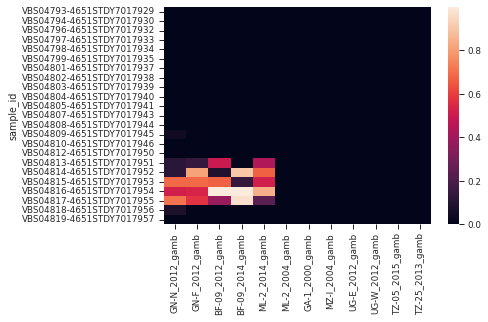

In [87]:
sns.heatmap(pd.DataFrame(data=p_val_all, index=df_balloon.sample_id, columns=gamb_cohorts))

In [ ]:
for i, sid in enumerate(df_balloon.sample_id):
    print(sid + ": [" + ", ".join(gamb_cohorts[p_val_all[i] > .5]) + "]")

In [ ]:
loc_dbl_3R = load_dbl_pos('3R', 'gamb_colu', colu_ssidx_all, sample_sets=['v3',"1177-VO-ML-LEHMANN-MNF00004"])

In [ ]:
loc_dbl_3L = load_dbl_pos('3L', 'gamb_colu', colu_ssidx_all, sample_sets=['v3',"1177-VO-ML-LEHMANN-MNF00004"])

In [ ]:
n_pop_ref = len(colu_cohorts)
n_q_samples = n_query
score_all = np.zeros((n_q_samples, len(colu_cohorts)))
p_val_all = np.zeros((n_q_samples, len(colu_cohorts)))


gt_3R = allel.GenotypeDaskArray(ag3.snp_genotypes(contig='3R', sample_sets=['v3',"1177-VO-ML-LEHMANN-MNF00004"], site_mask='gamb_colu'))
gt_3L = allel.GenotypeDaskArray(ag3.snp_genotypes(contig='3L', sample_sets=['v3',"1177-VO-ML-LEHMANN-MNF00004"], site_mask='gamb_colu'))


for j, pop in enumerate(colu_cohorts):
    genotype_sub_3R = gt_3R.take(colu_cohorts_ball_idx_ref_query[pop], axis=1)
    genotype_sub_3L = gt_3L.take(colu_cohorts_ball_idx_ref_query[pop], axis=1)
    genotype_dbl_3R = genotype_sub_3R.compress(loc_dbl_3R, axis=0)
    genotype_dbl_3L = genotype_sub_3L.compress(loc_dbl_3L, axis=0)
    gn_dbl_3R = genotype_dbl_3R.to_n_alt().compute()
    gn_dbl_3L = genotype_dbl_3L.to_n_alt().compute()
    pairwise_dbl_3R = allel.pairwise_distance(gn_dbl_3R, _dbl_count, chunked=True)
    pairwise_dbl_3L = allel.pairwise_distance(gn_dbl_3L, _dbl_count, chunked=True)
    pairwise_dbl = pairwise_dbl_3R + pairwise_dbl_3L
    for i, idx in enumerate(list(range(n_ref, n_ref+n_query))):
        score, p_val = stats.kstest(pairwise_dbl[allel.condensed_coords_between([idx], list(range(0,n_ref)), n_ref+n_query)],
                                    pairwise_dbl[allel.condensed_coords_within(list(range(0,n_ref)), n_ref+n_query)])
        score_all[i,j], p_val_all[i,j] = min(score, .45), p_val

In [ ]:
sns.heatmap(pd.DataFrame(data=p_val_all, index=df_balloon.sample_id, columns=colu_cohorts))

In [ ]:
for i, sid in enumerate(df_balloon.sample_id):
    print(sid + ": [" + ", ".join(colu_cohorts[p_val_all[i] > .5]) + "]")

In [ ]:
n_pop_ref = len(cohorts_red)
n_q_samples = n_query
score_all = np.zeros((n_q_samples, len(cohorts_red)))
p_val_all = np.zeros((n_q_samples, len(cohorts_red)))


gt_3R = allel.GenotypeDaskArray(ag3.snp_genotypes(contig='3R', sample_sets=['v3',"1177-VO-ML-LEHMANN-MNF00004"], site_mask='gamb_colu'))
#gt_3L = allel.GenotypeDaskArray(ag3.snp_genotypes(contig='3L', sample_sets=['v3',"1177-VO-ML-LEHMANN-MNF00004"], site_mask='gamb_colu'))


for j, pop in enumerate(cohorts_red):
    genotype_sub_3R = gt_3R.take(cohorts_ball_idx_ref_query[pop], axis=1)
    #genotype_sub_3L = gt_3L.take(cohorts_ball_idx_ref_query[pop], axis=1)
    genotype_dbl_3R = genotype_sub_3R.compress(loc_dbl_3R, axis=0)
    #genotype_dbl_3L = genotype_sub_3L.compress(loc_dbl_3L, axis=0)
    gn_dbl_3R = genotype_dbl_3R.to_n_alt().compute()
    #gn_dbl_3L = genotype_dbl_3L.to_n_alt().compute()
    pairwise_dbl_3R = allel.pairwise_distance(gn_dbl_3R, _dbl_count, chunked=True)
    #pairwise_dbl_3L = allel.pairwise_distance(gn_dbl_3L, _dbl_count, chunked=True)
    pairwise_dbl = pairwise_dbl_3R# + pairwise_dbl_3L
    for i, idx in enumerate(list(range(n_ref, n_ref+n_query))):
        score, p_val = stats.kstest(pairwise_dbl[allel.condensed_coords_between([idx], list(range(0,n_ref)), n_ref+n_query)],
                                    pairwise_dbl[allel.condensed_coords_within(list(range(0,n_ref)), n_ref+n_query)])
        score_all[i,j], p_val_all[i,j] = min(score, .45), p_val

In [ ]:
sns.heatmap(pd.DataFrame(data=p_val_all, index=df_balloon.sample_id, columns=cohorts_red))

In [ ]:
for i, sid in enumerate(df_balloon.sample_id):
    print(sid + ": [" + ", ".join(cohorts_red[p_val_all[i] > .5]) + "]")

In [ ]:
n_pop_ref = len(cohorts_red)
n_q_samples = n_query
score_all = np.zeros((n_q_samples, len(cohorts_red)))
p_val_all = np.zeros((n_q_samples, len(cohorts_red)))


#gt_3R = allel.GenotypeDaskArray(ag3.snp_genotypes(contig='3R', sample_sets=['v3',"1177-VO-ML-LEHMANN-MNF00004"], site_mask='gamb_colu'))
gt_3L = allel.GenotypeDaskArray(ag3.snp_genotypes(contig='3L', sample_sets=['v3',"1177-VO-ML-LEHMANN-MNF00004"], site_mask='gamb_colu'))


for j, pop in enumerate(cohorts_red):
    #genotype_sub_3R = gt_3R.take(cohorts_ball_idx_ref_query[pop], axis=1)
    genotype_sub_3L = gt_3L.take(cohorts_ball_idx_ref_query[pop], axis=1)
    #genotype_dbl_3R = genotype_sub_3R.compress(loc_dbl_3R, axis=0)
    genotype_dbl_3L = genotype_sub_3L.compress(loc_dbl_3L, axis=0)
    #gn_dbl_3R = genotype_dbl_3R.to_n_alt().compute()
    gn_dbl_3L = genotype_dbl_3L.to_n_alt().compute()
    #pairwise_dbl_3R = allel.pairwise_distance(gn_dbl_3R, _dbl_count, chunked=True)
    pairwise_dbl_3L = allel.pairwise_distance(gn_dbl_3L, _dbl_count, chunked=True)
    pairwise_dbl = pairwise_dbl_3L
    for i, idx in enumerate(list(range(n_ref, n_ref+n_query))):
        score, p_val = stats.kstest(pairwise_dbl[allel.condensed_coords_between([idx], list(range(0,n_ref)), n_ref+n_query)],
                                    pairwise_dbl[allel.condensed_coords_within(list(range(0,n_ref)), n_ref+n_query)])
        score_all[i,j], p_val_all[i,j] = min(score, .45), p_val

In [ ]:
sns.heatmap(pd.DataFrame(data=p_val_all, index=df_balloon.sample_id, columns=cohorts_red))

In [ ]:
for i, sid in enumerate(df_balloon.sample_id):
    print(sid + ": [" + ", ".join(cohorts_red[p_val_all[i] > .5]) + "]")

In [ ]:
pca = PCA(n_components=2)

In [ ]:
plt.scatter(pca.fit(p_val_all).transform(p_val_all)[:,0], pca.fit(p_val_all).transform(p_val_all)[:,1])

## Sorted

In [ ]:
pairwise_dbl_3R, loc_dbl_3R = count_pairwise_doubletons('3R', 'gamb_colu', ssidx, "v3")

In [ ]:
pairwise_dbl_3L, loc_dbl_3L = count_pairwise_doubletons('3L', 'gamb_colu', ssidx, "v3")

In [ ]:
pairwise_dbl = pairwise_dbl_3L + pairwise_dbl_3R

In [ ]:
df_samples_sub = pd.concat([ag3.sample_cohorts()[ag3.sample_cohorts().index.isin(cohorts_idx_ref_query[p])] for p in cohorts_red])

In [ ]:
df_samples_sub.reset_index(drop=True, inplace=True)
df_samples_sub

In [ ]:
cohorts_sub_idx_query = {pop: df_samples_sub[df_samples_sub.sample_id.isin(list(ag3.sample_cohorts()[ag3.sample_cohorts().index.isin(cohorts_idx_query[pop])].sample_id))].index for pop in cohorts_red}
cohorts_sub_idx_ref = {pop: df_samples_sub[df_samples_sub.sample_id.isin(list(ag3.sample_cohorts()[ag3.sample_cohorts().index.isin(cohorts_idx_ref[pop])].sample_id))].index for pop in cohorts_red}
cohorts_sub_idx_ref_query = {pop: df_samples_sub[df_samples_sub.sample_id.isin(list(ag3.sample_cohorts()[ag3.sample_cohorts().index.isin(cohorts_idx_ref_query[pop])].sample_id))].index for pop in cohorts_red}

In [ ]:
for pop in cohorts_red:
    heatmap_compare_short(pop);

In [ ]:
den = np.sum(high_match_proba[0:10], axis = 1)
den

In [ ]:
len(cohorts_sub_idx_query)

In [ ]:
len(list(itertools.chain(*cohorts_sub_idx_query.values())))

In [ ]:
df_samples_sub[df_samples_sub.sample_id.isin(list(ag3.sample_cohorts()[ag3.sample_cohorts().index.isin(cohorts_idx_query['AO-LUA_2009_colu'])].sample_id))]

In [ ]:
df_samples_sub[df_samples_sub.sample_id.isin(list(ag3.sample_cohorts()[ag3.sample_cohorts().index.isin(cohorts_idx_ref['AO-LUA_2009_colu'])].sample_id))]

In [ ]:
cohorts_red

In [ ]:
n_pop_ref = len(cohorts_red)
n_q_samples = len(sidx)
score_all = np.zeros((n_q_samples, n_pop_ref))
p_val_all = np.zeros((n_q_samples, n_pop_ref))

for i in range(0,n_q_samples):
    for j, pop in enumerate(cohorts_red):
        pop_elem_idxs = list(cohorts_sub_idx_ref_query[pop].index)
        if i in list(cohorts_sub_idx_ref_query[pop].index):
            pop_elem_idxs.remove(i)

        score, p_val = stats.kstest(pairwise_dbl[allel.condensed_coords_between([i], pop_elem_idxs, len(sidx))],
                                    pairwise_dbl[allel.condensed_coords_within(pop_elem_idxs, len(sidx))])
        score_all[i,j], p_val_all[i,j] = min(score, .45), p_val

In [ ]:
len(list(itertools.chain(*cohorts_sub_idx_query.values())))

In [ ]:
if 0 in list(cohorts_sub_idx_ref_query['AO-LUA_2009_colu'].index):
    pop_elem_idx = list(cohorts_sub_idx_ref_query['AO-LUA_2009_colu'].index).remove(0)
else:
    pop_elem_idx = list(cohorts_sub_idx_ref_query['AO-LUA_2009_colu'].index)

In [ ]:
list(cohorts_sub_idx_ref_query['AO-LUA_2009_colu'].index)

In [ ]:
score, p_val = estimate_cohort_assignment_precision()

In [ ]:
p_val

In [ ]:
high_match_proba = p_val > .50

In [ ]:
den = np.sum(high_match_proba[0:10], axis = 1)
den

In [ ]:
high_match_proba[0:10][:,0]

In [ ]:
high_match_proba[0:10][:,0] / den

In [ ]:
class_score = np.zeros((len(cohorts_red), len(cohorts_red)))

In [ ]:
for i in range(0,len(cohorts_red)):
    den = np.sum(high_match_proba[i*10:(i+1)*10], axis = 1)
    for j in range(0,len(cohorts_red)):
        class_score[i,j] = np.nansum(high_match_proba[i*10:(i+1)*10][:,j] / den)

In [ ]:
class_score[1], cohorts_red

In [ ]:
sns.heatmap(pd.DataFrame(data=class_score[1], index=cohorts_red))

In [ ]:
sns.heatmap(pd.DataFrame(data=class_score, index = cohorts_red, columns=cohorts_red))

In [ ]:
for pop in cohorts_red:
    heatmap_compare_short(pop);

In [ ]:
heatmap_compare_short('BF-09_2012_gamb')

In [ ]:
heatmap_compare_short('BF-09_2012_colu')

In [ ]:
heatmap_compare_short('BF-09_2014_colu')

In [ ]:
heatmap_compare_short('BF-09_2014_gamb')

In [ ]:
heatmap_compare_short('CD-NU_2015_gamb')

In [ ]:
heatmap_compare_short('CF-BGF_1994_gamb')

In [ ]:
heatmap_compare_short('CI-LG_2012_colu')

In [ ]:
heatmap_compare_short('CM-ES_2009_gamb')

In [ ]:
n_pop_ref = len(cohorts_red)
n_q_samples = len(cohorts_sub_idx_query['UG-W_2012_gamb'])
score_all = np.zeros((n_q_samples, n_pop_ref))
p_val_all = np.zeros((n_q_samples, n_pop_ref))

for i, idx in enumerate(list(cohorts_sub_idx_query['UG-W_2012_gamb'].index)):
    for j, pop in enumerate(cohorts_red):
        #print(pop)
        score, p_val = stats.kstest(pairwise_dbl[allel.condensed_coords_between([idx], list(cohorts_sub_idx_ref[pop].index), len(sidx))],
                                    pairwise_dbl[allel.condensed_coords_within(list(cohorts_sub_idx_ref[pop].index), len(sidx))])
        score_all[i,j], p_val_all[i,j] = min(score, .45), p_val

score_all_df = pd.DataFrame(data=score_all, index=cohorts_sub_idx_query['UG-W_2012_gamb'].sample_id, columns=cohorts_red)

fig, ax = plt.subplots(figsize=(n_pop_ref*2,n_q_samples/4.5))  
sns.heatmap(score_all_df, annot=p_val_all, ax=ax)

In [ ]:
genotype_sub = gt.take(sidx, axis=1)

In [ ]:
#with section('count genotypes'):
n_hom_alt = genotype_sub.count_hom_alt(axis=1).compute()

In [ ]:
#with section('count alleles'):
ac_sub = genotype_sub.count_alleles(max_allele=3).compute()

In [ ]:
no_miss = (genotype_sub.count_missing(axis = 1) == 0)

In [ ]:
#with section('locate doubletons'):
    # use only ALT doubletons, ignore REF doubletons as very few
loc_dbl = (np.sum(ac_sub[:,1:], axis=1) == 2) & ((ac_sub[:, 1] == 2) | (ac_sub[:, 2] == 2) | (ac_sub[:, 3] == 2)) & (n_hom_alt == 0)

In [ ]:
#with section('compress genotypes to doubletons'):
miss_genotype_dbl = genotype_sub.compress(loc_dbl & no_miss, axis=0)

In [ ]:
gn_dbl = miss_genotype_dbl.to_n_alt().compute()
print("Number of positions kept: " + str(miss_genotype_dbl.shape[0]))

In [ ]:
gt.take(list(sample_cohorts_red.index), axis=1)

In [ ]:
df_meta = ag3.sample_metadata(sample_sets=["1177-VO-ML-LEHMANN-MNF00004"])
df_colu = df_meta[df_meta.species == 'coluzzii']

In [ ]:
df_colu['population'] = [str(list(df_colu.location)[i]) + str(list(df_colu.year)[i]) for i in range(0,len(list(df_colu.location)))]

In [ ]:
df_colu.population

In [ ]:
df_colu.population.value_counts()

In [ ]:
colu_populations  = list(df_colu.population.unique())

In [ ]:
df_colu_no_12 = df_colu[df_colu.year != 2012]
colu_no_12_populations = list(df_colu_no_12.population.unique())
colu_no_12_populations

# Data setup - Test 3.0 - gamb

In [ ]:
df_meta = ag3.sample_metadata()
df_meta

In [ ]:
df_gamb = df_meta[df_meta.species == 'gambiae']
df_gamb

In [ ]:
df_gamb['population'] = df_gamb['country']

In [ ]:
df_gamb.population.value_counts()

In [ ]:
gamb_populations = list(df_gamb.population.unique())

# Data setup - Test 3.0 - west

In [ ]:
sample_sets_west = ["AG1000G-CM-A", "AG1000G-CM-B", "AG1000G-CM-C",
                    "AG1000G-BF-A", "AG1000G-BF-B", "AG1000G-BF-C", #"AG1000G-CI",
                    "AG1000G-CD", "AG1000G-CF", #"AG1000G-GA-A",
                    "AG1000G-ML-A", "AG1000G-ML-B", "AG1000G-GH"
                    ]
df_west_all = ag3.sample_metadata(sample_sets=sample_sets_west)
df_west = df_west_all[df_west_all.species_gambcolu_arabiensis == 'gamb_colu']
df_west

In [ ]:
df_west_country = ag3.sample_metadata(sample_sets=sample_sets_west)
df_west_country = df_west_country[df_west_country.species_gambcolu_arabiensis == 'gamb_colu']
df_west_country['population'] = df_west['country']

In [ ]:
df_west['population'] = df_west['country'] + " " + df_west['species']

In [ ]:
df_west_pop_counts = df_west.population.value_counts()
df_west_pop_counts

In [ ]:
df_west_country_pop_counts = df_west_country.population.value_counts()
df_west_country_pop_counts

In [ ]:
df_west

In [ ]:
df_west = df_west[df_west.population.isin(df_west_pop_counts[df_west_pop_counts >= 13].index)]
df_west

In [ ]:
df_west[df_west.country == "Cameroon"]

In [ ]:
west_populations = list(df_west.population.unique())
west_populations

In [ ]:
## Populations that should be investigated
west_populations.remove('Cameroon coluzzii')
west_populations.remove('Ghana gambiae')
west_populations

In [ ]:
west_country_populations = list(df_west_country.population.unique())
west_country_populations

# Data setup - Test 3.0 - west + balloon

In [ ]:
sample_sets_west_balloon = ["AG1000G-CM-A", "AG1000G-CM-B", "AG1000G-CM-C",
                    "AG1000G-BF-A", "AG1000G-BF-B", "AG1000G-BF-C", #"AG1000G-CI",
                    "AG1000G-CD", "AG1000G-CF", #"AG1000G-GA-A",
                    "AG1000G-ML-A", "AG1000G-ML-B", "AG1000G-GH",
                    #"1177-VO-ML-LEHMANN-VMF00015"
                    ]

In [ ]:
df_west_no_balloon = ag3.sample_metadata(sample_sets=sample_sets_west_balloon)
df_west_no_balloon_gacol = df_west_no_balloon[df_west_no_balloon.species_gambcolu_arabiensis == 'gamb_colu']
df_west_no_balloon

In [ ]:
df_west_no_balloon_gacol['population'] = df_west_no_balloon_gacol['country'] + " " + df_west_no_balloon_gacol['species']

In [ ]:
df_balloon = ag3.sample_metadata(sample_sets="1177-VO-ML-LEHMANN-VMF00015")
df_balloon['population'] = "Balloon"

In [ ]:
df_west_no_balloon_gacol

In [ ]:
df_west_balloon_gacol_pop_counts = df_west_no_balloon_gacol.population.value_counts()
df_west_balloon_gacol_pop_counts

In [ ]:
df_west_balloon_gacol = df_west_no_balloon_gacol[df_west_no_balloon_gacol.population.isin(df_west_balloon_gacol_pop_counts[df_west_balloon_gacol_pop_counts >= 23].index)]
df_west_balloon_gacol

In [ ]:
west_balloon_gacol_populations = list(df_west_balloon_gacol.population.unique())
west_balloon_gacol_populations

# Data setup - Test 3.0 - check

In [ ]:
sample_sets_check = ["AG1000G-CM-A", "AG1000G-CM-B", "AG1000G-CM-C",
                    "AG1000G-BF-A", "AG1000G-BF-B", "AG1000G-BF-C", "AG1000G-CI",
                    "AG1000G-CD", #"AG1000G-CF",
                    "AG1000G-GA-A",
                    "AG1000G-ML-A", "AG1000G-ML-B", "AG1000G-GH",
                    #"1177-VO-ML-LEHMANN-VMF00015"
                    ]

In [ ]:
df_pre_check = ag3.sample_metadata(sample_sets=sample_sets_check)#"1177-VO-ML-LEHMANN-VMF00015"
df_pre_check = df_pre_check[df_pre_check.species_gambcolu_arabiensis == 'gamb_colu']
df_pre_check

In [ ]:
df_pre_check['population'] = df_pre_check['country'] + " " + df_pre_check['species']

In [ ]:
df_cf = ag3.sample_metadata(sample_sets="AG1000G-CF")
df_cf['population'] = "Centrafrique"

In [ ]:
df_check = df_pre_check

In [ ]:
df_check_pop_counts = df_check.population.value_counts()
df_check_pop_counts

In [ ]:
df_check = df_check[df_check.population.isin(df_check_pop_counts[df_check_pop_counts >= 26].index)]
df_check

In [ ]:
check_populations = list(df_check.population.unique())
check_populations

## Test BF-A

In [ ]:
sample_sets_cm_a_check = ["AG1000G-CM-A",
                    "AG1000G-CM-B", "AG1000G-CM-C",
                    #"AG1000G-BF-A",
                    "AG1000G-BF-B", "AG1000G-BF-C", "AG1000G-CI",
                    "AG1000G-CD", "AG1000G-CF",
                    "AG1000G-GA-A",
                    "AG1000G-ML-A", "AG1000G-ML-B", "AG1000G-GH"
                    ]

In [ ]:
df_cm_a_pre_check = ag3.sample_metadata(sample_sets=sample_sets_cm_a_check)
df_cm_a_pre_check = df_cm_a_pre_check[df_cm_a_pre_check.species_gambcolu_arabiensis == 'gamb_colu']
df_cm_a_pre_check

In [ ]:
df_cm_a_pre_check['population'] = df_cm_a_pre_check['country'] + " " + df_cm_a_pre_check['species']

In [ ]:
df_cm_a = ag3.sample_metadata(sample_sets="AG1000G-BF-A")
df_cm_a['population'] = "AG1000G-BF-A"

In [ ]:
df_cm_a_check_pop_counts = df_cm_a_pre_check.population.value_counts()
df_cm_a_check_pop_counts

In [ ]:
df_cm_a_check = df_cm_a_pre_check[df_cm_a_pre_check.population.isin(df_cm_a_check_pop_counts[df_cm_a_check_pop_counts >= 18].index)]
df_cm_a_check

In [ ]:
cm_a_check_populations = list(df_cm_a_check.population.unique())
cm_a_check_populations

## Location + Year - Lehmann - No 2012

In [ ]:
cmap = mpl.cm.get_cmap('Spectral')
pop_colors = [cmap(p/len(colu_no_12_populations)) for p in range(0,len(colu_no_12_populations))]

In [ ]:
sidx, sub_sidx, df_samples_sub, pairwise_dbl_3L, pairwise_dbl_3R = compute_doubleton_count(colu_no_12_populations, 14, df_colu_no_12, "1177-VO-ML-LEHMANN-MNF00004", pop_colors)

In [ ]:
n = df_samples_sub.shape[0]

pairwise_dbl = pairwise_dbl_3L + pairwise_dbl_3R

pop_i = []
within_dc = []
between_dc = []
pops_w = []
pops_b = []

for i, p in enumerate(colu_no_12_populations):
    pop_idx = list(df_samples_sub[df_samples_sub.population == p].index)
    pop_i.append(pop_idx)
    pidx_within = allel.condensed_coords_within(pop_idx, n)
    pops_w.append(["within " + colu_no_12_populations[i]] * len( pidx_within))
    within_dc.append(pairwise_dbl.take(pidx_within))
    for j in range(0,i):
        #print('i: ' + str(i) + ' ; j: ' + str(j))
        pidx_between = allel.condensed_coords_between(pop_idx, pop_i[j], n)
        pops_b.append(["between " + colu_no_12_populations[i] + " " + colu_no_12_populations[j]] * len(pidx_between))
        between_dc.append(pairwise_dbl.take(pidx_between))

In [ ]:
pops = np.concatenate([np.concatenate(pops_w), np.concatenate(pops_b)])

vals = np.concatenate([np.concatenate(within_dc), np.concatenate(between_dc)])


In [ ]:
d = {'Pops': pops, 'Dbl_val': vals}
dbl_df = pd.DataFrame(data=d) 

In [ ]:
dbl_df_low = dbl_df[dbl_df.Dbl_val < 250]
fig = px.histogram(dbl_df_low, x="Dbl_val", color="Pops")
fig.show()

In [ ]:
fig = px.violin(dbl_df, y="Dbl_val", color="Pops")
fig.show()

## Location + Year - Lehmann

In [ ]:
cmap = mpl.cm.get_cmap('Spectral')
pop_colors = [cmap(p/len(colu_populations)) for p in range(0,len(colu_populations))]

In [ ]:
sidx, sub_sidx, df_samples_sub, pairwise_dbl_3L, pairwise_dbl_3R = compute_doubleton_count(colu_populations, 14, df_colu, "1177-VO-ML-LEHMANN-MNF00004", pop_colors)

In [ ]:
n = df_samples_sub.shape[0]

pairwise_dbl = pairwise_dbl_3L + pairwise_dbl_3R

pop_i = []
within_dc = []
between_dc = []
pops_w = []
pops_b = []

for i, p in enumerate(colu_populations):
    pop_idx = list(df_samples_sub[df_samples_sub.population == p].index)
    pop_i.append(pop_idx)
    pidx_within = allel.condensed_coords_within(pop_idx, n)
    pops_w.append(["within " + colu_populations[i]] * len( pidx_within))
    within_dc.append(pairwise_dbl.take(pidx_within))
    for j in range(0,i):
        #print('i: ' + str(i) + ' ; j: ' + str(j))
        pidx_between = allel.condensed_coords_between(pop_idx, pop_i[j], n)
        pops_b.append(["between " + colu_populations[i] + " " + colu_populations[j]] * len(pidx_between))
        between_dc.append(pairwise_dbl.take(pidx_between))

In [ ]:
pops = np.concatenate([np.concatenate(pops_w), np.concatenate(pops_b)])

vals = np.concatenate([np.concatenate(within_dc), np.concatenate(between_dc)])


In [ ]:
d = {'Pops': pops, 'Dbl_val': vals}
dbl_df = pd.DataFrame(data=d) 

In [ ]:
dbl_df_low = dbl_df[dbl_df.Dbl_val < 250]
fig = px.histogram(dbl_df_low, x="Dbl_val", color="Pops")
fig.show()

In [ ]:
fig = px.violin(dbl_df, y="Dbl_val", color="Pops")
fig.show()

## Phase 3 - Test - west

In [ ]:
cmap = mpl.cm.get_cmap('Spectral')
pop_colors = [cmap(p/len(west_populations)) for p in range(0,len(west_populations))]

In [ ]:
sidx, sub_sidx, df_samples_sub, pairwise_dbl_3L, pairwise_dbl_3R = compute_doubleton_count(west_populations, 14, df_west, sample_sets_west, pop_colors, max_population_size=20)

In [ ]:
n = df_samples_sub.shape[0]

pairwise_dbl = pairwise_dbl_3L + pairwise_dbl_3R

pop_i = []
within_dc = []
between_dc = []
pops_w = []
pops_b = []

for i, p in enumerate(west_populations):
    pop_idx = list(df_samples_sub[df_samples_sub.population == p].index)
    pop_i.append(pop_idx)
    pidx_within = allel.condensed_coords_within(pop_idx, n)
    pops_w.append(["within " + west_populations[i]] * len( pidx_within))
    within_dc.append(pairwise_dbl.take(pidx_within))
    for j in range(0,i):
        #print('i: ' + str(i) + ' ; j: ' + str(j))
        pidx_between = allel.condensed_coords_between(pop_idx, pop_i[j], n)
        pops_b.append(["between " + west_populations[i] + " " + west_populations[j]] * len(pidx_between))
        between_dc.append(pairwise_dbl.take(pidx_between))

In [ ]:
pops = np.concatenate([np.concatenate(pops_w), np.concatenate(pops_b)])

vals = np.concatenate([np.concatenate(within_dc), np.concatenate(between_dc)])


d = {'Pops': pops, 'Dbl_val': vals}
dbl_df = pd.DataFrame(data=d) 

fig = px.histogram(dbl_df, x="Dbl_val", color="Pops", log_y=True)
fig.show()

In [ ]:
fig = px.violin(dbl_df, y="Dbl_val", color="Pops", log_y=True)
fig.show()

In [ ]:
fig = px.violin(dbl_df, y="Dbl_val", color="Pops")
fig.show()

## Phase 3 - Test - west + balloon

In [ ]:
cmap = mpl.cm.get_cmap('Spectral')
pop_colors = [cmap(p/len(west_balloon_gacol_populations)) for p in range(0,len(west_balloon_gacol_populations))]

In [ ]:
sidx, sub_sidx, df_samples_sub, pairwise_dbl_3L, pairwise_dbl_3R, loc_dbl_3L, loc_dbl_3R = compute_doubleton_count(west_balloon_gacol_populations,
                                                                                           "1177-VO-ML-LEHMANN-VMF00015",
                                                                                           14, 
                                                                                           df_west_balloon_gacol, 
                                                                                           df_balloon,
                                                                                           sample_sets_west_balloon, 
                                                                                           pop_colors, 
                                                                                           max_population_size=23)

In [ ]:
n = df_samples_sub.shape[0]

pairwise_dbl = pairwise_dbl_3L + pairwise_dbl_3R

pop_i = []
within_dc = []
between_dc = []
pops_w = []
pops_b = []

for i, p in enumerate(west_balloon_gacol_populations):
    pop_idx = list(df_samples_sub[df_samples_sub.population == p].index)
    pop_i.append(pop_idx)
    pidx_within = allel.condensed_coords_within(pop_idx, n)
    pops_w.append(["within " + west_balloon_gacol_populations[i]] * len( pidx_within))
    within_dc.append(pairwise_dbl.take(pidx_within))
    for j in range(0,i):
        #print('i: ' + str(i) + ' ; j: ' + str(j))
        pidx_between = allel.condensed_coords_between(pop_idx, pop_i[j], n)
        pops_b.append(["between " + west_balloon_gacol_populations[i] + " " + west_balloon_gacol_populations[j]] * len(pidx_between))
        between_dc.append(pairwise_dbl.take(pidx_between))

In [ ]:
pops = np.concatenate([np.concatenate(pops_w), np.concatenate(pops_b)])

vals = np.concatenate([np.concatenate(within_dc), np.concatenate(between_dc)])


d = {'Pops': pops, 'Dbl_val': vals}
dbl_df = pd.DataFrame(data=d) 

fig = px.histogram(dbl_df, x="Dbl_val", color="Pops", log_y=True)
fig.show()

In [ ]:
fig = px.violin(dbl_df, y="Dbl_val", color="Pops", log_y=True)
fig.show()

In [ ]:
sub_ids = {pop: list(df_samples_sub[df_samples_sub.population == pop].index) for pop in west_balloon_gacol_populations}

In [ ]:
n_pop_ref = len(west_balloon_gacol_populations)
n_q_samples = len(df_balloon)
first_balloon_id = df_samples_sub[df_samples_sub.population == "Balloon"].index[0]
score_all = np.zeros((n_q_samples, n_pop_ref))
p_val_all = np.zeros((n_q_samples, n_pop_ref))

In [ ]:
first_balloon_id

In [ ]:
for i in range(0, n_q_samples):
    for j, pop in enumerate(west_balloon_gacol_populations):
        score_all[i,j], p_val_all[i,j] = stats.kstest((pairwise_dbl_3L + pairwise_dbl_3R)[allel.condensed_coords_between([i+first_balloon_id], sub_ids[pop], len(sidx))],
                                      (pairwise_dbl_3L + pairwise_dbl_3R)[allel.condensed_coords_within(sub_ids[pop], len(sidx))])

score_all_df = pd.DataFrame(data=score_all, index=df_balloon.sample_id, columns=west_balloon_gacol_populations)

fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(score_all_df, annot=p_val_all, ax=ax)

In [ ]:
gt_3R = allel.GenotypeDaskArray(ag3.snp_genotypes(contig='3R', sample_sets="1177-VO-ML-LEHMANN-VMF00015", site_mask='gamb_colu'))
gt_3L = allel.GenotypeDaskArray(ag3.snp_genotypes(contig='3L', sample_sets="1177-VO-ML-LEHMANN-VMF00015", site_mask='gamb_colu'))

In [ ]:
gt_dbl_3R = gt_3R.compress(loc_dbl_3R, axis=0)
gt_dbl_3L = gt_3L.compress(loc_dbl_3L, axis=0)

In [ ]:
miss_3R_all = gt_3R.count_missing(axis = 0).compute()
miss_3R_dbl = gt_dbl_3R.count_missing(axis = 0).compute()

In [ ]:
miss_3L_all = gt_3L.count_missing(axis = 0).compute()
miss_3L_dbl = gt_dbl_3L.count_missing(axis = 0).compute()

In [ ]:
np.max(p_val_all, axis = 1)

In [ ]:
px.scatter(x = miss_3L_dbl+miss_3R_dbl, y=np.max(p_val_all, axis = 1))

In [ ]:
px.scatter(x = miss_3L_all+miss_3R_all, y=np.max(p_val_all, axis = 1))

# Checks

In [ ]:
list(cohorts_red)

In [ ]:
heatmap_compare_populations(list(cohorts_red)[1:], list(cohorts_red)[0], 14, , query_dataframe, sample_sets, max_population_size=100):

## CM-A

In [ ]:
ref_cm_a_sets = [#"AG1000G-CM-A",
                    "AG1000G-CM-B", "AG1000G-CM-C",
                    "AG1000G-BF-A",
                    "AG1000G-BF-B", "AG1000G-BF-C", "AG1000G-CI",
                    "AG1000G-CD", "AG1000G-CF",
                    "AG1000G-GA-A",
                    "AG1000G-ML-A", "AG1000G-ML-B", "AG1000G-GH"
                    ]

In [ ]:
cm_a_check_populations, df_cm_a_pre_check, df_cm_a = setup_by_query_set(ref_cm_a_sets,"AG1000G-CM-A",18)

In [ ]:
heatmap_compare_populations(cm_a_check_populations, "AG1000G-CM-A", 14, df_cm_a_pre_check, df_cm_a,ref_cm_a_sets, max_population_size=18)

## BF-A

In [ ]:
ref_bf_a_sets = ["AG1000G-CM-A",
                    "AG1000G-CM-B", "AG1000G-CM-C",
                    #"AG1000G-BF-A",
                    "AG1000G-BF-B", "AG1000G-BF-C", "AG1000G-CI",
                    "AG1000G-CD", "AG1000G-CF",
                    "AG1000G-GA-A",
                    "AG1000G-ML-A", "AG1000G-ML-B", "AG1000G-GH"
                    ]

In [ ]:
bf_a_check_populations, df_bf_a_pre_check, df_bf_a = setup_by_query_set(ref_bf_a_sets,"AG1000G-BF-A", 18)

In [ ]:
heatmap_compare_populations(bf_a_check_populations, "AG1000G-BF-A", 14, df_bf_a_pre_check, df_bf_a, ref_bf_a_sets, max_population_size=18)

## BF-B

In [ ]:
ref_bf_b_sets = ["AG1000G-CM-A",
                 "AG1000G-CM-B",
                 "AG1000G-CM-C",
                 "AG1000G-BF-A",
                 #"AG1000G-BF-B",
                 "AG1000G-BF-C",
                 "AG1000G-CI",
                 "AG1000G-CD", 
                 "AG1000G-CF", 
                 "AG1000G-GA-A", 
                 "AG1000G-ML-A",
                 "AG1000G-ML-B",
                 "AG1000G-GH"
                ]

In [ ]:
bf_b_ref_populations, df_bf_b_ref, df_bf_b = setup_by_query_set(ref_bf_b_sets,"AG1000G-BF-B", 18)

In [ ]:
df_bf_b_ref.population.value_counts()

In [ ]:
heatmap_compare_populations(bf_b_ref_populations, "AG1000G-BF-B", 14, df_bf_b_ref, df_bf_b,
                            ref_bf_b_sets, max_population_size=18)

## BF-C

In [ ]:
ref_bf_c_sets = ["AG1000G-CM-A",
                 "AG1000G-CM-B",
                 "AG1000G-CM-C",
                 "AG1000G-BF-A",
                 "AG1000G-BF-B",
                 #"AG1000G-BF-C",
                 "AG1000G-CI",
                 "AG1000G-CD", 
                 "AG1000G-CF", 
                 "AG1000G-GA-A", 
                 "AG1000G-ML-A",
                 "AG1000G-ML-B",
                 "AG1000G-GH"
                ]

In [ ]:
bf_c_ref_populations, df_bf_c_ref, df_bf_c = setup_by_query_set(ref_bf_c_sets,"AG1000G-BF-C", 18)

In [ ]:
heatmap_compare_populations(bf_c_ref_populations, "AG1000G-BF-C", 14, df_bf_c_ref, df_bf_c,
                            ref_bf_c_sets, max_population_size=18)

## CF

In [ ]:
ref_cf_sets = ["AG1000G-CM-A",
                 "AG1000G-CM-B",
                 "AG1000G-CM-C",
                 "AG1000G-BF-A",
                 "AG1000G-BF-B",
                 "AG1000G-BF-C",
                 "AG1000G-CI",
                 "AG1000G-CD", 
                 #"AG1000G-CF", 
                 "AG1000G-GA-A", 
                 "AG1000G-ML-A",
                 "AG1000G-ML-B",
                 "AG1000G-GH"
                ]

In [ ]:
cf_ref_populations, df_cf_ref, df_cf = setup_by_query_set(ref_cf_sets,"AG1000G-CF", 18)

In [ ]:
heatmap_compare_populations(cf_ref_populations, "AG1000G-CF", 14, df_cf_ref, df_cf,
                            ref_cf_sets, max_population_size=18)

In [ ]:
len(df_cm_a)

In [ ]:
cmap = mpl.cm.get_cmap('Spectral')
pop_colors = [cmap(p/len(cm_a_check_populations)) for p in range(0,len(cm_a_check_populations))]

In [ ]:
sidx, sub_sidx, df_samples_sub, pairwise_dbl_3L, pairwise_dbl_3R, loc_dbl_3L, loc_dbl_3R = compute_doubleton_count(cm_a_check_populations,
                                                                                           "AG1000G-BF-A",
                                                                                           14, 
                                                                                           df_cm_a_pre_check, 
                                                                                           df_cm_a,
                                                                                           sample_sets_cm_a_check, 
                                                                                           pop_colors, 
                                                                                           max_population_size=18)

In [ ]:
n = df_samples_sub.shape[0]

pairwise_dbl = pairwise_dbl_3L + pairwise_dbl_3R

pop_i = []
within_dc = []
between_dc = []
pops_w = []
pops_b = []

for i, p in enumerate(cm_a_check_populations):
    pop_idx = list(df_samples_sub[df_samples_sub.population == p].index)
    pop_i.append(pop_idx)
    pidx_within = allel.condensed_coords_within(pop_idx, n)
    pops_w.append(["within " + cm_a_check_populations[i]] * len( pidx_within))
    within_dc.append(pairwise_dbl.take(pidx_within))
    for j in range(0,i):
        #print('i: ' + str(i) + ' ; j: ' + str(j))
        pidx_between = allel.condensed_coords_between(pop_idx, pop_i[j], n)
        pops_b.append(["between " + cm_a_check_populations[i] + " " + cm_a_check_populations[j]] * len(pidx_between))
        between_dc.append(pairwise_dbl.take(pidx_between))

In [ ]:
pops = np.concatenate([np.concatenate(pops_w), np.concatenate(pops_b)])

vals = np.concatenate([np.concatenate(within_dc), np.concatenate(between_dc)])


d = {'Pops': pops, 'Dbl_val': vals}
dbl_df = pd.DataFrame(data=d) 

fig = px.histogram(dbl_df, x="Dbl_val", color="Pops", log_y=True)
fig.show()

In [ ]:
fig = px.violin(dbl_df, y="Dbl_val", color="Pops", log_y=True)
fig.show()

In [ ]:
sub_ids = {pop: list(df_samples_sub[df_samples_sub.population == pop].index) for pop in cm_a_check_populations}

In [ ]:
n_pop_ref = len(cm_a_check_populations)
n_q_samples = len(df_cm_a)
first_balloon_id = df_samples_sub[df_samples_sub.population == "BF-A"].index[0]
score_all = np.zeros((n_q_samples, n_pop_ref))
p_val_all = np.zeros((n_q_samples, n_pop_ref))

In [ ]:
for i in range(0, n_q_samples):
    for j, pop in enumerate(cm_a_check_populations):
        score_all[i,j], p_val_all[i,j] = stats.kstest((pairwise_dbl_3L + pairwise_dbl_3R)[allel.condensed_coords_between([i+first_balloon_id], sub_ids[pop], len(sidx))],
                                      (pairwise_dbl_3L + pairwise_dbl_3R)[allel.condensed_coords_within(sub_ids[pop], len(sidx))])

score_all_df = pd.DataFrame(data=score_all, index=df_cm_a.sample_id, columns=cm_a_check_populations)

fig, ax = plt.subplots(figsize=(20,40))  
sns.heatmap(score_all_df, annot=p_val_all, ax=ax)

In [ ]:
len(pairwise_dbl_3L)

In [ ]:
for i in range(0, n_q_samples):
    for j, pop in enumerate(check_populations[:-1]):
        score_all[i,j] = stats.kstest((pairwise_dbl_3L + pairwise_dbl_3R)[allel.condensed_coords_between([i+first_cf_id], sub_ids[pop], len(sidx))],
                                      (pairwise_dbl_3L + pairwise_dbl_3R)[allel.condensed_coords_within(sub_ids[pop], len(sidx))])[0]

score_all_df = pd.DataFrame(data=score_all, index=df_cf.sample_id, columns=check_populations[:-1])

fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(score_all_df, annot=False, ax=ax)

In [ ]:
first_balloon_id

In [ ]:
dbl_bfg = dbl_df[dbl_df.Pops == "within Burkina Faso gambiae"]
dbl_bfg

In [ ]:
dbl_bfg['log_val'] = np.log(dbl_bfg['Dbl_val'])
#dbl_bfg['norm_val'] = dbl_bfg['Dbl_val']/np.sum(dbl_bfg['Dbl_val'])
dbl_bfg

In [ ]:
mean_bfg = np.mean(dbl_bfg['Dbl_val'])
std_bfg = np.std(dbl_bfg['Dbl_val'])
log_std_bfg = np.std(dbl_bfg['log_val'])
mean_bfg, std_bfg, log_std_bfg

In [ ]:
x = np.linspace(stats.norm.ppf(0.01, loc = mean_bfg, scale = std_bfg),
                stats.norm.ppf(0.99, loc = mean_bfg, scale = std_bfg), 1000)

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(x, stats.norm.pdf(x, loc = mean_bfg, scale = std_bfg),
       'r-', lw=5, alpha=0.6, label='norm pdf')

In [ ]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(stats.lognorm.ppf(0.01, s = log_std_bfg, scale = mean_bfg),
                stats.lognorm.ppf(0.99, s = log_std_bfg, scale = mean_bfg), 1000)
ax.plot(x, stats.lognorm.pdf(x, s = .5, scale = mean_bfg),
       'r-', lw=5, alpha=0.6, label='norm pdf')

In [ ]:
r = stats.lognorm.rvs(scale = mean_bfg, s =log_std_bfg, size=153)
fig = px.histogram(r)
fig.show()

In [ ]:
fig = px.histogram(dbl_bfg, x="Dbl_val", color="Pops")
fig.show()

In [ ]:
fig = px.histogram(dbl_bfg, x="log_val", color="Pops")
fig.show()

In [ ]:
s, loc_lognorm, scale_lognorm = stats.lognorm.fit(dbl_bfg['Dbl_val'])
s, loc_lognorm, scale_lognorm

In [ ]:
loc_norm, scale_norm = stats.norm.fit(dbl_bfg['Dbl_val'])
loc_norm, scale_norm

In [ ]:
alpha, loc_alpha, scale_alpha = stats.alpha.fit(dbl_bfg['Dbl_val'])
alpha, loc_alpha, scale_alpha

In [ ]:
r = stats.norm.rvs(scale = scale_norm, loc = loc_norm, size=153)
fig = px.histogram(r)
fig.show()

In [ ]:
dist = [(stats.alpha, "Alpha"), 
        (stats.anglit, "Anglit"),
        (stats.arcsine, "Arcsine"),
        (stats.argus, "Argus"),
        (stats.beta, "Beta"),
        (stats.betaprime, "Betaprime"),
        (stats.bradford, "Bradford"),
        (stats.burr, "Burr III"),
        (stats.burr12, "Burr XII"),        
        (stats.cauchy, "Cauchy"),
        
        (stats.chi, "Chi"),
        (stats.chi2, "Chi 2"),
        (stats.cosine, "Cosine"),   
        (stats.crystalball, "Crystal ball"),  
        (stats.dgamma, "Double Gamma"),  
        (stats.dweibull, "Double Weibull"),  
        (stats.erlang, "Erlang"),  
        (stats.expon, "Exponential"),  
        (stats.exponnorm, "Exponential normal"),  
        (stats.exponweib, "Exponential Weibull"),  
        
        (stats.exponpow, "Exponential power"),  
        (stats.f, "F"),  
        (stats.fatiguelife, "Fatigue-life"),  
        (stats.fisk, "Fisk"),  
        (stats.foldcauchy, "Folded Cauchy"),  
        (stats.foldnorm, "Folded normal"),  
        (stats.genlogistic, "Generalized logistic"), 
        (stats.gennorm, "Generalized normal"), 
        (stats.genpareto, "Generalized Pareto"),   
        (stats.genexpon, "Generalized exponential"), 
        
        (stats.genextreme, "Generalized extreme"),    
        (stats.gausshyper, "Gauss hypergeometric"), 
        (stats.gamma, "Gamma"),   
        (stats.gengamma, "Generalized gamma"),  
        (stats.genhalflogistic, "Generalized half-logistic"), 
        (stats.genhyperbolic, "Generalized hyperbolic"), 
        (stats.geninvgauss, "Generalized inverse gaussian"),   
        (stats.gilbrat, "Gilbrat"),  
        (stats.gompertz, "Gompertz"),  
        (stats.gumbel_r, "Right-skewed Gumbel"),  
        
        (stats.gumbel_l, "Left-skewed Gumbel"),   
        (stats.halfcauchy, "Half-Cauchy"),   
        (stats.halflogistic, "Half-logistic"),   
        (stats.halfnorm, "Half-normal"),   
        (stats.halfgennorm, "Half generalized normal"),   
        (stats.hypsecant, "Hyperbolic secant"),   
        (stats.invgamma, "Inverted gamma"),  
        (stats.invgauss, "Inverse Gaussian"),    
        (stats.invweibull, "Inverted Weibull"),   
        (stats.johnsonsb, "Johnson SB"),   
        (stats.johnsonsu, "Johnson SU"),   
        
        (stats.kappa4, "Kappa 4"),   
        (stats.kappa3, "Kappa 3"),   
        (stats.ksone, "Kolmogorov-Smirnov one-sided"),   
        (stats.kstwo, "Kolmogorov-Smirnov two-sided"),   
        (stats.kstwobign, "Limiting scaled Kolmogorov-Smirnov two-sided"),   
        (stats.laplace, "Laplace"),   
        (stats.laplace_asymmetric, "Asymmetric Laplace"),   
        (stats.levy, "Levy"),   
        (stats.levy_l, "Left-skewed Levy"),   
        (stats.levy_stable, "Levy-stable"),   
        
        (stats.logistic, "Logistic"),   
        (stats.loggamma, "Log gamma"),   
        (stats.loglaplace, "Log-Laplace"),  
        (stats.lognorm, "Log-normal"), 
        (stats.loguniform, "Log-uniform"),  
        (stats.lomax, "Lomax"), 
        (stats.maxwell, "Maxwell"), 
        (stats.mielke, "Mielke"), 
        (stats.moyal, "Moyal"), 
        (stats.nakagami, "Nakagami"), 
        
        (stats.ncx2, "Non-central chi 2"), 
        (stats.ncf, "Non-central f"), 
        (stats.nct, "non-central t"),
        (stats.norm, "Normal"),
        (stats.norminvgauss, "Normal inverse Gaussian"),
        (stats.pareto, "Pareto"),
        (stats.pearson3, "Pearson type III"),
        (stats.powerlaw, "Power"),
        (stats.powerlognorm, "Power log-normal"),
        (stats.powernorm, "Power normal"),
        (stats.rdist, "R-distributed"),
        
        (stats.rayleigh, "Rayleigh"),
        (stats.rice, "Rice"),
        (stats.recipinvgauss, "Reciprocal inverse Gaussian"),
        (stats.semicircular, "Semicircular"),
        (stats.skewcauchy, "Skewed Cauchy"),
        (stats.skewnorm, "Skew normal"),
        (stats.studentized_range, "Studentized range"),
        (stats.t, "T"),
        (stats.trapezoid, "Trapezoid"),
        (stats.triang, "Triangular"),
        (stats.truncexpon, "Truncated exponential"),
        
        (stats.truncnorm, "Truncated normal"),
        (stats.tukeylambda, "Tukey-Lambda"),
        (stats.uniform, "Uniform"),
        #(stats.vonmises, "Von Mises"), ## Nothing
        (stats.vonmises_line, "Vone Mises (too)"),
        (stats.wald, "Wald"),
        (stats.weibull_min, "Weibull minimum"),
        (stats.weibull_max, "Weibull maximum"),
        (stats.wrapcauchy, "Wrap Cauchy")]
len(dist)

In [ ]:
fig = plt.figure()

dist_list = dist
pop_list = list(dbl_df["Pops"].unique())

In [ ]:
dist_dict = {name:f for (f,name) in dist}
dist_dict

In [ ]:
len(dist)

In [ ]:
pop_list.remove('within Mali gambiae')
pop_list

In [ ]:
dist_list.remove((dist_dict['Anglit'], 'Anglit'))
dist_list.remove((dist_dict['Arcsine'], 'Arcsine'))
dist_list.remove((dist_dict['Argus'], 'Argus'))
dist_list.remove((dist_dict['Beta'], 'Beta'))
dist_list.remove((dist_dict['Bradford'], 'Bradford'))
dist_list.remove((dist_dict['Chi'], 'Chi'))
dist_list.remove((dist_dict['Chi 2'], 'Chi 2'))
dist_list.remove((dist_dict['Cosine'], 'Cosine'))
dist_list.remove((dist_dict['Crystal ball'], 'Crystal ball'))
dist_list.remove((dist_dict['Double Gamma'], 'Double Gamma'))
dist_list.remove((dist_dict['Double Weibull'], 'Double Weibull'))
dist_list.remove((dist_dict['Erlang'], 'Erlang'))
dist_list.remove((dist_dict['Exponential'], 'Exponential'))
dist_list.remove((dist_dict['Exponential power'], 'Exponential power'))
dist_list.remove((dist_dict['Exponential Weibull'], 'Exponential Weibull'))
dist_list.remove((dist_dict['Fatigue-life'], 'Fatigue-life'))
dist_list.remove((dist_dict['Generalized normal'], 'Generalized normal'))
dist_list

In [ ]:
dist_list.remove((dist_dict['Folded normal'], 'Folded normal'))
dist_list.remove((dist_dict['Generalized Pareto'], 'Generalized Pareto'))
dist_list.remove((dist_dict['Generalized exponential'], 'Generalized exponential'))
dist_list.remove((dist_dict['Generalized extreme'], 'Generalized extreme'))
dist_list.remove((dist_dict['Gauss hypergeometric'], 'Gauss hypergeometric'))
dist_list.remove((dist_dict['Gamma'], 'Gamma'))
dist_list.remove((dist_dict['Generalized gamma'], 'Generalized gamma'))
dist_list.remove((dist_dict['Generalized hyperbolic'], 'Generalized hyperbolic'))
dist_list.remove((dist_dict['Generalized half-logistic'], 'Generalized half-logistic'))
dist_list.remove((dist_dict['Gilbrat'], 'Gilbrat'))
dist_list.remove((dist_dict['Gompertz'], 'Gompertz'))
dist_list.remove((dist_dict['Left-skewed Gumbel'], 'Left-skewed Gumbel'))
dist_list.remove((dist_dict['Half-Cauchy'], 'Half-Cauchy'))
dist_list.remove((dist_dict['Half-logistic'], 'Half-logistic'))
dist_list.remove((dist_dict['Half-normal'], 'Half-normal'))
dist_list.remove((dist_dict['Half generalized normal'], 'Half generalized normal'))
dist_list.remove((dist_dict['Hyperbolic secant'], 'Hyperbolic secant'))
dist_list.remove((dist_dict['Inverted Weibull'], 'Inverted Weibull'))
dist_list.remove((dist_dict['Johnson SU'], 'Johnson SU'))
dist_list.remove((dist_dict['Kappa 4'], 'Kappa 4'))
dist_list.remove((dist_dict['Kappa 3'], 'Kappa 3'))
dist_list.remove((dist_dict['Kolmogorov-Smirnov one-sided'], 'Kolmogorov-Smirnov one-sided'))
dist_list.remove((dist_dict['Kolmogorov-Smirnov two-sided'], 'Kolmogorov-Smirnov two-sided'))
dist_list.remove((dist_dict['Levy'], 'Levy'))
dist_list.remove((dist_dict['Left-skewed Levy'], 'Left-skewed Levy'))
dist_list.remove((dist_dict['Levy-stable'], 'Levy-stable'))
dist_list.remove((dist_dict['Logistic'], 'Logistic'))
dist_list.remove((dist_dict['Log gamma'], 'Log gamma'))
dist_list.remove((dist_dict['Log-normal'], 'Log-normal'))
dist_list.remove((dist_dict['Log-uniform'], 'Log-uniform'))
dist_list.remove((dist_dict['Lomax'], 'Lomax'))
dist_list.remove((dist_dict['Maxwell'], 'Maxwell'))
dist_list.remove((dist_dict['Mielke'], 'Mielke'))
dist_list.remove((dist_dict['Nakagami'], 'Nakagami'))
dist_list.remove((dist_dict['Non-central chi 2'], 'Non-central chi 2'))
dist_list.remove((dist_dict['Non-central f'], 'Non-central f'))
dist_list.remove((dist_dict['Normal'], 'Normal'))
dist_list.remove((dist_dict['Pareto'], 'Pareto'))
dist_list.remove((dist_dict['Pearson type III'], 'Pearson type III'))
dist_list.remove((dist_dict['Power'], 'Power'))
dist_list.remove((dist_dict['Power log-normal'], 'Power log-normal'))
dist_list.remove((dist_dict['Power normal'], 'Power normal'))
dist_list.remove((dist_dict['R-distributed'], 'R-distributed'))
dist_list.remove((dist_dict['Rayleigh'], 'Rayleigh'))
dist_list.remove((dist_dict['Rice'], 'Rice'))
dist_list.remove((dist_dict['Reciprocal inverse Gaussian'], 'Reciprocal inverse Gaussian'))

dist_list

In [ ]:
dist_list.remove((dist_dict['Semicircular'], 'Semicircular'))
dist_list.remove((dist_dict['Skew normal'], 'Skew normal'))
dist_list.remove((dist_dict['Studentized range'], 'Studentized range'))
dist_list.remove((dist_dict['T'], 'T'))
dist_list.remove((dist_dict['Trapezoid'], 'Trapezoid'))
dist_list.remove((dist_dict['Triangular'], 'Triangular'))
dist_list.remove((dist_dict['Truncated exponential'], 'Truncated exponential'))
dist_list.remove((dist_dict['Truncated normal'], 'Truncated normal'))
dist_list.remove((dist_dict['Tukey-Lambda'], 'Tukey-Lambda'))
dist_list.remove((dist_dict['Uniform'], 'Uniform'))
dist_list.remove((dist_dict['Vone Mises (too)'], 'Vone Mises (too)'))
dist_list.remove((dist_dict['Wald'], 'Wald'))
dist_list.remove((dist_dict['Weibull minimum'], 'Weibull minimum'))
dist_list.remove((dist_dict['Weibull maximum'], 'Weibull maximum'))
dist_list.remove((dist_dict['Wrap Cauchy'], 'Wrap Cauchy'))

dist_list

In [ ]:
pop_vect = []
dist_vect = []
euc_distance_vect = []
ks_distance_vect = []
fig = plt.figure(figsize=(120,56))
for i, (f, name) in enumerate(dist_list): 
    for j, pop in enumerate(pop_list):
        ax = fig.add_subplot(len(dist_list), len(pop_list), i*len(pop_list)+j+1)
        res = sm.ProbPlot(dbl_df[dbl_df.Pops == pop]['Dbl_val'], f, fit=True)
        pop_vect.append(pop)
        dist_vect.append(name)
        euc_distance_vect.append(distance.euclidean(res.sample_percentiles, res.theoretical_percentiles))
        ks_distance_vect.append(stats.kstest(dbl_df[dbl_df.Pops == pop]['Dbl_val'], f.cdf, f.fit(dbl_df[dbl_df.Pops == pop]['Dbl_val']))[0])
        ax.set_title(name + " " + pop)
        res.ppplot(line='45', ax=ax)
        
fig.tight_layout()
fig.show()
fig.savefig("test1.pdf")

In [ ]:
dist_eval_df = pd.DataFrame({'Population' : pop_vect, 'Distribution': dist_vect, 'Euclidian distance': euc_distance_vect, 'Kolmogorov-Smirnov distance': ks_distance_vect})

In [ ]:
px.scatter(dist_eval_df, x="Distribution", y="Euclidian distance", color="Population")

In [ ]:
px.scatter(dist_eval_df, x="Distribution", y="Kolmogorov-Smirnov distance", color="Population")

In [ ]:
px.scatter(dist_eval_df, x="Euclidian distance", y="Kolmogorov-Smirnov distance", color="Distribution")

## Weird populations

In [ ]:
df_cam_all = ag3.sample_metadata(sample_sets=["AG1000G-CM-A", "AG1000G-CM-B", "AG1000G-CM-C"])
df_cam = df_cam_all[df_cam_all.species_gambcolu_arabiensis == 'gamb_colu']
df_cam['population'] = df_cam['country'] + " " + df_cam['species']

In [ ]:
sidx, sub_sidx, df_samples_sub, pairwise_dbl_3L, pairwise_dbl_3R = compute_doubleton_count(["Cameroon coluzzii"], 14, df_cam, ["AG1000G-CM-A", "AG1000G-CM-B", "AG1000G-CM-C"], pop_colors, max_population_size=30)

In [ ]:
pairwise_dbl = pairwise_dbl_3L + pairwise_dbl_3R

In [ ]:
max_val = np.quantile(pairwise_dbl, .98)
max_val

In [ ]:
df_samples_sub

In [ ]:
within_cam_col = np.zeros((26,26))

In [ ]:
k = 0
for i, s0 in enumerate(df_samples_sub.sample_id):
    for j, s1 in enumerate(df_samples_sub.sample_id):
        if i < j:
            within_cam_col[i,j] = min(pairwise_dbl[k],max_val)
            within_cam_col[j,i] = min(pairwise_dbl[k],max_val)
            k += 1
len(pairwise_dbl), k

In [ ]:
px.imshow(within_cam_col)

In [ ]:
df_gh_all = ag3.sample_metadata(sample_sets=["AG1000G-GH"])
df_gh = df_gh_all[df_gh_all.species_gambcolu_arabiensis == 'gamb_colu']
df_gh['population'] = df_gh['country'] + " " + df_gh['species']

In [ ]:
sidx, sub_sidx, df_samples_sub, pairwise_dbl_3L, pairwise_dbl_3R = compute_doubleton_count(["Ghana gambiae"], 14, df_gh, ["AG1000G-GH"], pop_colors, max_population_size=30)

In [ ]:
pairwise_dbl = pairwise_dbl_3L + pairwise_dbl_3R

In [ ]:
max_val = np.quantile(pairwise_dbl, .98)

In [ ]:
df_samples_sub

In [ ]:
within_gh_gam = np.zeros((30,30))

In [ ]:
k = 0
for i, s0 in enumerate(df_samples_sub.sample_id):
    for j, s1 in enumerate(df_samples_sub.sample_id):
        if i < j:
            within_gh_gam[i,j] = min(pairwise_dbl[k],max_val)
            within_gh_gam[j,i] = min(pairwise_dbl[k],max_val)
            k += 1
len(pairwise_dbl), k

In [ ]:
px.imshow(within_gh_gam)

In [ ]:
res = sm.ProbPlot(dbl_df[dbl_df.Pops == "within Cameroon gambiae"]['Dbl_val'], dist_dict['Alpha'], fit=True)

In [ ]:
distance.euclidean(res.sample_percentiles, res.theoretical_percentiles)

In [ ]:
len(dist)

In [ ]:
par = dist_list[0][0].fit(x)
stat, _ = stats.kstest(x, dist_list[0][0].cdf, par)
stat

In [ ]:
x = dbl_df[dbl_df.Pops == 'within Burkina Faso gambiae']['Dbl_val']
stats.alpha.fit(x)

In [ ]:
z = dbl_df[dbl_df.Pops == 'within Burkina Faso coluzzii']['Dbl_val']
stats.alpha.fit(z)

In [ ]:
y = stats.alpha.rvs(2.6763876548168994, 85.21806176962346, 471.09108765412464, size=len(x))
yl = stats.alpha.rvs(2.6763876548168994, 85.21806176962346, 471.09108765412464, size=1000*len(x))

In [ ]:
stats.kstest(y, stats.alpha.cdf, (5.10925126248474, 86.93091336582233, 1338.5491663711705))

In [ ]:
stats.kstest(yl, stats.alpha.cdf, (5.10925126248474, 86.93091336582233, 1338.5491663711705))

In [ ]:
stats.kstest(y, stats.alpha.cdf, (2.6763876548168994, 85.21806176962346, 471.09108765412464))

In [ ]:
stats.kstest(yl, stats.alpha.cdf, (2.6763876548168994, 85.21806176962346, 471.09108765412464))

In [ ]:
stats.kstest(x, stats.alpha.cdf, (2.6763876548168994, 85.21806176962346, 471.09108765412464))

In [ ]:
fig = plt.figure(figsize=(120,56))
for i, (f, name) in enumerate(dist_list[:10]): 
    for j, pop in enumerate(['within Cameroon coluzzii','within Mali gambiae','within Ghana gambiae']):
        ax = fig.add_subplot(len(dist_list), len(pop_list), i*len(pop_list)+j+1)
        res = sm.ProbPlot(dbl_df[dbl_df.Pops == pop]['Dbl_val'], f, fit=True)
        ax.set_title(name + " " + pop)
        res.ppplot(line='45', ax=ax)
        
fig.tight_layout()
fig.show()
fig.savefig("failed0.pdf")

In [ ]:
fig = plt.figure(figsize=(120,56))
for i, (f, name) in enumerate([(dist_dict['Anglit'], 'Anglit'), (dist_dict['Arcsine'], 'Arcsine'),
                              (dist_dict['Argus'], 'Argus'), (dist_dict['Bradford'], 'Bradford'),
                              (dist_dict['Chi'], 'Chi'), (dist_dict['Chi 2'], 'Chi 2'),
                              (dist_dict['Cosine'], 'Cosine'), (dist_dict['Crystal ball'], 'Crystal ball')]): 
    for j, pop in enumerate(pop_list[:10]):
        ax = fig.add_subplot(len(dist_list), len(pop_list), i*len(pop_list)+j+1)
        res = sm.ProbPlot(dbl_df[dbl_df.Pops == pop]['Dbl_val'], f, fit=True)
        ax.set_title(name + " " + pop)
        res.ppplot(line='45', ax=ax)
        
fig.tight_layout()
fig.show()
fig.savefig("failed1.pdf")

In [ ]:
fig = plt.figure()
for f, name in dist[50:]:
    ax = fig.add_subplot(2, 2, 1)
    res = sm.ProbPlot(dbl_bfg['Dbl_val'], f, fit=True)
    res.ppplot(line='45')
    plt.title(name)
plt.show()

In [ ]:
res_norm.probplot(line='r')
res_lognorm.probplot(line='r')
plt.show()

In [ ]:
others_norm = stats.norm.rvs(loc=loc_norm, scale = scale_norm, size=153)
pp_x = sm.ProbPlot(others_norm, fit=True)
others_lognorm = stats.lognorm.rvs(s=s, size=153)
pp_y = sm.ProbPlot(others_lognorm, dist= stats.lognorm, fit=True)
res_norm.ppplot(line='45')#, other=pp_x)
res_lognorm.ppplot(line='45')#, other=pp_y)
plt.show()

In [ ]:
res_norm

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(dbl_bfg['Dbl_val'], dist = stats.lognorm, plot=ax, sparams=(s,))

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = stats.lognorm.rvs(s = s, size=153)
res = stats.probplot(x, dist = stats.lognorm, plot=ax, sparams=(s,))

In [ ]:
x = np.random.normal(loc=8.25, scale=2.75, size=37)
y = np.random.normal(loc=8.75, scale=3.25, size=57)
pp_x = sm.ProbPlot(x, fit=True)
pp_y = sm.ProbPlot(y, fit=True)
pp_y.ppplot(line="45", other=pp_x)
plt.title("Ex. 7A- ppplot - compare two sample sets, other=pp_x")
pp_x.ppplot(line="45", other=pp_y)
plt.title("Ex. 7B- ppplot - compare two sample sets, other=pp_y")
plt.show()